<a href="https://colab.research.google.com/github/SungchulLee/colab/blob/main/financial_math_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###***Chapter 0 Installment Extra Packages***

#####***Install yfinance***

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 8.6 MB/s eta 0:00:00


#####***Import Basic Modules***

In [ ]:
import enum 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from scipy import stats

#####***Import Option Type***

In [ ]:
class OptionType(enum.Enum):
    CALL = 1
    PUT = -1
      
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

#####***Import Vasicek***

$$\begin{array}{lllll}
\displaystyle dr_t=\lambda(\theta-r_t) dt+\sigma dW_t
\end{array}$$

In [ ]:
class Vasicek():
    def __init__(self, lambd, theta, sigma):
        self.lambd = lambd
        self.theta = theta
        self.sigma = sigma
        
    def generate_sample_path(self, num_paths, num_steps, T, r0, seed=None): 
        if seed is not None:
            np.random.seed(seed)
        
        Z = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
        R = np.ones( ( num_paths, num_steps + 1 ) ) * r0
        M = np.ones( ( num_paths, num_steps + 1 ) )
        
        t = np.linspace( 0, T, num_steps + 1 )    
        dt = t[1] - t[0]
        sqrt_dt = np.sqrt(dt)
        for i in range(num_steps):
            if num_paths > 1:
                Z[:,i] = ( Z[:,i] - Z[:,i].mean() ) / Z[:,i].std()
            dW = sqrt_dt * Z[:,i]
            R[:,i+1] = R[:,i] + self.lambd * ( self.theta - R[:,i] ) * dt + self.sigma * dW
            #M[:,i+1] = M[:,i] * np.exp( ( R[:,i+1] + R[:,i] ) * 0.5 * dt )
            M[:,i+1] = M[:,i] * np.exp( R[:,i] * dt )
        return t, R, M

#####***Import HJM***

In [ ]:
import numpy as np


E = np.exp
E1 = lambda x : np.exp(x) - 1.
L = np.log

    
def compute_f(t, P, dt=1e-4):
    """
    Parameters: t  : folat or int
                     time to evaluate
                P  : callable
                     P(0,T) as a function of maturity T
                dt : float or int
                     infinitesimal number to compute differentiation numerically
                            
    Returns: f : float
                 instantaneous forward rate
    """
    return - ( np.log( P(t+dt) ) - np.log( P(t-dt) ) ) / ( 2 * dt )


def compute_df_over_dt(t, P, dt=1e-4):
    """
    Parameters: t  : folat or int
                     time to evaluate
                P  : callable
                     P(0,T) as a function of maturity T
                dt : float or int
                     infinitesimal number to compute differentiation numerically
                            
    Returns: df/dt : float
                     derivative of instantaneous forward rate over t
    """
    f = compute_f
    return ( f(t+dt,P) - f(t-dt,P) ) / ( 2 * dt )


def compute_r0(P):
    """
    Parameters: P : callable
                    P(0,T) as a function of maturity T
                            
    Returns: r0 : float
                  short rate
    """
    return compute_f(1e-4,P)


def compute_SwapPrice(P, t, notional, K, Ti, Tm, n, CP):
    # Ti - beginning of the swap
    # Tm - end of Swap
    # n - number of dates payments between Ti and Tm
    if n == 1:
        Ti_grid = np.array( ( Ti, Tm ) )
    else:
        Ti_grid = np.linspace( Ti, Tm, n )
    tau = Ti_grid[1] - Ti_grid[0]

    # overwrite Ti if t > Ti
    if np.size( Ti_grid[ np.where( Ti_grid < t ) ] ) > 0: 
        Ti = Ti_grid[ np.where( Ti_grid < t ) ][-1]
    
    # Now we need to handle the case when some payments are already done
    A_mn = 0.0
    for idx, ti in enumerate( Ti_grid[ np.where( Ti_grid >= t ) ] ):
        if ti > Ti:
            A_mn = A_mn + tau * P(ti)

    if CP == OptionTypeSwap.PAYER:
        swap = ( P(Ti) - P(Tm) ) - K * A_mn
    elif CP == OptionTypeSwap.RECEIVER:
        swap = K * A_mn - ( P(Ti) - P(Tm) )
    return swap * notional

#####***Import HullWhite***

In [ ]:
import enum 
# import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
# from scipy import interpolate
from scipy.integrate import trapz
# from scipy.interpolate import splrep, splev 
# from scipy.optimize import newton


class OptionType(enum.Enum):
    CALL = 1
    PUT = -1
    
    
class OptionTypeSwap(enum.Enum):
    RECEIVER = 1.0
    PAYER = -1.0

    
def compute_Option_Price(S_0, K, sigma, tau, r, CP):
    if K is list:
        K = np.array(K).reshape( ( len(K), 1 ) )
    
    esp = 1e-16
    d1 = ( L( S_0 / K ) + ( r + 0.5 * sigma**2 ) * tau ) / ( sigma * np.sqrt( tau ) + esp )
    d2 = d1 - sigma * np.sqrt( tau )
    if CP == OptionType.CALL:
        return S_0 * stats.norm.cdf( d1 ) - K * np.exp( - r * tau ) * stats.norm.cdf( d2 )
    elif CP == OptionType.PUT:
        return - S_0 * stats.norm.cdf( - d1 ) + K * np.exp( - r * tau ) * stats.norm.cdf( - d2 )


def compute_Implied_Volatility_using_Black76(market_price, K, T, S_0, CP, verbose=0):
    sigmaGrid = np.linspace( 0.0, 5.0 ,5_000 )
    optPriceGrid = compute_Option_Price(S_0, K, sigmaGrid, T, r=0.0, CP=CP)
    sigmaInitial = np.interp(market_price, optPriceGrid, sigmaGrid)
    if verbose:
        print(f"{K = }")
        print(f"{sigmaInitial = }")
    
    f = lambda sigma : compute_Option_Price(S_0, K, sigma, T, r=0.0, CP=CP) - market_price  
    impliedVol = newton(f, sigmaInitial, tol=1e-15)
    if verbose:
        print(f"{impliedVol = }")
    if impliedVol > 2.0:
        impliedVol = 0.0
    return impliedVol


class HullWhite():
    def __init__(self, sigma, lambd, P):
        """
        Parameters: sigma : float
                            volatility parameter of Hull-White model
                    lambd : float 
                            mean reversion parameter of Hull-White model
                    P     : callable 
                            ZCB Price P(0,t) as a function of maturity t
        """
        self.sigma = sigma
        self.lambd = lambd
        self.P = P

    def compute_sigma_P(self, t, T):
        # \sigma_P(t,T) = -\int_t^T\sigma(t',T)dt' 
        #               = -\frac{\sigma}{\lambda} \left(1-e^{-\lambda(T-t)}\right)
        #               = \sigma B(t,T)
        return self.sigma * self.compute_B(t, T)

    def compute_theta(self, t):
        # \theta(t) =  f(0,t)
        #              + \frac{1}{\lambda} \frac{\partial f(0,t)}{\partial t} 
        #              + \frac{\sigma^2}{2\lambda^2} \left(1-e^{-2\lambda t}\right)
        first = f(t,self.P)
        second = df_over_dT(t,self.P) / self.lambd
        third = - self.sigma**2 / (2*self.lambd**2) * E1(-2*self.lambd*t)
        return first + second + third

    def compute_theta_T(self, t, T):
        # \theta^T(t) = \theta(t) + \frac{\sigma^2}{\lambda} B(T-t)
        first = self.compute_theta(t)
        second = self.sigma**2/self.lambd * self.compute_B(t,T)
        return first + second
    
    def compute_A(self, t, T):
        """
        Returns: A(\tau) of P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        """     
        tau = T - t  

        # head = - \frac{\sigma^2}{4\lambda^3}
        # tail = 3 - 2\lambda\tau - 4e^{-\lambda\tau} + e^{-2\lambda\tau}
        # first = head * tail 
        head = - self.sigma**2 / (4*self.lambd**3)
        tail = 3 - 2*self.lambd*tau - 4*E(-self.lambd*tau) + E(-2*self.lambd*tau)     
        first =  head * tail 

        # second = \lambda \int_0^\tau \theta(T-\tau') B(\tau') d\tau'
        tau_prime = np.linspace( 0, tau, 250 )
        theta = self.compute_theta
        B = lambda t : self.compute_B(t=0, T=t)
        second = self.lambd * trapz( theta(T-tau_prime)*B(tau_prime), tau_prime )

        # A(\tau) = first + second
        return first + second
    
    def compute_B(self, t, T):
        """
        Returns: B(\tau) of P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        """
        tau = T - t
        # B(\tau) = - \frac{1 - e^{-\lambda\tau}}{\lambda}
        return E1( - self.lambd * tau ) / self.lambd
    
    def compute_ZCB(self, t, T, r_t):
        """
        Parameters: t   : current time
                    T   : maturity of ZCB
                    r_t : current short rate

        Returns: P(t,T) : ZCB price at t
        """
        A = self.compute_A(t, T)
        B = self.compute_B(t, T)
        # P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        return E( A + B * r_t )
    
    def generate_sample_paths(self, num_paths, num_steps, T, seed=None): 
        """
        Parameters: num_paths : int
                                number of paths to generate sample paths
                    num_steps : int
                                number of coin flips to generate one sample path
                    T         : int or float 
                                maximum time span to generate sample paths
                    seed      : int
                                seed of numpy random number generator 

        Returns:  t : ndarray of shape (            num_steps + 1,) 
                      time
                  R : ndarray of shape ( num_paths, num_steps + 1 ) 
                      Hull White Short Rate
                  M : ndarray of shape ( num_paths, num_steps + 1 ) 
                      Money Market Account
        """
        if seed is not None:
            np.random.seed(seed)

        r0 = compute_r0(self.P)
        theta = self.compute_theta

        Z = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
        R = np.ones( ( num_paths, num_steps + 1 ) ) * r0
        M = np.ones( ( num_paths, num_steps + 1 ) )

        t = np.linspace( 0, T, num_steps + 1 )    
        dt = t[1] - t[0]
        sqrt_dt = np.sqrt(dt)
        for i in range(num_steps):
            if num_paths > 1:
                Z[:,i] = ( Z[:,i] - Z[:,i].mean() ) / Z[:,i].std()
            dW = sqrt_dt * Z[:,i]
            # Hull-White Short Rate Dynamics
            # dr(t) = \lambda \left(\theta(t)-r(t)\right) dt + \sigma dW^{\mathbb{Q}}(t)
            R[:,i+1] = R[:,i] + self.lambd * ( theta(t[i]) - R[:,i] ) * dt + self.sigma * dW
            M[:,i+1] = M[:,i] * np.exp( R[:,i] * dt )
        return t, R, M

    def compute_mu_r_T(self, T):
        r0 = compute_r0(self.P)
        theta = self.compute_theta
        
        s = np.linspace( 0.0, T, 2_500 )
        integrand = lambda s: theta(s) * E( - self.lambd * ( T - s ) )
        return r0 * E( - self.lambd * T ) + self.lambd * trapz( integrand(s), s )

    def compute_mu_r_T_ForwardMeasure(self, T):
        r0 = compute_r0(self.P)
        theta_T_Forward = lambda s, T: self.compute_theta_T(s, T)
        
        s = np.linspace( 0.0, T, 2_500 )
        integrand = lambda s: theta_T_Forward(s, T) * E( - self.lambd * ( T - s ) )
        return r0 * E( - self.lambd * T ) + self.lambd * trapz( integrand(s), s )

    def compute_sigma_square_r_T(self, T):
        return - self.sigma**2 / ( 2 * self.lambd ) * E1( -2 * self.lambd * T )

    def compute_ZCB_Option_Price(self, K, T1, T2, CP):
        A = self.compute_A(T1, T2)
        B = self.compute_B(T1, T2)
        
        mu = self.compute_mu_r_T_ForwardMeasure(T1)
        v = np.sqrt( self.compute_sigma_square_r_T(T1) )
        
        K_hat = K * E( - A )
        a = ( L( K_hat ) - B * mu ) / ( B * v )
        d1 = a - B * v
        d2 = d1 +  B * v
        value = self.P(T1) * E(A) * ( E( 0.5 * B**2 * v**2 + B * mu ) * stats.norm.cdf( d1 ) - K_hat * stats.norm.cdf( d2 ) )
        
        if CP == OptionType.CALL:
            return value
        elif CP == OptionType.PUT:
            return value - self.P(T2) + K * self.P(T1)
        
    def compute_Caplet_Floorlet_Price(self, N, K, T1, T2, CP):
        N_new = N * ( 1.0 + ( T2 - T1 ) * K )
        K_new = 1 / ( 1.0 + ( T2 - T1 ) * K )
        if CP == OptionType.CALL:
            caplet = N_new * self.compute_ZCB_Option_Price( K_new, T1, T2, CP=OptionType.PUT )
            return caplet
        elif CP == OptionType.PUT:
            floorlet = N_new * self.compute_ZCB_Option_Price( K_new, T1, T2, CP=OptionType.CALL )
            return floorlet
        
    def compute_SwapPrice(self, t, r_t, notional, K, Ti, Tm, n, CP):
        # Ti - beginning of the swap
        # Tm - end of Swap
        # n - number of dates payments between Ti and Tm
        if n == 1:
            Ti_grid = np.array( ( Ti, Tm ) )
        else:
            Ti_grid = np.linspace( Ti, Tm, n )
        tau = Ti_grid[1] - Ti_grid[0]
        
        # overwrite Ti if t > Ti
        if np.size( Ti_grid[ np.where( Ti_grid < t ) ] ) > 0: 
            Ti = Ti_grid[ np.where( Ti_grid < t ) ][-1]
        
        # Now we need to handle the case when some payments are already done
        A_mn = np.zeros(np.size(r_t))
        
        P_t_Ti_Lambda = lambda Ti : self.compute_ZCB(t, Ti, r_t)  
        P_t_Ti = P_t_Ti_Lambda(Ti)
        P_t_Tm = P_t_Ti_Lambda(Tm)
        
        for idx, ti in enumerate( Ti_grid[ np.where( Ti_grid >= t) ] ):
            if ti > Ti:
                A_mn = A_mn + tau * P_t_Ti_Lambda(ti)

        if CP == OptionTypeSwap.PAYER:
            swap = ( P_t_Ti - P_t_Tm ) - K * A_mn
        elif CP == OptionTypeSwap.RECEIVER:
            swap = K * A_mn - ( P_t_Ti - P_t_Tm )
        return swap * notional

#####***Import HullWhite2***

In [ ]:
# import matplotlib.pyplot as plt
import numpy as np
# from scipy import interpolate
# from scipy.integrate import trapz


class HullWhite2():
    def __init__(self, sigma1, sigma2, lambd1, lambd2, rho, P):
        """
        Parameters: sigma : float
                            volatility parameter of Hull-White model
                    lambd : float 
                            mean reversion parameter of Hull-White model
                    P     : callable 
                            ZCB Price P(0,t) as a function of maturity t
        """
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.lambd1 = lambd1
        self.lambd2 = lambd2
        self.lambd = lambd1 + lambd2 
        self.rho = rho
        self.P = P

    def compute_A(self, T1, T2):    
        tau = T2 - T1

        V = lambda t,T: (
            self.sigma1**2/self.lambd1**2 * ( 
                tau + 2*E(-self.lambd1*tau)/self.lambd1 - E(-2*self.lambd1*tau)/(2*self.lambd1) - 3/(2*self.lambd1) 
            )
            + self.sigma2**2/self.lambd2**2 * ( 
                tau + 2*E(-self.lambd2*tau)/self.lambd2 - E(-2*self.lambd2*tau)/(2*self.lambd2) - 3/(2*self.lambd2) 
            )
            + 2*self.rho*self.sigma1*self.sigma2/(self.lambd1*self.lambd2) * (
                tau + E1(-self.lambd1*tau)/self.lambd1 + E1(-self.lambd2*tau)/self.lambd2 - E1(-self.lambd*tau)/self.lambd 
            )
        )

        A = L( self.P(T2) / self.P(T1) ) + 0.5 * ( V(T1,T2) + V(0,T1) - V(0,T2) ) 
        return A

    def compute_B(self, T1, T2):
        tau = T2 - T1 
        Bx = E1( - self.lambd1 * tau) / self.lambd1
        By = E1( - self.lambd2 * tau) / self.lambd2 
        return Bx, By

    def compute_ZCB(self, T1, T2, x_T1, y_T1):            
        A = self.compute_A(T1, T2)     
        Bx, By = self.compute_B(T1, T2)
        return np.exp( A + Bx * x_T1 + By * y_T1  )

    def generate_sample_paths(self, num_paths, num_steps, T, seed=None):
        phi = lambda t : ( f(t,self.P)
                          + self.sigma1**2 / (2*self.lambd1**2) * E1(-self.lambd1*t) * E1(-self.lambd1*t)
                          + self.sigma2**2 / (2*self.lambd2**2) * E1(-self.lambd2*t) * E1(-self.lambd2*t)
                          + self.rho*self.sigma1*self.sigma2 / (self.lambd1*self.lambd2) * E1(-self.lambd1*t) * E1(-self.lambd2*t) )

        Z1 = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
        Z2 = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
        X = np.ones( ( num_paths, num_steps + 1 ) ) * 0.
        Y = np.ones( ( num_paths, num_steps + 1 ) ) * 0.
        R = np.ones( ( num_paths, num_steps + 1 ) ) * phi(0)
        M = np.ones( ( num_paths, num_steps + 1 ) )

        t = np.linspace( 0, T, num_steps + 1 )    
        dt = t[1] - t[0]
        sqrt_dt = np.sqrt(dt)
        for i in range(num_steps):
            if num_paths > 1:
                Z1[:,i] = ( Z1[:,i] - Z1[:,i].mean() ) / Z1[:,i].std()
                Z2[:,i] = ( Z2[:,i] - Z2[:,i].mean() ) / Z2[:,i].std()
                Z2[:,i] = self.rho * Z1[:,i] + np.sqrt( 1. - self.rho**2 ) * Z2[:,i]
            X[:,i+1] = X[:,i] - self.lambd1 * X[:,i] * dt + self.sigma1 * sqrt_dt * Z1[:,i]
            Y[:,i+1] = Y[:,i] - self.lambd2 * Y[:,i] * dt + self.sigma2 * sqrt_dt * Z2[:,i]
            R[:,i+1] = X[:,i+1] + Y[:,i+1] + phi(t[i+1])
            M[:,i+1] = M[:,i] * np.exp( R[:,i] * dt )
        return t, X, Y, R, M

###***Chapter 1 Interest Rate Market***

####***Section 1 Different Zero Rates***

#####***Different Zero Rates***

$$\begin{array}{llllllllll}
\text{bond}&\rightarrow&\text{government rates}&\rightarrow&\text{government zero rates}\\
\text{deposit}&\rightarrow&\text{interbank rates}&\rightarrow&\text{interbank zero rates}\\
\end{array}$$

#####***Interbank Rates***

$$\begin{array}{llllllllll}
\text{LIBOR}&&\text{London}\\
\text{EURIBOR}&&\text{Brussels}\\
\end{array}$$

####***Section 2 Zero Bond***

#####***Zero Bond***

$$\begin{array}{lll}
\text{Now}&&t\\
\text{Maturity}&&T\\
\text{Payoff at Maturity}&&1\\
\text{Price at Now}&&P(t,T)\\
\text{Payoff at Maturity}&&P(T,T)=1
\end{array}$$

#####***Time to Maturity***

$$\begin{array}{lll}
\tau=T-t
\end{array}$$

#####***Day Count Convention***

$$\begin{array}{lll}
\text{Day Count Convention }\tau(t,T)&&\text{Actual/365}\\
&&\text{Actual/360}\\
&&\text{30/360}\\
\end{array}$$

#####***Interest Rates [kor](https://blog.naver.com/ranto28/223040202531)***

$$\begin{array}{lllll}
P(t,T)&=&\displaystyle e^{-R(t,T)\tau(t,T)}&&\text{Continuously Compounded Rate}&&\\
&=&\displaystyle\frac{1}{1+L(t,T)\tau(t,T)}&&\text{Simply Compounded Rate}&&\\
&=&\displaystyle\frac{1}{\left(1+Y(t,T)\right)^{\tau(t,T)}}&&\text{Annually Compounded Rate}&&\\
&=&\displaystyle\frac{1}{\left(1+\frac{Y^k(t,T)}{k}\right)^{k\tau(t,T)}}&&\text{$k$-times-per-year Compounded Rate}&&\\
\end{array}$$

#####***Short Rate***

$$\begin{array}{lllll}
r(t)&=&\displaystyle \lim_{T\rightarrow t+}R(t,T)\\
&=&\displaystyle \lim_{T\rightarrow t+}L(t,T)\\
&=&\displaystyle \lim_{T\rightarrow t+}Y(t,T)\\
&=&\displaystyle \lim_{T\rightarrow t+}Y^k(t,T)\\
\end{array}$$

#####***Three Ways of Getting $P(t,T)$***

PDE

Expectation

Measure Change $\rightarrow$ Expectation

#####***PDE for $P(t,T)$***

$$
\displaystyle
\frac{\partial P}{\partial t}
+m\frac{\partial P}{\partial r}+\frac{1}{2}s^2\frac{\partial^2 P}{\partial r^2}=rP
$$

where the short rate dynamics under $\mathbb{Q}$ is

$$
\displaystyle
dr=m(r,t)dt+s(r,t)dz^\mathbb{Q}
$$



######***Proof***



The ZCB price $P=P(t,r(t))=\mathbb{E}^{\mathbb{Q}}[\text{exp}(-\int_t^Tr(t')dt')|{\cal F}(t)]$ satisfies, by Ito's lemma

$$
\displaystyle
dP=\left(\frac{\partial P}{\partial t}
+m\frac{\partial P}{\partial r}+\frac{1}{2}s^2\frac{\partial^2 P}{\partial r^2}\right) dt 
+s\frac{\partial P}{\partial r}dz^\mathbb{Q}
$$

whereas the money market account $M$ follows

$$
\displaystyle
dM=rMdt
$$

Since $P/M$ is a $\mathbb{Q}$-martingale, the coefficient of $dt$ in the below should be zero:

$$\begin{array}{lll}
\displaystyle
d\frac{P}{M}
&=&\displaystyle
\frac{1}{M}dP-\frac{P}{M^2}dM\\
&=&\displaystyle
\frac{1}{M}\left(\frac{\partial P}{\partial t}
+m\frac{\partial P}{\partial r}+\frac{1}{2}s^2\frac{\partial^2 P}{\partial r^2}\right)dt-\frac{P}{M^2}rMdt+\cdots\\
&=&\displaystyle
\frac{1}{M}\left(\frac{\partial P}{\partial t}
+m\frac{\partial P}{\partial r}+\frac{1}{2}s^2\frac{\partial^2 P}{\partial r^2}-rP\right)dt+\cdots\\
\end{array}$$

Therefore, we have the ZCB PDE.

####***Section 3 Money Market Account***

#####***Money Market Account***

$$\begin{array}{llllll}
\displaystyle
M(t)=\text{exp}\left(\int_0^tr(t')dt'\right)
\end{array}$$

The above is the solution to the following: with $M(0)=1$

$$\begin{array}{llllll}
\displaystyle
dM=r(t)Mdt\quad
\end{array}$$

#####***Stochastic Discount Factor***

$$
\displaystyle
D(t,T)=\frac{M(t)}{M(T)}=\text{exp}\left(-\int_t^Tr(t')dt'\right)
$$

#####***Departure from Black-Scholes Framework***

When we price financial products applying the Black and Scholes formula in equity or foreign-exchange (FX) markets, the short rate $r$ is assumed to be a deterministic function of time so that both the bank account and the discount factors at any future time are deterministic functions of time. We adopt this simplification since the variability of interest rates contributes to the price of equity or FX options by a smaller order of magnitude than the underlying's. 

However, when dealing with interest-rate products, the prominent variability that matters is that of the interest rates themselves. It is, therefore, necessary to drop the deterministic setup and start modeling the evolution of $r$ in time through a stochastic process. Consequently, the bank account and the discount factors will be stochastic processes, too. 

Adopted from Page 3 of Interest Rate Models - Theory and Practice by Damiano Brigo & Fabio Mercurio

#####***P(t,T) and Stochastic Discount Factor***

If $r$ is determinitic,

$$
P(t,T)=D(t,T)
$$

If $r$ is random,

$$
P(t,T)=\mathbb{E^Q}D(t,T)
$$


####***Section 4 Yield Curve***

#####***Yield Curve***

$$\begin{array}{lll}
\text{Now}&&t\\
\text{Maturity}&&T\\
\text{Yield Curve}&&T\rightarrow R(t,T)\\
&&T\rightarrow L(t,T)\\
&&T\rightarrow Y(t,T)\\
&&T\rightarrow Y^k(t,T)\\
\end{array}$$

#####***Zero Curve***

$$\begin{array}{lll}
\text{Now}&&t\\
\text{Maturity}&&T\\
\text{Zero Curve}&&T\rightarrow P(t,T)\\
\end{array}$$

####***Section 5 Forward Rate***

#####***Continuous Forward Rate***



For $t<S<T$

$$
\displaystyle
P(t,T) 
=P(t,S)\color{red}{P(t,S,T)} 
:=P(t,S)\color{red}{e^{−R(t,S,T)(T −S)}}
$$

$$\displaystyle
R(t,S,T)
=
-\frac{\log P(t,T)-\log P(t,S)}{T-S}
$$

#####***Discrete Forward Rate***


For $t<S<T$

$$
\displaystyle
P(t,T) 
=P(t,S)\color{red}{P(t,S,T)} 
:=P(t,S)\color{red}{\frac{1}{1+L(t,S,T)(T −S)}}
$$

$$\displaystyle
L(t,S,T)
=
\frac{1}{T-S}\left(\frac{P(t,S)}{P(t,T)}-1\right)
$$

#####***Forward Rate Computation***

In [ ]:
# Table 4.5 of Hull 9th edition
import numpy as np

zero_rates = {
# maturity (year) : zero_rate (%, continuous compounding)
    1 : 3.0,
    2 : 4.0,
    3 : 4.6,
    4 : 5.0,
    5 : 5.3
}

forward_rates = {
# maturity (year) : zero_rate (%, continuous compounding)
    1 : None,
    2 : None,
    3 : None,
    4 : None,
    5 : None
}

m_t_0 = 100
m_t_n_1 = 100
m_t_n = 100
for maturity, zero_rate in zero_rates.items():
    m_t_n = m_t_0 * np.exp( (zero_rate/100) * maturity ) 
    forward_rates[maturity] = np.log( m_t_n / m_t_n_1 ) * 100
    m_t_n_1 = m_t_n 
    
for maturity, forward_rate in forward_rates.items():
    print(f"{maturity = }, {forward_rate = :.2f}")

maturity = 1, forward_rate = 3.00
maturity = 2, forward_rate = 5.00
maturity = 3, forward_rate = 5.80
maturity = 4, forward_rate = 6.20
maturity = 5, forward_rate = 6.50


####***Section 6 Forward Rate Agreement***

#####***Payer/Reciver Forward Rate Agreement***



$$\begin{array}{lllllllllllllll}
&&\text{Time}&&\text{Action}&&\text{Value}\\
\text{Now}&&t&&\text{Enter Payer FRA with Fixed Rate $K$ and Principle $N$}&&{\bf\text{FRA}}^{\text{Payer}}(t,T_{k-1},T_k,N,K)=N\left(l_k(t)-K\right)\tau_k P(t,T_k)\\
&&&&\text{Enter Reciver FRA with Fixed Rate $K$ and Principle $N$}&&{\bf\text{FRA}}^{\text{Reciver}}(t,T_{k-1},T_k,N,K)=N\left(K-l_k(t)\right)\tau_k P(t,T_k)\\
\\
\text{Reset Date}&&T_{k-1} > t&&\text{Observe Float Rate}\ l_k(T_{k-1})\ \text{and Fix Payer FRA Payment at $T_k$}&&\displaystyle {\bf\text{FRA}}^{\text{Payer}}(T_{k-1},T_{k-1},T_k,N,K)=\frac{N\tau_k(l_k(T_{k-1})-K)}{1+\tau_kl_k(T_{k-1})}=N\left(l_k(T_{k-1})-K\right)\tau_kP(T_{k-1},T_k)\\
&&&&\text{Observe Float Rate}\ l_k(T_{k-1})\ \text{and Fix Reciver FRA Payment at $T_k$}&&\displaystyle {\bf\text{FRA}}^{\text{Reciver}}(T_{k-1},T_{k-1},T_k,N,K)=\frac{N\tau_k(K-l_k(T_{k-1}))}{1+\tau_kl_k(T_{k-1})}=N\left(K-l_k(T_{k-1})\right)\tau_kP(T_{k-1},T_k)\\
\\
\text{Payment Date}&&T_k > T_{k-1} > t&&\text{Exchange Fixed and Float Interest on Principle}&&{\bf\text{FRA}}^{\text{Payer}}(T_{k-1},T_{k-1},T_k,N,K)=N(l_k(T_{k-1})-K)\tau_k\\
&&&&\text{Exchange Fixed and Float Interest on Principle}&&{\bf\text{FRA}}^{\text{Reciver}}(T_{k-1},T_{k-1},T_k,N,K)=N(K-l_k(T_{k-1}))\tau_k\\
\end{array}$$



where

$$\begin{array}{lll}
\tau_k&=&\tau(T_{k-1},T_k)\\
l_k(t)&=&\displaystyle\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_k)}-1\right)\\
\end{array}$$


#####***Forward Rate from FRA***

If we have a traded FRA, meaning ${\bf\text{FRA}}(t, T_{k-1}, T_k, N, K)=0$ or $l_k(t)=K$, then we can extract the forward rate from this market data:

$$
\displaystyle
\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_{k})}-1\right)=K
\quad\Rightarrow\quad
R(t,T_{k-1},T_k)=\frac{1}{T_k-T_{k-1}}\log(1+\tau_kK)
$$

####***Section 7 Interest Rate Swap***

#####***What is Interest Rate Swap?***

<img src="https://cdn.wallstreetmojo.com/wp-content/uploads/2016/12/Interest-Rate-Swap-main.jpg.webp">

Source [What is Interest Rate Swaps?](https://www.wallstreetmojo.com/interest-rate-swap-curve/)

#####***Tenor Structure***

The interest rate swap length ($T_n-T_m$ in our notation) is called the tenor of the interest rate swap. Sometimes the set of reset and payment dates is called the tenor structure.

$$\begin{array}{lllllllllllllll}
&&\text{Time}&&\text{Action}\\
\text{Now}&&t&&\text{Enter the contract}\\
\text{Reset Date}&&T_{k-1} > t&&\text{Observe Float Rate}\ l_k(T_{k-1})\\
\text{Payment Date}&&T_k > T_{k-1} > t&&\text{Exchange Fixed and Float Interest on Principle}\\
\end{array}$$

#####***Interest Rate Swap Valuation***

$$\begin{array}{lllllllll}
\displaystyle
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
&=&
\sum_{k=m+1}^n{\bf\text{FRA}}^{\text{Payer}}(t,T_{k-1},T_k,N,K)\\
&=&
N\sum_{k=m+1}^n\left(l_k(t)-K\right)\tau_kP(t,T_k)\\
&=&
NA_{m,n}(t)\left(S_{m,n}(t)-K\right)\\
&=&
N\left(P(t,T_m)-P(t,T_n)\right)-NK\sum_{k=m+1}^n \tau_k P(t,T_k)\\
\end{array}$$

and

$$\begin{array}{lllllllll}
\displaystyle
{\bf\text{IRS}}^{\text{Reciver}}(t,{\cal T},N,K)
&=&
-{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
\end{array}$$

where

$$\begin{array}{llllll}
A_{m,n}(t)&=&\displaystyle\sum_{k=m+1}^n \tau_k P(t,T_k)\\
\omega_k(t)
&=&\displaystyle\frac{\tau_k P(t,T_k)}{\sum_{k'=m+1}^n\tau_{k'} P(t,T_{k'})}
&=&\displaystyle\frac{\tau_k P(t,T_k)}{A_{m,n}(t)}\\
S_{m,n}(t)&=&\displaystyle\sum_{k=m+1}^n \omega_k(t)l_k(t)
&=&\displaystyle\frac{P(t,T_{m})-P(t,T_n)}{A_{m,n}(t)}\\
\end{array}$$

As a byproduct, we have

$$\begin{array}{llllll}
A_{m,n}(t)S_{m,n}(t)
=P(t,T_{m})-P(t,T_n)
\end{array}$$

######***Proof***

$$\begin{array}{lll}
\displaystyle
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
&=&\displaystyle
\sum_{k=m+1}^n {\bf\text{FRA}}^{\text{Payer}}(t,T_{k-1},T_k,N,K)\\
&=&\displaystyle
N\sum_{k=m+1}^n \left(l_k(t)-K\right)\tau_k P(t,T_k)
\end{array}$$

We simplify further using the annuity fator or present value of a basis point $A_{m,n}(t)$: 

$$\begin{array}{lll}
\displaystyle
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
&=&\displaystyle
N\sum_{k=m+1}^n \left(l_k(t)-K\right)\tau_k P(t,T_k)\\
&=&\displaystyle
N\left[\sum_{k=m+1}^n l_k(t)\tau_k P(t,T_k)
-KA_{m,n}(t)\right]
\end{array}$$

where 

$$\begin{array}{lll}
\displaystyle
A_{m,n}(t)
=
\sum_{k=m+1}^n \tau_k P(t,T_k)
\end{array}$$

We can further simplify

$$\begin{array}{lll}
\displaystyle
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
&=&\displaystyle
N\left[\sum_{k=m+1}^n \tau_k P(t,T_k)l_k(t)
-KA_{m,n}(t)\right]
\\
&=&\displaystyle
NA_{m,n}(t)\left[\sum_{k=m+1}^n \frac{\tau_k P(t,T_k)}{A_{m,n}(t)}l_k(t)
-K\right]
\\
&:=&\displaystyle
NA_{m,n}(t)\left[\sum_{k=m+1}^n \omega_k(t)l_k(t)
-K\right]
\\
&:=&\displaystyle
NA_{m,n}(t)\left[S_{m,n}(t)
-K\right]
\\
\end{array}$$

where

$$
\displaystyle
\omega_k(t)
=\frac{\tau_k P(t,T_k)}{A_{m,n}(t)}
=\frac{\tau_k P(t,T_k)}{\sum_{k'=m+1}^n\tau_{k'} P(t,T_{k'})}
$$

and

$$\begin{array}{lll}
\displaystyle
S_{m,n}(t)
&=&\displaystyle
\sum_{k=m+1}^n \omega_k(t)l_k(t)\\
&=&\displaystyle
\sum_{k=m+1}^n \frac{\tau_k P(t,T_k)}{A_{m,n}(t)}l_k(t)\\
&=&\displaystyle
\frac{\sum_{k=m+1}^n \tau_k P(t,T_k)l_k(t)}{A_{m,n}(t)}\\
&=&\displaystyle
\frac{\sum_{k=m+1}^n \tau_k P(t,T_k)\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_k)}-1\right)}{A_{m,n}(t)}\\
&=&\displaystyle
\frac{\sum_{k=m+1}^n  \left(P(t,T_{k-1})-P(t,T_k)\right)}{A_{m,n}(t)}\\
&=&\displaystyle
\frac{P(t,T_{m})-P(t,T_n)}{A_{m,n}(t)}\\
\end{array}$$

#####***Swap Rate in terms of Discrete Forward Rates***

$$\begin{array}{lll}
\displaystyle
S_{m,n}(t)
&=&\displaystyle
\frac{1-\prod_{j=m+1}^n\frac{1}{1+\tau_jL(t,T_{j-1},T_j)}}{\sum_{k=m+1}^n \tau_k \prod_{j=m+1}^k\frac{1}{1+\tau_jL(t,T_{j-1},T_j)}}\\
\end{array}$$

######***Proof***

$$\begin{array}{lll}
\displaystyle
S_{m,n}(t)
&=&\displaystyle
\frac{P(t,T_{m})-P(t,T_n)}{A_{m,n}(t)}\\
&=&\displaystyle
\frac{P(t,T_{m})-P(t,T_n)}{\sum_{k=m+1}^n \tau_k P(t,T_k)}\\
&=&\displaystyle
\frac{1-\frac{P(t,T_n)}{P(t,T_{m})}}{\sum_{k=m+1}^n \tau_k \frac{P(t,T_k)}{P(t,T_{m})}}\\
&=&\displaystyle
\frac{1-\prod_{j=m+1}^n\frac{P(t,T_j)}{P(t,T_{j-1})}}{\sum_{k=m+1}^n \tau_k \prod_{j=m+1}^k\frac{P(t,T_j)}{P(t,T_{j-1})}}\\
&=&\displaystyle
\frac{1-\prod_{j=m+1}^n\frac{1}{1+\tau_jL(t,T_{j-1},T_j)}}{\sum_{k=m+1}^n \tau_k \prod_{j=m+1}^k\frac{1}{1+\tau_jL(t,T_{j-1},T_j)}}\\
\end{array}$$

####***Section 8 Coupon-Bearing Bond and Floating-Rate Note***

#####***Coupon-Bearing Bond***

$$\begin{array}{ccccccccccccccccc}
\displaystyle
{\bf\text{CB}}(t,{\cal T},N,{\cal C})
=
N\sum_{k=m+1}^n c_iP(t,T_i)\\
\end{array}$$

#####***Floating-Rate Note***

$$\begin{array}{ccccccccccccccccc}
\displaystyle
{\bf\text{FRN}}(t,{\cal T},N)
=
NP(t,T_m)\\
\end{array}$$

######***Proof***

A floating-rate note is a Payer IRS with $K=0$ plus the priciple $N$ available at $T_n$. So the value of this floating-rate note is

$$\begin{array}{lll}
{\bf\text{FRN}}(t,{\cal T},N)
&=&
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K=0)+NP(t,T_n)\\
&=&
N(P(t,T_m)-P(t,T_n))+NP(t,T_n)\\
&=&
NP(t,T_m)
\end{array}$$

#####***Interest Rate Swap Valuation in terms of FRN and CB***

$$\begin{array}{lllllllll}
\displaystyle
{\bf\text{IRS}}^{\text{Payer}}(t,{\cal T},N,K)
&=&
\sum_{k=m+1}^n{\bf\text{FRA}}^{\text{Payer}}(t,T_{k-1},T_k,N,K)\\
&=&
N\sum_{k=m+1}^n\left(l_k(t)-K\right)\tau_kP(t,T_k)\\
&=&
NA_{m,n}(t)\left(S_{m,n}(t)-K\right)\\
&=&
N\left(P(t,T_m)-P(t,T_n)\right)-NK\sum_{k=m+1}^n \tau_k P(t,T_k)\\
&=&
NP(t,T_m)-N\left(P(t,T_n)+\sum_{k=m+1}^n K\tau_k P(t,T_k)\right)\\
&=&
{\bf\text{FRN}}(t,{\cal T},N)-{\bf\text{CB}}(t,{\cal T},N,{\cal C}=(K\tau_k))\\
\end{array}$$

######***Proof***

The two legs of an IRS are two fundamental interest rate contracts. The fixed leg is a coupon-bearing bond (minus the principle at the end), and the floating leg is a floating-rate note (minus the principle at the end). Thus, an IRS is a swap contract exchanging the coupon-bearing bond for the floating-rate note.

Adopted from Page 14 of Interest Rate Models - Theory and Practice by Damiano Brigo & Fabio Mercurio

###***Chapter 2 Interest Rate Derivatives***

####***Section 1 Interest Rate Cap and Floor***

#####***Caplet/Floorlet Payoff***

$$\begin{array}{lll}
\text{Time}&\text{Action}\\
T_{k-1}&\text{Forward Rate Determined $l_k(T_{k−1})=l(T_{k−1}; T_{k−1}, T_k)$ }\\
T_k&\text{Caplet Paid $N\tau_k \max(l_k(T_{k−1})-K,0))$}\\
&\text{Floorlet Paid $N\tau_k \max(K-l_k(T_{k−1}),0))$}
\end{array}$$

where

$$
\tau_k=T_k-T_{k-1}
$$

#####***Cap/Floor Valuation using ZBP/ZBC***

$$\begin{array}{lll}
{\bf\text{Caplet}}(t,t_{k-1},t_k,N,K)
&=&\displaystyle
N(1+K\tau_k){\bf\text{ZBP}}\left(t,t_{k-1},t_k,\frac{1}{1+K\tau_k}\right)\\
{\bf\text{Floorlet}}(t,t_{k-1},t_k,N,K)
&=&\displaystyle
N(1+K\tau_k){\bf\text{ZBC}}\left(t,t_{k-1},t_k,\frac{1}{1+K\tau_k}\right)\\
\end{array}$$

Therefore,

$$\begin{array}{lll}
{\bf\text{Cap}}(t,{\cal T},N,K)
&=&\displaystyle
\sum_{k=m+1}^n{\bf\text{Caplet}}(t,t_{k-1},t_k,N,K)\\
&=&\displaystyle
\sum_{k=m+1}^nN(1+K\tau_k){\bf\text{ZBP}}\left(t,t_{k-1},t_k,\frac{1}{1+K\tau_k}\right)\\
{\bf\text{Floor}}(t,{\cal T},N,K)
&=&\displaystyle
\sum_{k=m+1}^n{\bf\text{Floorlet}}(t,t_{k-1},t_k,N,K)\\
&=&\displaystyle
\sum_{k=m+1}^nN(1+K\tau_k){\bf\text{ZBC}}\left(t,t_{k-1},t_k,\frac{1}{1+K\tau_k}\right)\\
\end{array}$$

######***Proof***

$$\begin{array}{lll}
\displaystyle
{\bf\text{Caplet}}(t,t_{k-1},t_k,N,K)
&=&\displaystyle
M(t)\mathbb{E^Q}\left[
\frac{N\tau_k\text{max}(l_k(T_{k-1})-K,0)}{M(T_k)}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[\mathbb{E^Q}\left[
\frac{N\tau_k\text{max}(l_k(T_{k-1})-K,0)}{M(T_k)}\Big{|}{\cal F}(T_{k-1})
\right]\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[N\tau_k\text{max}(l_k(T_{k-1})-K,0)\mathbb{E^Q}\left[
\frac{1}{M(T_k)}\Big{|}{\cal F}(T_{k-1})
\right]\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[N\tau_k\text{max}(l_k(T_{k-1})-K,0)
\frac{P(T_{k-1},T_k)}{M(T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[N\tau_k\text{max}\left(\frac{1}{\tau_k}\left(\frac{1}{P(T_{k-1},T_k)}-1\right)-K,0\right)
\frac{P(T_{k-1},T_k)}{M(T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[N\text{max}\left(\frac{1}{P(T_{k-1},T_k)}-(1+\tau_k K),0\right)
\frac{P(T_{k-1},T_k)}{M(T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[N\text{max}\left(1-(1+\tau_k K)P(T_{k-1},T_k),0\right)
\frac{1}{M(T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E^Q}\left[
N(1+\tau_k K)\text{max}\left(\frac{1}{(1+\tau_k K)}-P(T_{k-1},T_k),0\right)\frac{1}{M(T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
M(t)\mathbb{E}^{\mathbb{T_{k-1}}}\left[
N(1+\tau_k K)\text{max}\left(\frac{1}{(1+\tau_k K)}-P(T_{k-1},T_k),0\right)\frac{1}{M(T_{k-1})}\frac{M(T_{k-1})/M(t)}{1/P(t,T_{k-1})}\Big{|}{\cal F}(t)
\right]\\
&=&\displaystyle
N(1+\tau_k K)P(t,T_{k-1})\mathbb{E}^{\mathbb{T_{k-1}}}\left[
\text{max}\left(\frac{1}{(1+\tau_k K)}-P(T_{k-1},T_k),0\right)\Big{|}{\cal F}(t)
\right]
\end{array}$$

#####***Forward Rate $l_k$ is a $\mathbb{T_k}-$martingale***

Since $
l_k(t)=\frac{1}{\tau_k}\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}
$ and sicnce
$P(t,T_{k-1})$ and $P(t,T_{k})$ are prices of tradable assets,

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{T_k}}\left[l_k(t)\Big{|}{\cal F}(s)\right]
&=&\displaystyle
\mathbb{E}^{\mathbb{T_k}}\left[\frac{1}{\tau_k}\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}\Big{|}{\cal F}(s)\right]\\
&=&\displaystyle
\frac{1}{\tau_k}\frac{P(s,T_{k-1})-P(s,T_k)}{P(s,T_k)}\\
&=&\displaystyle
l_k(s)
\end{array}$$

#####***Cap/Floor Valuation (Market Practice: Black's Formula)***

Assume that the libor rate follows a lognormal distribution.

$$\begin{array}{lll}
\displaystyle
dl_k(t)
=
\sigma_{m,n}l_k(t)dW^{\mathbb{T_k}}(t)
\end{array}$$

where $\sigma_{m,n}$ is the common volatility parameter for all tenors of cap/floor.
Then, we can use the Black Scholes computation with interest rate 0 to have

$$\begin{array}{lll}
\displaystyle
{\bf\text{Caplet}}^{\text{Black}}(t,T_{k-1},T_k,N,K,\sigma_{m,n})
&=&\displaystyle
N\tau_kP(t,T_k)\left[
l_k(t)N(d_1)-KN(d_2)
\right]\\
\displaystyle
{\bf\text{Floorlet}}^{\text{Black}}(t,T_{k-1},T_k,N,K,\sigma_{m,n})
&=&\displaystyle
N\tau_kP(t,T_k)\left[
-l_k(t)N(-d_1)+KN(-d_2)
\right]\\
\end{array}$$

where

$$\begin{array}{lll}
\displaystyle
d_1
&=&\displaystyle
\frac{1}{v_k}\log\left(\frac{l_k(t)}{K}\right)+\frac{1}{2}v_k\\
\displaystyle
d_2&=&\displaystyle
\frac{1}{v_k}\log\left(\frac{l_k(t)}{K}\right)-\frac{1}{2}v_k\\
v_k&=&\sigma_{m,n}\sqrt{T_{k-1}-t}\\
\end{array}$$

Therefore,

$$\begin{array}{lll}
\displaystyle{\bf\text{Cap}}^{\text{Black}}(t,{\cal T},N,K,\sigma_{m,n})&=&\displaystyle\sum_{k=m+1}^n{\bf\text{Caplet}}^{\text{Black}}(t,T_{k-1},T_k,N,K,\sigma_{m,n})\\
\displaystyle{\bf\text{Floor}}^{\text{Black}}(t,{\cal T},N,K,\sigma_{m,n})&=&\displaystyle\sum_{k=m+1}^n{\bf\text{Floorlet}}^{\text{Black}}(t,T_{k-1},T_k,N,K,\sigma_{m,n})\\
\end{array}$$

In practice, using the aboce Black's formula
the common volatility parameter $\sigma_{m,n}$ is retrieved from the market quote. 

#####***ATM Cap/Floor***

A cap is 

$$\begin{array}{lll}
\text{at-the-money (ATM)}&\text{if}&K=S_{m,n}(t)\\
\text{in-the-money (ITM)}&\text{if}&K<S_{m,n}(t)\\
\text{out-of-the-money (OTM)}&\text{if}&K>S_{m,n}(t)\\
\end{array}$$

A floor is 

$$\begin{array}{lll}
\text{at-the-money (ATM)}&\text{if}&K=S_{m,n}(t)\\
\text{in-the-money (ITM)}&\text{if}&K>S_{m,n}(t)\\
\text{out-of-the-money (OTM)}&\text{if}&K<S_{m,n}(t)\\
\end{array}$$

If a cap/floor has only one leg, the above definition makes sense.

#####***Cap/Floor and Interest Rate Swap***

$$
{\bf\text{Cap}}-{\bf\text{Floor}}={\bf\text{IRS}}^{\text{Payer}}
$$

######***Proof***

$$\begin{array}{cccccccc}
(L-K)^+&-&(K-L)^+&=&L-K\\
\uparrow&&\uparrow&&\uparrow\\
\text{Caplet}&&\text{Floorlet}&&\text{One Leg}\ \text{IRS}^{\text{Payer}}\\
\end{array}$$

#####***ATM Cap Price = ATM Floor Price***

If a cap is ATM or if a floor is ATM, then $K=S_{m,n}(t)$ meaning ${\bf\text{IRS}}^{\text{Payer}}=0$, and hence

$$
{\bf\text{Cap}}={\bf\text{Floor}}
$$

####***Section 2 Interest Rate Swaption***

#####***Interest Rate Swaption***



$$\begin{array}{lllllllllllllll}
&&\text{Time}&&\text{Action}&&\text{Value}\\
\text{Now}&&t&&\text{Enter Payer Swaption with Fixed Rate $K$ and Principle $N$}&&\displaystyle \mathbb{E^Q}N\left(\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\right)^+D(t,T_m)\\
&&&&\text{Enter Reciver Swaption with Fixed Rate $K$ and Principle $N$}&&\displaystyle \mathbb{E^Q}N\left(\sum_{k=m+1}^n(K-l_k(T_m))\tau_kP(T_m,T_k)\right)^+D(t,T_m)\\
\\
\text{Maturity}&&T_{m} > t&&\text{Exercise Payer Swaption if favorable}&&\displaystyle N\left(\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\right)^+\\
&&&&\text{Exercise Reciver Swaption if favorable}&&\displaystyle N\left(\sum_{k=m+1}^n(K-l_k(T_m))\tau_kP(T_m,T_k)\right)^+\\
\end{array}$$



#####***Payer/Reciver Interest Rate Swaption and Cap/Floor***

$$\begin{array}{lllll}
\displaystyle 
\underbrace{N\left(\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\right)^+}_{\text{Payer Swaption Payoff}}
&\le&\displaystyle 
\underbrace{N\sum_{k=m+1}^n\left(l_k(T_m)-K\right)^+\tau_kP(T_m,T_k)}_{\text{Cap Payoff}}\\
\displaystyle 
\underbrace{N\left(\sum_{k=m+1}^n(K-l_k(T_m))\tau_kP(T_m,T_k)\right)^+}_{\text{Reciver Swaption Payoff}}
&\le&\displaystyle 
\underbrace{N\sum_{k=m+1}^n\left(K-l_k(T_m)\right)^+\tau_kP(T_m,T_k)}_{\text{Floor Payoff}}\\
\end{array}$$

1 Contrary to the cap/floor case, the swaption payoff cannot be decomposed in more elementary products, and this is a fundamental difference between the two main interest-rate derivatives.

2 To value and manage swaptions contracts, we should consider the joint distribution of the rates involved in the contract payoff, contrary to the cap/floor case. 

3 The inequality says that a payer/reciver swaption value is always smaller than the corresponding cap/floor value.



#####***CBC/CBP Valuation in terms of ZBC/ZBP***

Under the mild technical condition
$$
\displaystyle
\frac{P(t,T,r)}{\partial r}<0
$$

we have

$$\begin{array}{lllllllll}
\text{Option Maturity}&&T_m&&\text{CBC Payoff}&&
\displaystyle
{\bf\text{CBC}}(T_m,T_m,{\cal T},{\cal C},K)
&=&
\displaystyle
\left({\bf\text{CB}}(T_m,{\cal T},{\cal C})-K\right)^+
\\
&&&&&&&=&\displaystyle
\sum_{k=m+1}^nc_k{\bf\text{ZBC}}(T_m,T_k,P(T_m,T_k,r^*))\\
&&&&\text{CBP Payoff}&&
\displaystyle
{\bf\text{CBP}}(T_m,T_m,{\cal T},{\cal C},K)
&=&
\displaystyle
\left(K-{\bf\text{CB}}(T_m,{\cal T},{\cal C})\right)^+\\
&&&&&&&=&\displaystyle
\sum_{k=m+1}^nc_k{\bf\text{ZBP}}(T_m,T_k,P(T_m,T_k,r^*))\\
\\
\text{Now}&&t&&\text{CBC Value}&&
\displaystyle
{\bf\text{CBC}}(t,T_m,{\cal T},{\cal C},K)
&=&\displaystyle
\sum_{k=m+1}^nc_k{\bf\text{ZBC}}(t,T_k,P(T_m,T_k,r^*))\\
&&&&\text{CBP Value}&&
\displaystyle
{\bf\text{CBP}}(t,T_m,{\cal T},{\cal C},K)
&=&\displaystyle
\sum_{k=m+1}^nc_k{\bf\text{ZBP}}(t,T_k,P(T_m,T_k,r^*))\\
\end{array}$$

where

$$
\displaystyle
\sum_{k=m+1}^nc_kP(T_m,T_k,r^*)=K
$$

######***Proof***

$$\begin{array}{lll}
\displaystyle
\left({\bf\text{CB}}(T_m,{\cal T},{\cal C})-K\right)^+
&=&\displaystyle
\left(\sum_{k=m+1}^nc_kP(T_m,T_k,r(T_m))-K\right)^+\\
&=&\displaystyle
\left(\sum_{k=m+1}^nc_kP(T_m,T_k,r(T_m))-\sum_{k=m+1}^nc_kP(T_m,T_k,r^*)\right)^+\\
&=&\displaystyle
\left(\sum_{k=m+1}^nc_k\left(P(T_m,T_k,r(T_m))-P(T_m,T_k,r^*)\right)\right)^+\\
&=&\displaystyle
\sum_{k=m+1}^nc_k\left(P(T_m,T_k,r(T_m))-P(T_m,T_k,r^*)\right)^+\\
&=&\displaystyle
\sum_{k=m+1}^nc_k{\bf\text{ZBC}}(T_m,T_k,P(T_m,T_k,r^*))\\
\end{array}$$

#####***Payer/Reciver Swaption Valuation in terms of CBP/CBC***

$$\begin{array}{lll}
\text{Swaption}^{\text{Payer}}(t,T_m,{\cal T},N,K)
&=&\displaystyle
N\sum_{k=m+1}^nc_k{\bf\text{ZBP}}\left(t,T_k,A(T_m,T_k)e^{-B(T_m,T_k)r^*}\right)\\
\text{Swaption}^{\text{Reciver}}(t,T_m,{\cal T},N,K)
&=&\displaystyle
N\sum_{k=m+1}^nc_k{\bf\text{ZBC}}\left(t,T_k,A(T_m,T_k)e^{-B(T_m,T_k)r^*}\right)\\
\end{array}$$

where

$$\displaystyle
c_k=\left\{\begin{array}{ll} 
K\tau_k&\text{for $k<n$}\\
1+K\tau_n&\text{for $k=n$}
\end{array}\right.
$$

Here $r^∗$ the value of
the spot rate at swaption maturity $T_m$ for which

$$
\displaystyle
\sum_{k=m+1}^nc_kA(T_m,T_k)e^{-B(T_m,T_k)r^*}=1
$$

######***Proof***

The payoff of the payer swaption at swaption maturity $T_m$ is

$$\begin{array}{lllll}
\displaystyle
N\left(\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\right)^+
&=&\displaystyle
N\left(\sum_{k=m+1}^nl_k(T_m)\tau_kP(T_m,T_k)
-\sum_{k=m+1}^nK\tau_kP(T_m,T_k)\right)^+
\\
&=&\displaystyle
N\left(\underbrace{\left(P(T_m,T_n)+\sum_{k=m+1}^nl_k(T_m)\tau_kP(T_m,T_k)\right)}_{{\bf\text{Floating-Rate Note}}}
-\underbrace{\left(P(T_m,T_n)+\sum_{k=m+1}^nK\tau_kP(T_m,T_k)\right)}_{{\bf\text{Coupon-Bearing Bond}}}\right)^+
\\
&=&\displaystyle
N\left(1
-\sum_{k=m+1}^nc_kP(T_m,T_k)\right)^+
\\
&=&\displaystyle
N\left(\sum_{k=m+1}^nc_kA(T_m,T_k)e^{-B(T_m,T_k)r^*}
-\sum_{k=m+1}^nc_kP(T_m,T_k)\right)^+
\\
&=&\displaystyle
N\sum_{k=m+1}^nc_k\left(A(T_m,T_k)e^{-B(T_m,T_k)r^*}-P(T_m,T_k)\right)^+
\\
&=&\displaystyle
N\sum_{k=m+1}^nc_k\left(A(T_m,T_k)e^{-B(T_m,T_k)r^*}-P(T_m,T_k,r(T_m))\right)^+
\\
&=&\displaystyle
N\sum_{k=m+1}^nc_k{\bf\text{ZBP}}\left(t,T_k,A(T_m,T_k)e^{-B(T_m,T_k)r^*}\right)
\\
\end{array}$$

#####***Swaption Valuation (Market Practice)***

$$\begin{array}{lll}
\text{Swaption}^{\text{Payer (Black)}}(t,T_m,{\cal T},N,K,\sigma^{\text{Swaption}}_{m,n})
&=&
N{\bf\text{BS}}(S_{m,n}(t),K,\sigma^{\text{Swaption}}_{m,n}\sqrt{T_m},1)\sum_{k=m+1}^n\tau_kP(t,T_k)\\
\text{Swaption}^{\text{Reciver (Black)}}(t,T_m,{\cal T},N,K,\sigma^{\text{Swaption}}_{m,n})
&=&
N{\bf\text{BS}}(S_{m,n}(t),K,\sigma^{\text{Swaption}}_{m,n}\sqrt{T_m},-1)\sum_{k=m+1}^n\tau_kP(t,T_k)\\
\end{array}$$

where

$$
{\bf\text{BS}}(F,K,v,\omega)
=\left\{\begin{array}{ll}
FN(d_1)-KN(d_2)&\text{if}\ \omega=1\ \text{meaning call}\\
-FN(-d_1)+KN(-d_2)&\text{if}\ \omega=-1\ \text{meaning put}\\
\end{array}\right.
$$

$$\begin{array}{lll}
d_1&=&\displaystyle
\frac{1}{v}\log\frac{F}{K}+\frac{1}{2}v\\
d_2&=&\displaystyle
\frac{1}{v}\log\frac{F}{K}-\frac{1}{2}v\\
\end{array}$$

#####***ATM Payer/Reciver Swaption***

A payer swaption is 

$$\begin{array}{lll}
\text{at-the-money (ATM)}&\text{if}&K=S_{m,n}(t)\\
\text{in-the-money (ITM)}&\text{if}&K<S_{m,n}(t)\\
\text{out-of-the-money (OTM)}&\text{if}&K>S_{m,n}(t)\\
\end{array}$$

A reciver swaption is 

$$\begin{array}{lll}
\text{at-the-money (ATM)}&\text{if}&K=S_{m,n}(t)\\
\text{in-the-money (ITM)}&\text{if}&K>S_{m,n}(t)\\
\text{out-of-the-money (OTM)}&\text{if}&K<S_{m,n}(t)\\
\end{array}$$

If a payer/reciver swaption has only one leg, the above definition makes sense.

#####***$\text{IRS}^{\text{Payer}}$ = $\text{Swaption}^{\text{Payer}}$ - $\text{Swaption}^{\text{Reciver}}$***

$$\begin{array}{cccccccc}
N\left(\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\right)^+&-&N\left(\sum_{k=m+1}^n(K-l_k(T_m))\tau_kP(T_m,T_k)\right)^+&=&N\sum_{k=m+1}^n(l_k(T_m)-K)\tau_kP(T_m,T_k)\\
\uparrow&&\uparrow&&\uparrow\\
\text{Payer Swaption Payoff}&&\text{Reciver Swaption Payoff}&&\text{Payer IRS Payoff}\\
\end{array}$$

#####***ATM Payer Swaption Price = ATM Reciver Swaption Price***



If a payer swaption is ATM or if a reciver swaption is ATM, then $K=S_{m,n}(t)$ meaning ${\bf\text{IRS}}^{\text{Payer}}=0$, and hence

$$
{\bf\text{Swaption}}^{\text{Payer}}={\bf\text{Swaption}}^{\text{Reciver}}
$$

#####***Swaption Valuation (Math Form)***

$$\begin{array}{lllllllll}
\displaystyle
\mathbb{E^Q}NA_{m,n}(T_m)\left(S_{m,n}(T_m)-K\right)^+D(t,T_m)
\end{array}$$




###***Chapter 3 Short Rate Model***

####***Section 1 Short Rate Models***

#####***Short Rate Models***

$$\begin{array}{|c|c|c|c|c|c|c|c|}\hline
&\text{Model}&\text{Dynamics}&r\sim&r>0&{\bf\text{ZB}}&{\bf\text{ZBO}}\\\hline
&\text{V}&\displaystyle dr_t=\lambda(\theta-r_t) dt+\sigma dW_t&\text{N}
&\times&\surd&\surd\\
\text{Time}&\text{CIR}&\displaystyle dr_t=\lambda(\theta-r_t) dt+\sigma\sqrt{r_t} dW_t&\text{NC}\chi^2&\surd&\surd&\surd\\
\text{Homogeneous}&\text{D}&\displaystyle dr_t=a r_t dt+\sigma r_t dW_t&\text{LN}&\surd&\surd&\times\\
&\text{EV}&\displaystyle dr_t=(\eta-a\log r_t)r_tdt+\sigma r_tdW_t&\text{LN}&\surd&\times&\times\\\hline
&\text{HW}&\displaystyle dr_t=\lambda(\theta_{\color{red}t}-r_t) dt+\sigma dW_t&\text{N}&\times&\surd&\surd\\
\text{Time}&\text{BK}&\displaystyle dr_t=(\eta_{\color{red}t}-a\log r_t)r_tdt+\sigma r_tdW_t&\text{LN}&\surd&\times&\times\\
\text{In-}&\text{MM}&\displaystyle dr_t=\left(\eta_{\color{red}{t}}-\color{red}{\left(\lambda-\frac{\gamma}{1+\gamma t}\right)}\log r_t\right)r_tdt+\sigma r_tdW_t&\text{LN}&\surd&\times&\times\\
\text{Homogeneous}&\text{CIR}++&\displaystyle r_t=x_t\color{red}{+\varphi_t},\quad dx_t=k(\theta-x_t) dt+\sigma\sqrt{x_t} dW_t&\text{SNC}\chi^2&\surd&\surd&\surd\\
&\text{EEV}&\displaystyle r_t=x_t\color{red}{+\varphi_t},\quad  dx_t=(\eta-a\log x_t)x_tdt+\sigma x_tdW_t&\text{SLN}&\surd&\times&\times\\\hline
\end{array}$$

#####***Tools for Explicit Formula***

PDE

Expectation

Measure Change $\rightarrow$ Expectation 



####***Section 2 Vasicek Model***

#####***Vasicek Model***

$$\begin{array}{lllll}
\displaystyle dr_t=\lambda(\theta-r_t) dt+\sigma dW_t
\end{array}$$

#####***Simulation of Vasicek Model***

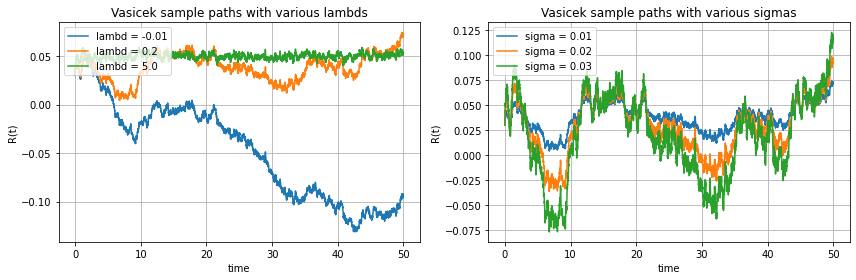

In [ ]:
def main():
    num_paths = 1
    num_steps = 5_000 
    theta = 0.05 
    r0 = 0.03
    T = 50
 
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))

    ax0.set_title("Vasicek sample paths with various lambds")
    lambds = [-0.01, 0.2, 5.0]
    sigma = 0.01
    for lambd in lambds:
        vasicek = Vasicek(lambd, theta, sigma)
        t, R, _ = vasicek.generate_sample_path(num_paths,num_steps,T,r0,seed=0)
        ax0.plot(t, np.transpose(R), label=f'{lambd = }')      
  
    ax1.set_title("Vasicek sample paths with various sigmas")
    lambd = 0.2
    sigmas = [0.01, 0.02, 0.03]
    for sigma in sigmas:
        vasicek = Vasicek(lambd, theta, sigma)
        t, R, _ = vasicek.generate_sample_path(num_paths,num_steps,T,r0,seed=0)
        ax1.plot(t, np.transpose(R), label=f'{sigma = }') 
        
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_xlabel("time")
        ax.set_ylabel("R(t)")
        ax.legend(loc="upper left")
        
    plt.tight_layout()
    plt.show()
       
if __name__ == "__main__":
    main()

#####***Vasicek Model Solution***

$$\begin{array}{lllll}
\displaystyle
r(t)=r(s)e^{-\lambda(t-s)}+\theta\left(1-e^{-\lambda(t-s)}\right)
+\sigma\int_s^t e^{-\lambda(t-t')}dW^\mathbb{Q}(t')
\end{array}$$

Therefore, $r(t)$ conditional on ${\cal F}(s)$ is normally distributed with mean and variance given respectively by

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
r(s)e^{-\lambda(t-s)}+\theta\left(1-e^{-\lambda(t-s)}\right)\\
\mathbb{Var}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
\frac{\sigma^2}{2\lambda}\left(1-e^{-2\lambda(t-s)}\right)
\end{array}$$

#####***$P(t,P)$***

$$\begin{array}{lllll}
\displaystyle
P(t,T)=A(t,T)e^{-B(t,T)r(t)} 
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
A(t,T)
&=&\displaystyle
\text{exp}\left\{\left(\theta-\frac{\sigma^2}{2\lambda^2}\right)[B(t,T)-T+t]-\frac{\sigma^2}{4\lambda}B(t,T)^2\right\}
\\
\displaystyle
B(t,T)
&=&\displaystyle
\frac{1}{\lambda}\left[1-e^{-\lambda(T-t)}\right]
\end{array}$$

######***Proof***

The ZCB price can be derived by computing the expectation 

$$
\displaystyle
\mathbb{E^Q}e^{-\int_t^Tr(t')dt'}
$$

#####***Vasicek Model under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
dr(t)=\left[\lambda\left(\theta-r(t)\right)-\sigma^2B(t,T) \right]dt+\sigma dW^\mathbb{T}(t)
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
dW^\mathbb{T}(t)=\sigma B(t,T) dt + dW^\mathbb{Q}(t)
\end{array}$$

#####***Vasicek Model Solution under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
r(t)=r(s)e^{-\lambda(t-s)}+M^\mathbb{T}(s,t)
+\sigma\int_s^t e^{-\lambda(t-t')}dW^\mathbb{T}(t')
\end{array}$$

where

$$
\displaystyle
M^\mathbb{T}(s,t)
=
\left(\theta-\frac{\sigma^2}{\lambda^2}\right)
\left(1-e^{-\lambda(t-s)}\right)
+\frac{\sigma^2}{2\lambda^2}e^{-\lambda(T-t)}\left[1-e^{-2\lambda(t-s)}\right]
$$

$r(t)$ conditional on ${\cal F}(s)$ is normally distributed with mean and variance given respectively by

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
r(s)e^{-\lambda(t-s)}+M^\mathbb{T}(s,t)\\
\mathbb{Var}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
\frac{\sigma^2}{2\lambda}\left(1-e^{-2\lambda(t-s)}\right)
\end{array}$$

#####***ZBO***

$$\begin{array}{lll}
\text{Current Time}&&t\\
\text{Option Maturity}&&T>t\\
\text{Underlying ZCB Maturity}&&S>T>t\\
\text{Strike}&&K\\
\text{Call Option Payoff at Option Maturity}&&(P(T,S)-K)^+\\
\text{Put Option Payoff at Option Maturity}&&(K-P(T,S))^+\\
\end{array}$$

Jamshidian (1989) shows

$$
\displaystyle
{\bf\text{ZBO}}(t,T,S,K,\omega)
=
\left\{\begin{array}{lll}
P(t,S)N(d_1)-KP(t,T)N(d_2)&&\text{if $\omega=1$ or if call}\\
-P(t,S)N(-d_1)+KP(t,T)N(-d_2)&&\text{if $\omega=-1$ or if put}\\
\end{array}\right.
$$

where

$$\begin{array}{lll}
\sigma_p&=&\displaystyle
\sigma\sqrt{\frac{1-e^{-2\lambda(T-t)}}{2\lambda}}B(T,S)
\\
d_1&=&\displaystyle
\frac{1}{\sigma_p}\log\frac{P(t,S)}{P(t,T)K}+\frac{1}{2}\sigma_p\\
d_2&=&\displaystyle
d_1-\sigma_p\\
\end{array}$$

######***Proof***

Using the known distribution of $r(T)$ under $\mathbb{T}$, compute

$$\begin{array}{lll}
\displaystyle
\mathbb{E^Q}e^{-\int_t^Tr(t')dt'}(P(T,S)-K)^+
=
P(t,T)\mathbb{E^T}(P(T,S)-K)^+
\end{array}$$

####***Section 2 Short Rate***



The short rate $r(t)$ is not a $\mathbb{Q}$-martingale since it is not tradable.

$$\begin{array}{lllll}
\displaystyle
dr(t)=\beta(t,r(t))dt+\gamma(t,r(t))dW^\mathbb{Q}(t)
\end{array}$$

####***Section 3 ZCB***

######***ZCB***



Since the zero coupon bond is  tradable, 
$P(t,T)/M(t)$ is a $\mathbb{Q}$-martingale.

$$\begin{array}{llllll}
\displaystyle
\frac{P(t,T)}{M(t)}
=\mathbb{E}^\mathbb{Q}\left[\frac{P(T,T)}{M(T)}\Big{|}{\cal F}_t\right]
\end{array}$$

Since $P(T,T)=1$,

$$\begin{array}{llllll}
\displaystyle
P(t,T)
=\mathbb{E}^\mathbb{Q}\left[\frac{M(t)}{M(T)}\Big{|}{\cal F}_t\right]
=\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^Tr(s)ds}\Big{|}{\cal F}_t\right]
\end{array}$$



####***Section 4 Short Rate Models***

######***Affine Models***

***PDE for ZCB***

$$\begin{array}{lllll}
\displaystyle
P(t,T)
=
f(t,r(t))
\end{array}$$

Since the zero coupon bond is  tradable, 
$P(t,T)/M(t)$ is a $\mathbb{Q}$-martingale.

$$\begin{array}{lllll}
\displaystyle
d\frac{f}{M}
=
\frac{1}{M}\left[-rf+f_t+\beta f_r+\frac{1}{2}\gamma^2 f_{rr}\right]dt+\frac{1}{M}\gamma f_rdW^Q
\end{array}$$

Setting the dt term equal to zero, we obtain PDE

$$\begin{array}{lllll}
\text{PDE}&&\displaystyle
f_t+\beta f_r+\frac{1}{2}\gamma^2 f_{rr}=rf\\
\text{Terminal Condition}&&f(T,r)=1
\end{array}$$

***Affine Short Rate Model***

$$\begin{array}{lllll}
\displaystyle
P(t,T)=A(t,T)e^{-B(t,T)r(t)} 
\end{array}$$

######***Merton Model***

***Model***

$$\begin{array}{lllll}
\displaystyle
dr_t=\theta dt+\sigma dw_t
\end{array}$$

***Mean and Variance***

$$
\displaystyle
\mathbb{E}r_t=\theta t +r_0,\quad
Var(r_t)=\sigma^2 t
$$

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}dr_t=\theta dt
\quad\Rightarrow\quad
\frac{\mathbb{E}dr_t}{dt}=\theta 
\quad\Rightarrow\quad
\frac{d\mathbb{E}r_t}{dt}=\theta 
\quad\Rightarrow\quad
\mathbb{E}r_t=\theta t +r_0
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
Var(dr_t)=\sigma^2 dt
\quad\Rightarrow\quad
Var(r_t)=\sigma^2 t
\end{array}$$

######***CIR Model***

***Model***

$$\begin{array}{lllll}
\displaystyle
dr(t)=\lambda(\theta-r(t)) dt+\gamma\sqrt{r(t)} dW^{\mathbb{Q}}(t)
\end{array}$$

***Mean***

$$
\displaystyle
\mathbb{E}r_t=\theta-(\theta-r_0)e^{-\alpha t}
$$

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}dr_t=\alpha(\theta-\mathbb{E}r_t) dt
\quad\Rightarrow\quad
\frac{d\mathbb{E}r_t}{dt}=\alpha(\theta-\mathbb{E}r_t)
\quad\Rightarrow\quad
y'=\alpha(\theta-y)
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\frac{dy}{\theta-y}=\alpha dt
\quad\Rightarrow\quad
\int_0^t\frac{dy}{\theta-y}=\int_0^t\alpha ds
\quad\Rightarrow\quad
\left[-\log(\theta-y)\right]_0^t=\alpha t
\quad\Rightarrow\quad
\mathbb{E}r_t=y=\theta-(\theta-r_0)e^{-\alpha t}
\end{array}$$

***ZCB***

$$\begin{array}{lllll}
\displaystyle
P(t,T)=A(t,T)e^{-B(t,T)r(t)} 
\end{array}$$

where, with $\gamma=\sqrt{a^2+2\sigma^2}$

$$
\displaystyle
B(t,T)=\frac{2(e^{\gamma(T-t)}-1)}{(\gamma+a)(e^{\gamma(T-t)}-1)+2\gamma}
$$

$$
\displaystyle
A(t,T)=\left[\frac{2\gamma e^{(a+\gamma)(T-t)/2}}{(\gamma+a)(e^{\gamma(T-t)}-1)+2\gamma}\right]^{2ab/\sigma^2}
$$

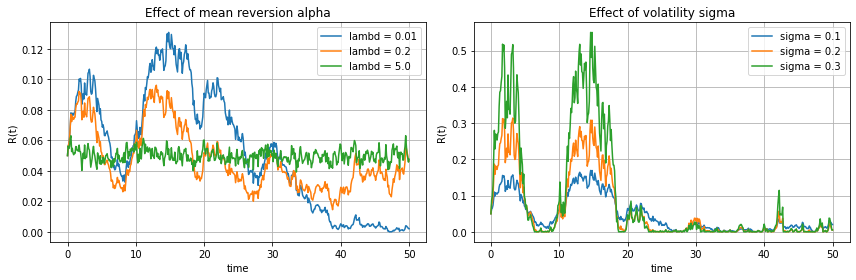

In [ ]:
#@title Simulation of CIR Model
import matplotlib.pyplot as plt
import numpy as np

def generate_sample_path(num_paths, num_steps, T, lambd, theta, r0, sigma, seed=None): 
    if seed is not None:
        np.random.seed(seed)
        
    Z = np.random.normal(0.0, 1.0, (num_paths, num_steps) )
    R = np.ones( ( num_paths, num_steps + 1 ) ) * r0
    t = np.linspace( 0, T, num_steps + 1 )
        
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    for i in range(num_steps):
        if num_paths > 1:
            Z[:,i] = (Z[:,i] - Z[:,i].mean()) / Z[:,i].std()
        dW = sqrt_dt * Z[:,i]
        R[:,i+1] = R[:,i] + lambd * ( theta - R[:,i] ) * dt + sigma * np.sqrt( R[:,i] ) * dW
        R[:,i+1] = np.maximum(R[:,i+1], 0.0) # Truncated boundary condition        
    return t, R

def main():
    num_paths = 1 
    num_steps = 500 
    T = 50 
    lambd = 0.1 
    theta = 0.05 
    r0 = 0.05 
    sigma = 0.05 
    seed = 0
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))

    legend_lambds = []
    lambds = [0.01, 0.2, 5.0]
    sigma = 0.05
    for lambd in lambds: 
        legend_lambds.append(f'{lambd = }')
        t, R = generate_sample_path(num_paths, num_steps, T, lambd, theta, r0, sigma, seed=seed)
        ax0.plot(t, np.transpose(R))
        
    legend_sigmas = []
    lambd = 0.1
    sigmas = [0.1, 0.2, 0.3]
    for sigma in sigmas:
        legend_sigmas.append(f'{sigma = }')
        t, R = generate_sample_path(num_paths, num_steps, T, lambd, theta, r0, sigma, seed=seed)
        ax1.plot(t, np.transpose(R))
    
    titles = ("Effect of mean reversion alpha", "Effect of volatility sigma")
    for ax, legend, title in zip((ax0, ax1), (legend_lambds, legend_sigmas), titles):
        ax.grid()
        ax.set_xlabel("time")
        ax.set_ylabel("R(t)")
        ax.set_title(title)
        ax.legend(legend)
        
    plt.tight_layout()
    plt.show()        
       
if __name__ == "__main__":
    main()

######***Short Rate Models***



$$\begin{array}{llllll}
\text{Dothan (1978)}&&\displaystyle
dr=\mu r dt+\sigma r dW\\
\text{Rendleman-Bartter (1980)}&&\displaystyle
dr=\mu r dt+\sigma r dW\\
\\
\text{Merton}&&\displaystyle
dr=\theta dt+\sigma dW\\
\Rightarrow\quad\text{Ho-Lee (1986)}&&\displaystyle
dr=\theta(t) dt+\sigma dW\\
\\
\text{Vasicek (1977)}&&\displaystyle
dr=a(b-r) dt+\sigma dW\\
\Rightarrow\quad\text{Hull-White (1990)}&&\displaystyle
dr=(\theta(t)-ar) dt+\sigma dW\\
\Rightarrow\quad\text{Hull-White 2 Factor}&&\displaystyle
dr=(\theta(t)+u-ar) dt+\sigma_1 dW_1\\
&&\displaystyle
du=-bu dt+\sigma_2 dW_2\\
&&\displaystyle
dW_1dW_2=\rho dt\\
\\
\text{CIR (1985)}&&\displaystyle
dr=a(b-r) dt+\sigma\sqrt{r} dW\\
\Rightarrow\quad\text{Brigo-Mercurio}&&\displaystyle
r = z + \phi(t,\alpha), dz=a(b-z) dt+\sigma\sqrt{z} dW\\
\\
\text{Exponential Vasicek}&&d\log r=a(b-\log r) dt+\sigma dW\\
\Rightarrow\quad\text{Black–Derman–Toy}&&\displaystyle
d\log r=(\theta(t)-a(t)\log r) dt+\sigma(t) dW,\quad
a(t)=-\sigma'(t) / \sigma(t)\\
\Rightarrow\quad\text{(Constant) Black–Derman–Toy}&&\displaystyle
d\log r=\theta(t) dt+\sigma dW\\
\Rightarrow\quad\text{Black–Karasinski}&&\displaystyle
d\log r=(\theta(t)-a(t)\log r) dt+\sigma(t) dW\\
\Rightarrow\quad\text{(Constant) Black–Karasinski}&&\displaystyle
d\log r=(\theta(t)-a\log r) dt+\sigma dW\\
\end{array}$$

###***Chapter 4 HJM***

####***Section 1 Equilibrium vs No-Arbitragy Model***

#####***Equilibrium vs No-Arbitragy Model***



$$\begin{array}{ccccccccc}
&&\fbox{Equilibrium Model}&\Rightarrow&\text{Current Yield Curve}\\
\\
\text{Current Yield Curve}&\Rightarrow&\fbox{No-Arbitragy Model}&&\\
\end{array}$$

#####***From Equilibrium To No-Arbitragy Model***



$$\begin{array}{lll}
\fbox{Equilibrium Model}&\stackrel{\text{HJM}}{\Rightarrow}&
\fbox{No-Arbitragy Model}
\end{array}$$

#####***HJM***



HJM uses the dynamics of the (instantaneous) forward (rate) curve.

HJM provides a necessary and sufficient condition for a model to be free of arbitrage. 

####***Section 2 HJM***

#####***Instantaneous Forward Rate $f(t,T)$***



$$\displaystyle
f(t,T)
=
\lim_{S\rightarrow T}R(t,S,T)
=
-\lim_{S\rightarrow T}\frac{\log P(t,T)-\log P(t,S)}{T-S}
=
-\frac{\partial }{\partial T}\log P(t,T)
$$ 



Exercise. Show that

$$\displaystyle
f(t,T)
=
\lim_{S\rightarrow T}L(t,S,T)
$$ 

where

$$\displaystyle
L(t,S,T)
=
\frac{1}{T-S}\left(\frac{P(t,S)}{P(t,T)}-1\right)
$$

#####***ZCB Price $P(t,T)$ in terms of $f(t,T)$***

$$\begin{array}{lll}
\displaystyle
P(t,T)
=
\text{exp}\left(-\int_t^Tf(t,T')dT'\right)
\end{array}$$



######***Proof***



$$\begin{array}{lll}
\displaystyle
f(t,T)=-\frac{\partial }{\partial T}\log P(t,T)
&\Rightarrow&\displaystyle
f(t,T')=-\frac{\partial }{\partial T'}\log P(t,T')\\
&\Rightarrow&\displaystyle
\int_t^Tf(t,T')dT'=-\log P(t,T)\\
&\Rightarrow&\displaystyle
P(t,T)
=
\text{exp}\left(-\int_t^Tf(t,T')dT'\right)
\end{array}$$

#####***from $P(t,T)$ to $f(t,T)$***

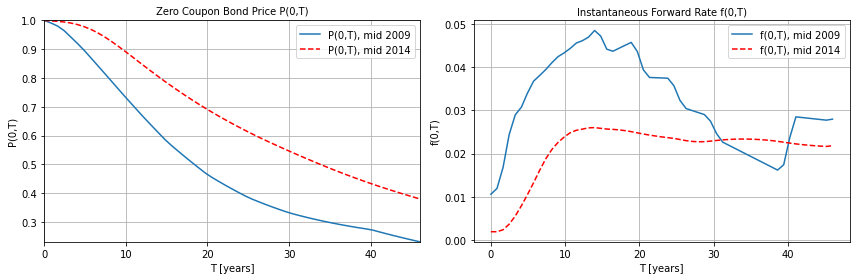

In [ ]:
# Source
# https://github.com/LechGrzelak/QuantFinanceBook/blob/master/PythonCodes/Chapter%2011/Fig11_04.py
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d 


def main():
    # time grid t1
    t1 = [0,0.821900,1.64380,2.46580,3.28770,4.10960,4.93150,5.75340,6.57530,\
          7.39730,8.21920,9.04110,9.86300,10.68490,11.50680,12.32880,13.15070,\
          13.97260,14.79450,15.61640,16.43840,17.26030,18.08220,18.90410,19.7260,\
          20.54790,21.36990,22.19180,23.01370,23.83560,24.65750,25.47950,26.30140,\
          27.12330,27.94520,28.76710,29.5890,30.4110,31.23290,32.05480,32.87670,\
          33.69860,34.52050,35.34250,36.16440,36.98630,37.80820,38.63010,39.45210,\
          40.2740,41.09590,41.91780,42.73970,43.56160,44.38360,45.20550,46.02740]
    
    # time grid t2
    t2 = [0,0.821900,1.64380,2.46580,3.28770,4.10960,4.93150,5.75340,6.57530,\
          7.39730,8.21920,9.04110,9.86300,10.68490,11.50680,12.32880,13.15070,\
          13.97260,14.79450,15.61640,16.43840,17.26030,18.08220,18.90410,19.7260,\
          20.54790,21.36990,22.19180,23.01370,23.83560,24.65750,25.47950,26.30140,\
          27.12330,27.94520,28.76710,29.5890,30.4110,31.23290,32.05480,32.87670,\
          33.69860,34.52050,35.34250,36.16440,36.98630,37.80820,38.63010,39.45210,\
          40.2740,41.09590,41.91780,42.73970,43.56160,44.38360,45.20550,46.02740]
    
    # discount factor df1
    df1 = [1,0.9912650,0.9805340,0.9641250,0.9418240,0.9192670,0.895380,0.8692230,\
          0.8428550,0.8164780,0.7899110,0.7632080,0.7367020,0.7107840,0.684920,\
          0.6594810,0.6349270,0.6105070,0.5862780,0.5650440,0.545270,0.5258950,\
          0.5069240,0.4883650,0.4702220,0.4546480,0.4408020,0.4273960,0.4144180,\
          0.4018510,0.3896830,0.3789860,0.3695590,0.3605050,0.3518070,0.343450,\
          0.3354190,0.3282840,0.3221350,0.3162880,0.310730,0.3054490,0.3004350,\
          0.2956780,0.2911670,0.2868940,0.282850,0.2790270,0.2754190,0.2711330,\
          0.2648390,0.2587240,0.2527820,0.2470070,0.2413950,0.2359390,0.2306360]
    
    # discount factor df2
    df2 = [1,0.9983970,0.9968090,0.994460,0.9907650,0.985370,0.977910,0.9684380,\
         0.9567750,0.9430350,0.927610,0.9110590,0.8937890,0.8760590,0.858030,\
         0.8402370,0.8225770,0.8051410,0.7881340,0.7716530,0.7555510,0.7398430,\
         0.724550,0.7096920,0.6952860,0.6813370,0.6678080,0.6546720,0.6419040,\
         0.6294840,0.617390,0.6056190,0.5942220,0.583150,0.5723440,0.5617510,\
         0.5513190,0.5410060,0.530820,0.5207770,0.5108910,0.5011740,0.4916370,\
         0.4822890,0.4731410,0.4641990,0.4554720,0.4469650,0.4386860,0.4306370,\
         0.4228050,0.4151740,0.407730,0.4004620,0.3933560,0.3864040,0.3795930]
    
    # zero coupon bond price P1, as a function of maturity T, computed using t1 and df1
    P1 = interp1d(t1, df1, fill_value='extrapolate') 
    
    # zero coupon bond price P2, as a function of maturity T, computed using t2 and df2
    P2 = interp1d(t2, df2, fill_value='extrapolate')
    
    # forward rate f1, as a function of time t, computed using P1  
    f1 = lambda t: f(t, P1)
    
    # forward rate f2, as a function of time t, computed using P2  
    f2 = lambda t: f(t, P2)
    
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,4))

    ax0.set_title('Zero Coupon Bond Price P(0,T)', fontsize=10)
    ax0.set_ylabel('P(0,T)',fontsize=10)
    ax0.plot(t1, df1, label='P(0,T), mid 2009');
    ax0.plot(t2, df2,'--r', label='P(0,T), mid 2014');
    ax0.axis([0.0, np.max(t1), np.min(df1), np.max(df1)])

    ax1.set_title('Instantaneous Forward Rate f(0,T)', fontsize=10)
    ax1.set_ylabel('f(0,T)',fontsize=10)
    ax1.plot(t1, f1(np.array(t1)), label='f(0,T), mid 2009')
    ax1.plot(t2, f2(np.array(t2)), '--r', label='f(0,T), mid 2014')
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.legend(fontsize=10)
        ax.set_xlabel('T [years]',fontsize=10)
        
    plt.tight_layout()
    plt.show()
    
        
if __name__ == "__main__":
    main() 

#####***Instantaneous Forward Rate Dynamics*** 

$$\begin{array}{lllll}
\displaystyle
df(t,T)
=
\mu^{\mathbb{Q}}(t,T)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)
\end{array}$$

#####***HJM No Arbitrage Condition***

$$\begin{array}{lllll}
\displaystyle
\mu^{\mathbb{Q}}(t,T)
=\sigma(t,T)\int_t^T\sigma(t,T')dT'
\end{array}$$

####***Section 3 Dynamics under HJM***

#####***Short Rate in trems of $f$***



$$\begin{array}{lllll}
\displaystyle
r(t)
=f(t,t)
=f(0,t)+\int_0^t\mu^\mathbb{Q}(t',t)dt'+\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

######***Proof***



From the instantaneous forward rate dynamics

$$\begin{array}{lllll}
\displaystyle
df(t,T)
=
\mu^\mathbb{Q}(t,T)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)
\end{array}$$

we have

$$\begin{array}{lllll}
\displaystyle
df(t',t)
=
\mu^\mathbb{Q}(t',t)dt'+\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

Integrate the above. Then,

$$\begin{array}{lllll}
\displaystyle
f(t,t)-f(0,t)
=
\int_0^tdf(t',t)
=
\int_0^t\mu^\mathbb{Q}(t',t)dt'+\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

Therefore,

$$\begin{array}{lllll}
\displaystyle
r(t)
=f(t,t)
=f(0,t)+\int_0^t\mu^\mathbb{Q}(t',t)dt'+\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

#####***Short Rate Dynamics under HJM Framework***



$$\begin{array}{lllll}
\displaystyle
dr(t)
=
\mu^\mathbb{Q}(t)dt+\sigma(t)dW^{\mathbb{Q}}(t)
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\mu^\mathbb{Q}(t)
=
\mu^\mathbb{Q}(t,t)+
\frac{\partial f(0,t)}{\partial t}
+\int_0^t\frac{\partial \mu^\mathbb{Q}(t',t)}{\partial t}dt'
+\int_0^t\frac{\partial \sigma(t',t)}{\partial t}dW^{\mathbb{Q}}(t')
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\sigma(t)=\sigma(t,t)
\end{array}$$

######***Proof***



Since $df(t,T)=\mu^\mathbb{Q}(t,T)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)$,

$$\begin{array}{lllll}
\displaystyle
f(t,T)
=
f(0,T)
+\int_0^t\mu^\mathbb{Q}(t',T)dt'+\int_0^t\sigma(t',T)dW^{\mathbb{Q}}(t')
\end{array}$$

Since $r(t)=f(t,t)$,

$$\begin{array}{lllll}
\displaystyle
r(t)
=
f(0,t)
+\int_0^t\mu^\mathbb{Q}(t',t)dt'+\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

Since
$
f(0,t)
=f(0,0)+\left[f(0,t)-f(0,0)\right]
=f(0,0)+\int_0^t\frac{\partial f(0,T')}{\partial T'}dT'
$,

$$
\displaystyle
df(0,t)
=
\frac{\partial f(0,t)}{\partial t}dt
$$

Since

$$\begin{array}{lllll}
\displaystyle
\int_0^t\mu^\mathbb{Q}(t',t)dt'
&=&\displaystyle
\int_0^t\mu^\mathbb{Q}(t',t')dt'
+
\int_0^t\left[\mu^\mathbb{Q}(t',t)-\mu^\mathbb{Q}(t',t')\right]dt'\\
&=&\displaystyle
\int_0^t\mu^\mathbb{Q}(t',t')dt'
+
\int_0^t\left(\int_{t'}^t\frac{\partial \mu^\mathbb{Q}(t',T')}{\partial T'}dT'\right)dt'\quad(\text{Fubini})\\
&=&\displaystyle
\int_0^t\mu^\mathbb{Q}(t',t')dt'
+
\int_0^t\left(\int_0^{T'}\frac{\partial \mu^\mathbb{Q}(t',T')}{\partial T'}dt'\right)dT'
\end{array}$$

we have

$$\begin{array}{lllll}
\displaystyle
d\int_0^t\mu^\mathbb{Q}(t',t)dt'
&=&\displaystyle
\mu^\mathbb{Q}(t,t)dt
+
\left(\int_0^t\frac{\partial \mu^\mathbb{Q}(t',t)}{\partial t}dt'\right)dt
\end{array}$$

Since

$$\begin{array}{lllll}
\displaystyle
\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
&=&\displaystyle
\int_0^t\sigma(t',t')dW^{\mathbb{Q}}(t')
+
\int_0^t\left[\sigma(t',t)-\sigma(t',t')\right]dW^{\mathbb{Q}}(t')\\
&=&\displaystyle
\int_0^t\sigma(t',t')dW^{\mathbb{Q}}(t')
+
\int_0^t\left(\int_{t'}^t\frac{\partial \sigma(t',T')}{\partial T'}dT'\right)dW^{\mathbb{Q}}(t')\quad(\text{Fubini})\\
&=&\displaystyle
\int_0^t\sigma(t',t')dW^{\mathbb{Q}}(t')
+
\int_0^t\left(\int_0^{T'}\frac{\partial \sigma(t',T')}{\partial T'}dW^{\mathbb{Q}}(t')\right)dT'
\end{array}$$

we have

$$\begin{array}{lllll}
\displaystyle
d\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
&=&\displaystyle
\sigma(t,t)dW^{\mathbb{Q}}(t)
+
\left(\int_0^t\frac{\partial \sigma(t',t)}{\partial t}dW^{\mathbb{Q}}(t')\right)dt\\
\end{array}$$

#####***ZCB Price in terms of $r$***

$$\begin{array}{lllll}
\displaystyle
P(t,T)
=
\mathbb{E}^{\mathbb{Q}}\left[\text{exp}\left(-\int_t^Tr(t')dt'\right)\Big{|}{\cal F}(t)\right]
\end{array}$$



######***Proof***



$$\begin{array}{lllll}
\displaystyle
\frac{P(t,T)}{M(t)}
=
\mathbb{E}^{\mathbb{Q}}\left[\frac{P(T,T)}{M(T)}\Big{|}{\cal F}(t)\right]
=
\mathbb{E}^{\mathbb{Q}}\left[\frac{1}{M(T)}\Big{|}{\cal F}(t)\right]
\end{array}$$

So,

$$\begin{array}{lllll}
\displaystyle
P(t,T)
=
\mathbb{E}^{\mathbb{Q}}\left[\frac{M(t)}{M(T)}\Big{|}{\cal F}(t)\right]
=
\mathbb{E}^{\mathbb{Q}}\left[\text{exp}\left(-\int_t^Tr(t')dt'\right)\Big{|}{\cal F}(t)\right]
\end{array}$$

#####***ZCB Price Dynamics*** 



$$\begin{array}{lllll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
=
r(t)dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\sigma_P(t,T)
=
-\int_t^T\sigma(t,T')dT'
\end{array}$$

######***Proof***



$$
\displaystyle
P(t,T)
=\text{exp}\left(-\int_t^Tf(t,T')dT'\right)
:=e^{-Z(t)}
$$

$$\begin{array}{lll}
\displaystyle
dZ(t)
&=&\displaystyle
d\int_t^Tf(t,T')dT'\\
&=&\displaystyle
-f(t,t)dt+\int_t^Tdf(t,T')dT'\\
&=&\displaystyle
-f(t,t)dt+\int_t^T\left[\mu^\mathbb{Q}(t,T')dt+\sigma(t,T')dW^\mathbb{Q}(t)\right]dT'\\
&=&\displaystyle
\left[-f(t,t)+\int_t^T\mu^\mathbb{Q}(t,T')dT'\right]dt+\left[\int_t^T\sigma(t,T')dT'\right]dW^\mathbb{Q}(t)\\
&=&\displaystyle
\left[-r(t)+\int_t^T\mu^\mathbb{Q}(t,T')dT'\right]dt+\left[\int_t^T\sigma(t,T')dT'\right]dW^\mathbb{Q}(t)\\
\end{array}$$

$$\begin{array}{lll}
\displaystyle
dP(t,T)
&=&\displaystyle
-e^{-Z(t)}dZ+\frac{1}{2}e^{-Z(t)}(dZ)^2\\
&=&\displaystyle
e^{-Z(t)}\left(r(t)-\int_t^T\mu^\mathbb{Q}(t,T')dT'+\frac{1}{2}\left(\int_t^T\sigma(t,T')dT'\right)^2\right)dt
-e^{-Z(t)}\left(\int_t^T\sigma(t,T')dT'\right)dW^{\mathbb{Q}}(t)
\end{array}$$

Since $P(t,T)=e^{-Z(t)}$,

$$\begin{array}{lll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
&=&\displaystyle
\left(r(t)-\int_t^T\mu^\mathbb{Q}(t,T')dT'+\frac{1}{2}\left(\int_t^T\sigma(t,T')dT'\right)^2\right)dt
-\left(\int_t^T\sigma(t,T')dT'\right)dW^{\mathbb{Q}}(t)
\end{array}$$

We claim

$$\begin{array}{lllll}
\displaystyle
\frac{1}{2}\left(\int_t^T\sigma(t,T')dT'\right)^2
&=&\displaystyle
\int_t^T\mu^\mathbb{Q}(t,T')dT'
\end{array}$$

If this claim is justified, then we have the above ZCB dynamics.

***Claim***
$$\begin{array}{lllll}
\displaystyle
\frac{1}{2}\left(\int_t^T\sigma(t,T')dT'\right)^2
&=&\displaystyle
\int_t^T\mu^\mathbb{Q}(t,T')dT'
\end{array}$$

***Proof of Claim***

We treat both sides of the claim as a function of $T$. They agree at $T=t$. Their derivatives also agree: 

$$\begin{array}{lllll}
\displaystyle
\frac{d}{dT}\left[\frac{1}{2}\left(\int_t^T\sigma(t,T')dT'\right)^2\right]
=
\sigma(t,T)\int_t^T\sigma(t,T')dT'
=
\mu^\mathbb{Q}(t,T)
\end{array}$$

Therefore, the claim holds for the general $T$.

####***Section 4 Proof of HJM No Arbitrage Condition***

#####***Proof***

Since $P(t,T)$ is tradable,
$P(t,T)/M(t)$ is a $\mathbb{Q}$-martingale by [Harrison and Kreps, 1979].
Thus, its dynamics has no drift term.

$$
\displaystyle
\frac{P(t,T)}{M(t)}
=\text{exp}\left(-\int_t^Tf(t,T')dT'-\int_0^tr(t')dt'\right)
:=e^{-Z(t)}
$$

$$\begin{array}{lll}
\displaystyle
dZ(t)
&=&\displaystyle
d\int_t^Tf(t,T')dT'+d\int_0^tr(t')dt'\\
&=&\displaystyle
-f(t,t)dt+\int_t^Tdf(t,T')dT'+r(t)dt\\
&=&\displaystyle
-f(t,t)dt+\int_t^T\left[\mu^\mathbb{Q}(t,T')dt+\sigma(t,T')dW^\mathbb{Q}(t)\right]dT'+r(t)dt\\
&=&\displaystyle
\left[-f(t,t)+\int_t^T\mu^\mathbb{Q}(t,T')dT'+r(t)\right]dt+\left[\int_t^T\sigma(t,T')dT'\right]dW^\mathbb{Q}(t)\\
&=&\displaystyle
\left[\int_t^T\mu^\mathbb{Q}(t,T')dT'\right]dt+\left[\int_t^T\sigma(t,T')dT'\right]dW^\mathbb{Q}(t)\\
\end{array}$$

$$\begin{array}{lll}
\displaystyle
d\frac{P(t,T)}{M(t)}
&=&\displaystyle
-e^{-Z(t)}dZ+\frac{1}{2}e^{-Z(t)}(dZ)^2\\
&=&\displaystyle
-e^{-Z(t)}
\left(
\left[\int_t^T\mu^\mathbb{Q}(t,T')dT'\right]dt+\left[\int_t^T\sigma(t,T')dT'\right]dW^\mathbb{Q}(t)
\right)
+\frac{1}{2}e^{-Z(t)}
\left[\int_t^T\sigma(t,T')dT'\right]^2dt\\
\end{array}$$

Set the drift term equal to zero.

$$\begin{array}{lll}
\displaystyle
\int_t^T\mu^\mathbb{Q}(t,T')dT'
=\frac{1}{2}
\left[\int_t^T\sigma(t,T')dT'\right]^2\\
\end{array}$$

Differenciating with respect to $T$, we have

$$\begin{array}{lll}
\displaystyle
\mu^\mathbb{Q}(t,T)
=
\sigma(t,T)\left[\int_t^T\sigma(t,T')dT'\right]\\
\end{array}$$

#####***Another Proof based on ZCB Price Dynamics***





Since $f(t,T)=-\frac{d}{dT}\log P(t,T)$,

$$\begin{array}{lllllll}
\displaystyle
df(t,T)
=
-\frac{d}{dT}d\log P(t,T)
\end{array}$$

Since $dP(t,T)/P(t,T)=r(t) dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)$,

$$\begin{array}{lllll}
\displaystyle
d\log P(t,T)
&=&\displaystyle
\frac{1}{P(t,T)}dP(t,T)
-\frac{1}{2}\frac{1}{P(t,T)^2}\left(dP(t,T)\right)^2\\
&=&\displaystyle
\left(r(t)-\frac{1}{2}\sigma^2_P(t,T)\right)dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)\\
\end{array}$$

Since $\sigma_P(t,T)
=
-\int_t^T\sigma(t,T')dT'$,

$$\begin{array}{lllllll}
\displaystyle
df(t,T)
&=&\displaystyle
-\frac{d}{dT}d\log P(t,T)\\
&=&\displaystyle
\frac{1}{2}\frac{d\sigma^2_P(t,T)}{dT}dt-\frac{d \sigma_P(t,T)}{dT}dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
\sigma(t,T)\left(\int_t^T\sigma(t,T')dT'\right)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)\\
&:=&\displaystyle
\mu^{\mathbb{Q}}(t,T)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)\\
\end{array}$$

Therefore,
$$
\displaystyle
\mu^{\mathbb{Q}}(t,T)
=
\sigma(t,T)\int_t^T\sigma(t,T')dT'
$$

###***Chapter 5 Change of Measure***

#####***Section 1 Radon-Nykodym Derivative***

######***Radon-Nykodym Derivative***



A Radon-Nykodym derivative $d\mathbb{Q}/d\mathbb{P}$ is a random variable defined on $\Omega$ such that

$$\begin{array}{lllllll}
(1)&&\displaystyle
\frac{d\mathbb{Q}}{d\mathbb{P}}:(\Omega,{\cal F},\mathbb{P})\rightarrow\mathbb{R}\quad\text{is a positive random variable a.s.}\\
(2)&&\displaystyle
\mathbb{E^P}\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right]=\int\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}=1
\end{array}$$

####***Section 2 Change of Measure (Discrete Case)***

######***Change of Measure (Discrete Case)***



Suppose we have two probability measures $\mathbb{P}$ and $\mathbb{Q}$ such that
$\mathbb{P}(\omega)>0$, $\mathbb{Q}(\omega)\ge0$ for all $\omega\in\Omega$.
Then, two probability measures $P$ and $Q$ are related as 

$$\begin{array}{cccccccccc}
\mathbb{Q}(\omega)&=&Z(\omega)&\mathbb{P}(\omega)\\
\uparrow&&\uparrow&\uparrow\\
\text{New Measure}&&\text{Radon-Nykodym}&\text{Old Measure}\\
\text{}&&\text{Derivative}&\text{}\\
\end{array}$$

where the Radon-Nykodym derivative $Z=d\mathbb{Q}/d\mathbb{P}$ is given by

$$
Z(\omega)=\frac{d\mathbb{Q}}{d\mathbb{P}}(\omega)=\frac{d\mathbb{Q}(\omega)}{d\mathbb{P}(\omega)} = \frac{\mathbb{Q}(\omega)}{\mathbb{P}(\omega)}
$$

######***Three Properties of Change of Measure***

$$\begin{array}{lllllllllll}
\displaystyle
\text{(1)}&&\displaystyle Z(\omega)\ge0&&\displaystyle \frac{d\mathbb{Q}}{d\mathbb{P}}(\omega)\ge0\\
\text{(2)}&&\displaystyle E^\mathbb{P}[Z]=1&&\displaystyle E^\mathbb{P}\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right]=1&&\displaystyle \int\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}=\int d\mathbb{Q}=1\\
\text{(3)}&&\displaystyle E^\mathbb{Q}[X]=E^\mathbb{P}[XZ]&&\displaystyle E^\mathbb{Q}\left[X\right]=E^\mathbb{P}\left[X\frac{d\mathbb{Q}}{d\mathbb{P}}\right]&&\displaystyle\int Xd\mathbb{Q}=\int X\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}\\
\end{array}$$

***Proof*** 

$$\begin{array}{llllll}
(2)&\displaystyle E^\mathbb{P}[Z]
=\sum_\omega Z(\omega)\mathbb{P}(\omega)
=\sum_\omega \frac{\mathbb{Q}(\omega)}{\mathbb{P}(\omega)}\mathbb{P}(\omega)
=\sum_\omega \mathbb{Q}(\omega)
=1\\
(3)&\displaystyle E^\mathbb{Q}[X]
=\sum_\omega X(\omega)\mathbb{Q}(\omega)
=\sum_\omega X(\omega)\frac{\mathbb{Q}(\omega)}{\mathbb{P}(\omega)}\mathbb{P}(\omega)
=\sum_\omega X(\omega)Z(\omega)\mathbb{P}(\omega)
=E^\mathbb{P}[XZ]
\end{array}$$

####***Section 3 Change of Measure (Continuous Case)***

######***Change of Measure (Continuous Case)***



Let $Z$ be a Radon-Nykodym derivative, that is, a random variable with
$\mathbb{P}(Z\ge0)=1$ and $E^\mathbb{P}[Z]=1$.
Define $\mathbb{Q}:{\cal F}\rightarrow\mathbb{R}$ by

$$\begin{array}{llllll}
\displaystyle
\mathbb{Q}(A)
=\int_A  d\mathbb{Q}
=\int_A  \frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}
=\int_AZ(\omega)d\mathbb{P}(\omega)=E^\mathbb{P}\left[Z;A\right]=E^\mathbb{P}\left[Z1_A\right]
\end{array}$$

Then, $\mathbb{Q}$ is a probability measure  satisfying three properties of change of measure.

#####***Girsanov Theorem (Continuous Case)***



If $B_T$ is $N(0,T)$ under the probability measure $\mathbb{P}$, 
then 
by the property of normal random variables
$B_T'=B_T+\theta T$ is obviously $N(\theta T,T)$ under the same measure $\mathbb{P}$.
However, 
if we change the probability measure from $\mathbb{P}$ to $\mathbb{Q}$
using the Radon-Nykodym derivative $d\mathbb{Q}/d\mathbb{P}=\text{exp}\left(- \frac{1}{2}\theta^2 T-\theta B_T\right)$,
$B_T'$ is $N(0,T)$ under the new probability measure $\mathbb{Q}$.

$$\begin{array}{lll}
B_T&&\text{$N(0,T)$ under $\mathbb{P}$}\\
B'_T=B_T+\theta T&&\text{$N(\theta T,T)$ under $\mathbb{P}$}\\
B'_T=B_T+\theta T&&\text{$N(0,T)$ under $\mathbb{Q}$}\\
\end{array}$$

where

$$\begin{array}{lll}
\displaystyle\frac{d \mathbb{Q}}{d\mathbb{P}}=\text{exp}\left(-\frac{1}{2}\theta^2 T-\theta B_T\right)
\end{array}$$

######***Proof***



$$\begin{array}{lll}
\displaystyle
\mathbb{Q}\left(x\le B'_T\le x+dx\right)
&=&
\displaystyle
\mathbb{Q}\left(x\le B_T+\theta T\le x+dx\right)\\
&=&
\displaystyle
\mathbb{Q}\left(x-\theta T\le B_T\le x-\theta T+dx\right)\\
&=&
\displaystyle
\frac{d \mathbb{Q}}{d \mathbb{P}}\mathbb{P}\left(x-\theta T\le B_T\le x-\theta T+dx\right)\\
&=&
\displaystyle
\text{exp}\left(-\frac{1}{2}\theta^2T-\theta B_T\right)
\frac{1}{\sqrt{2\pi T}}\text{exp}\left(-\frac{(x-\theta T)^2}{2 T}\right)dx\\
&=&
\displaystyle
\text{exp}\left(-\frac{1}{2}\theta^2T-\theta (x-\theta T)\right)
\frac{1}{\sqrt{2\pi T}}\text{exp}\left(-\frac{(x-\theta T)^2}{2 T}\right)dx\\
&=&
\displaystyle
\frac{1}{\sqrt{2\pi T}}\text{exp}\left(-\frac{x^2}{2 T}\right)dx
\end{array}$$

#####***Girsanov's Radon-Nykodym Derivative***



We use this particular Radon-Nykodym derivative in Girsanov theorem.

$$\begin{array}{lll}
\displaystyle
\frac{d\mathbb{Q}}{d\mathbb{P}}(\omega)
=\text{exp}\left(- \frac{1}{2}\theta^2 T-\theta B_T(\omega)\right)
=\text{exp}\left(- \frac{1}{2}\theta^2 T-\theta \left(B_T'(\omega)-\theta T\right)\right)
\end{array}$$

One can easily check this random variable satisfies 
Radon-Nykodym derivative's property (1) and (2). 
Since $B_T$ is $N(0,T)$ under the probability measure $\mathbb{P}$,

$$\begin{array}{lllllll}
\displaystyle
\mathbb{E^P}\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right]
&=&\displaystyle
\mathbb{E^P}\left[\text{exp}\left(- \frac{1}{2}\theta^2 T-\theta B_T\right)\right]\\
&=&\displaystyle
\int_{-\infty}^{\infty}
\text{exp}\left(- \frac{1}{2}\theta^2 T-\theta x \right)
\frac{1}{\sqrt{2\pi T}}\text{exp}\left(-\frac{x^2}{2 T}\right)
dx\\
&=&\displaystyle
\int_{-\infty}^{\infty}
\frac{1}{\sqrt{2\pi T}}\text{exp}\left(-\frac{(x+\theta T)^2}{2 T}\right)dx\\
&=&\displaystyle
1
\end{array}$$

#####***Simulation of Girsanov Theorem (Continuous Case)***

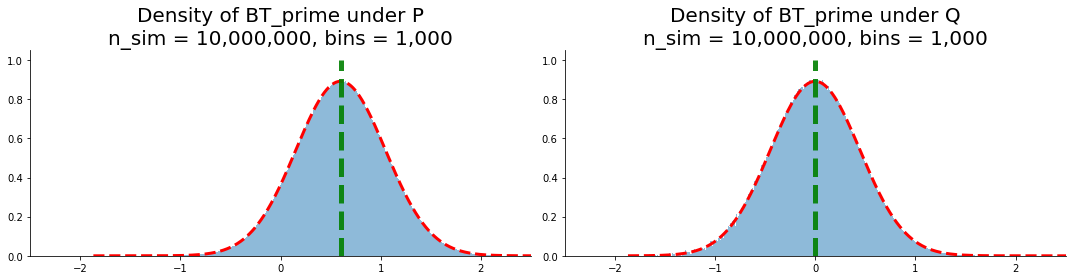

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

def generate_BT_and_BT_prime(n_sim, T, theta, seed=None):
    if seed is not None:
        np.random.seed(seed)
    BT = np.random.normal(loc=0, scale=np.sqrt(T), size=(n_sim,))
    BT_prime = BT + theta * T
    return BT, BT_prime

def compute_dQ_over_dP(x, T, theta):
    return np.exp( - theta**2 * T / 2 - theta * ( x - theta * T ) )

def compute_pdf_under_Q_using_histogram(T, theta, pdf_under_P_using_histogram, bins_loc):
    return pdf_under_P_using_histogram * compute_dQ_over_dP(bins_loc, T, theta)

def main():
    n_sim = 10_000_000
    bins = 1_000
    T = 0.2
    theta = 3
    
    _, BT_prime = generate_BT_and_BT_prime(n_sim, T, theta, seed=0)
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,4))
    
    ax0.set_title(f'Density of BT_prime under P\n{n_sim = :,}, {bins = :,}', fontsize=20)
    pdf_hist, bins_loc, _ = ax0.hist(BT_prime, bins=bins, density=True, alpha=0.5)
    pdf_under_P = stats.norm(loc=theta*T, scale=np.sqrt(T)).pdf
    ax0.plot(bins_loc[:-1], pdf_under_P(bins_loc[:-1]), color='red', linestyle='--', linewidth=3)
    ax0.plot((theta*T, theta*T), (0, 1), color='green', linestyle='--', linewidth=5, alpha=0.9)

    ax1.set_title(f'Density of BT_prime under Q\n{n_sim = :,}, {bins = :,}', fontsize=20)
    pdf_under_Q_val = compute_pdf_under_Q_using_histogram(T, theta,
                                                          pdf_under_P_using_histogram=pdf_hist,
                                                          bins_loc=bins_loc[:-1])
    ax1.bar(x=bins_loc[:-1], height=pdf_under_Q_val, width=bins_loc[1]-bins_loc[0], alpha=0.5)
    pdf_under_Q = stats.norm(loc=0, scale=np.sqrt(T)).pdf
    ax1.plot(bins_loc[:-1], pdf_under_Q(bins_loc[:-1]), color='red', linestyle='--', linewidth=3)
    ax1.plot((0, 0), (0, 1), color='green', linestyle='--', linewidth=5, alpha=0.9)
        
    for ax in (ax0, ax1):
        ax.set_xticks( ( -2, -1, 0, 1, 2 ) )
        ax.set_xlim( ( - 2.5, 2.5) )
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    plt.tight_layout()
    plt.show()
        
if __name__ == "__main__":
    main()

####***Section 4 Change of Measure (Process Case)***

#####***Filteration***



Let ${\cal F}_{t}$, $0\le t\le T$, be a collection of $\sigma$-fields, called a filteration, such that for $t_1<t_2$

$$\begin{array}{llllll}
\displaystyle
{\cal F}_{t_1} \subset {\cal F}_{t_2}\subset {\cal F}_{T}
\end{array}$$

#####***Change of Measure (Process Case)***



Let $\mathbb{P}$ be a probability measure defined on the $\sigma$-field ${\cal F}_{T}$ 
and let $Z_T\in{\cal F}_T$ be a positive random variable with $\mathbb{E}^{\mathbb{P}}[Z_T]=1$.
Use $Z_T$ as a Radon-Nykodym derivative $Z_T=d \mathbb{Q}/d\mathbb{P}$, meaning
define a new probability measure $\mathbb{Q}$ on the $\sigma$-field ${\cal F}_{T}$  as

$$\begin{array}{lll}
\displaystyle
\mathbb{Q}(A)
=\int_A  d\mathbb{Q}
=\int_A  \frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}
=\int_A  Z_Td\mathbb{P}
=\mathbb{E}^{\mathbb{P}}\left[Z_T;A\right]
=\mathbb{E}^{\mathbb{P}}\left[Z_T1_A\right]
\end{array}$$

Then, $\mathbb{Q}$ is a probability measure  satisfying three properties of change of measure:

$$\begin{array}{lllllllllll}
\displaystyle
\text{(1)}
&&\displaystyle Z_T>0\quad\text{a.s.}
&&\displaystyle \frac{d\mathbb{Q}}{d\mathbb{P}}>0\quad\text{a.s.}\\
\text{(2)}
&&\displaystyle E^\mathbb{P}[Z_T]=1
&&\displaystyle E^\mathbb{P}\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right]=1
&&\displaystyle \int\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}=\int d\mathbb{Q}=1\\
\text{(3)}
&&\displaystyle E^\mathbb{Q}[X]=E^\mathbb{P}[XZ_T]
&&\displaystyle E^\mathbb{Q}\left[X\right]=E^\mathbb{P}\left[X\frac{d\mathbb{Q}}{d\mathbb{P}}\right]
&&\displaystyle\int Xd\mathbb{Q}=\int X\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}
\end{array}$$

Furthermore,

$$\begin{array}{lllllllllll}
\text{(4)}
&&\displaystyle 
Z_t=\mathbb{E}^{\mathbb{P}}\left[Z_T|{\cal F}_t\right]\
\text{is a $\mathbb{P}$- martingale.}
\\
\end{array}$$

If $X\in{\cal F}_t$, we have further 

$$\begin{array}{lllllllllll}
\text{(5)}
&&\displaystyle E^\mathbb{Q}[X]=E^\mathbb{P}[XZ_t]
\\
\text{(6)}
&&\displaystyle 
\mathbb{E}^{\mathbb{Q}}\left[X|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}}\left[XZ_t|{\cal F}_s\right]\frac{1}{Z_s}\quad\text{for $s<t$}\\
\end{array}$$

######***Proof***



(5) Since $X\in{\cal F}_t$,

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{Q}}\left[X\right]
=\mathbb{E}^{\mathbb{P}}\left[XZ_T\right]
=\mathbb{E}^{\mathbb{P}}\left[\mathbb{E}^{\mathbb{P}}\left[XZ_T|{\cal F}_t\right]\right]
=\mathbb{E}^{\mathbb{P}}\left[X\mathbb{E}^{\mathbb{P}}\left[Z_T|{\cal F}_t\right]\right]
=\mathbb{E}^{\mathbb{P}}\left[XZ_t\right]
\end{array}$$

(6) Since $X\in{\cal F}_t$, for $A\in{\cal F}_s$

$$\begin{array}{lll}
\displaystyle
\int_A \mathbb{E}^{\mathbb{P}}\left[XZ_t|{\cal F}_s\right]\frac{1}{Z_s}d\mathbb{Q}
&=&\displaystyle
\int_A \mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}\Big|{\cal F}_s\right]d\mathbb{Q}\\
%&=&\displaystyle
%\int_A \mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}\Big|{\cal F}_s\right]
%\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}\\
&=&\displaystyle
\int_A \mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}\Big|{\cal F}_s\right]
Z_Td\mathbb{P}\\
%&=&\displaystyle
%\int_A \mathbb{E}^{\mathbb{P}}\left[\mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}\Big|{\cal F}_s\right]
%Z_T|{\cal F}_s\right]d\mathbb{P}\\
%&=&\displaystyle \int_A \mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}|{\cal F}_s\right]\mathbb{E}^{\mathbb{P}}\left[Z_T\Big|{\cal F}_s\right]d\mathbb{P}\\
&=&\displaystyle
\int_A \mathbb{E}^{\mathbb{P}}\left[\frac{XZ_t}{Z_s}\Big|{\cal F}_s\right]
Z_sd\mathbb{P}\\
&=&\displaystyle
\int_A \mathbb{E}^{\mathbb{P}}\left[XZ_t|{\cal F}_s\right]
d\mathbb{P}\\
&=&\displaystyle
\int_A XZ_t
d\mathbb{P}\\
&=&\displaystyle
\int_A XZ_T
d\mathbb{P}\\
%&=&\displaystyle\int_A X\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}\\
&=&\displaystyle
\int_A X
d\mathbb{Q}\\
&=&\displaystyle
\int_A \mathbb{E}^{\mathbb{Q}}\left[X|{\cal F}_s\right]
d\mathbb{Q}\\
\end{array}$$

#####***Radon-Nykodym Derivative $Z_t$ of Girsanov Theorem (Process Case)***



Let $B_t$ be a Brownian motion under $\mathbb{P}$.
For each $t$ we define a random variable $Z_t$ as

$$\begin{array}{lll}
\displaystyle
Z_t=\text{exp}\left(-\frac{1}{2}\int_0^t\theta^2ds-\int_0^t\theta dB_s\right)
\end{array}$$
$Z_t$ is a Radon-Nykodym derivative, meaning

$$\begin{array}{lllllll}
(1)&&\displaystyle
Z_t:(\Omega,{\cal F},\mathbb{P})\rightarrow\mathbb{R}\quad\text{is positive random variable a.s.}\\
(2)&&\displaystyle
\mathbb{E^P}Z_t=1
\end{array}$$

######***Proof***





Since $Ee^X=e^{\mu+\frac{1}{2}\sigma^2}$ for $X\sim N(\mu,\sigma^2)$ 
and since
$
-\frac{1}{2}\int_{0}^{t}\theta^2ds-\int_{0}^{t}\theta dB_s
\sim N\left(-\frac{1}{2}\int_{0}^{t}\theta^2ds, \int_{0}^{t}\theta^2 ds\right)
$,
we have

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[Z_t\right]
=
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_0^t\theta^2ds-\int_0^t\theta dB_s\right)\right]
=
\text{exp}\left(-\frac{1}{2}\int_0^t\theta^2ds+\frac{1}{2}\int_0^t\theta^2ds\right)
=
1
\end{array}$$

So, $Z_t$ is indeed a Radon-Nykodym derivative. 
By the same reasoning, we also have

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[\frac{Z_{t_2}}{Z_{t_1}}\right]
=
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)\right]
=
\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds+\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds\right)
=
1
\end{array}$$

#####***$Z_t$ is a martingale, called the exponential martingale***

######***Proof***

For $t_1<t_2$

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[Z_{t_2}\Big{|}{\cal F}_{t_1}\right]
&=&\displaystyle
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_0^{t_2}\theta^2ds-\int_0^{t_2}\theta dB_s\right)\Big{|}{\cal F}_{t_1}\right]\\
&=&\displaystyle
\text{exp}\left(-\frac{1}{2}\int_0^{t_1}\theta^2ds-\int_0^{t_1}\theta dB_s\right)
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)\Big{|}{\cal F}_{t_1}\right]
\end{array}$$

Since $-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s$ is independent to ${\cal F}_{t_1}$,
$\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)$ is independent to ${\cal F}_{t_1}$.
So, we have

$$
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)\Big{|}{\cal F}_{t_1}\right]
=
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)\right]
$$

Therefore,
since
$
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds-\int_{t_1}^{t_2}\theta dB_s\right)\right]
=
\text{exp}\left(-\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds+\frac{1}{2}\int_{t_1}^{t_2}\theta^2ds\right)
=
1
$,

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[Z_{t_2}\Big{|}{\cal F}_{t_1}\right]
=
\text{exp}\left(-\frac{1}{2}\int_0^{t_1}\theta^2ds-\int_0^{t_1}\theta dB_s\right)
=
Z_{t_1}\\
\end{array}$$

#####***Girsanov kernel $\theta$***



$$\begin{array}{lll}
\displaystyle
Z_t=\text{exp}\left(-\frac{1}{2}\int_0^t\theta^2ds-\int_0^t\theta dB_s\right):=e^{-X_t}
\end{array}$$

$$\begin{array}{lll}
\displaystyle
dZ_t
=
-Z_tdX_t+\frac{1}{2}Z_t\left(dX_t\right)^2
=
-Z_t\left(\frac{1}{2}\theta^2 dt+\theta dB_t\right)+\frac{1}{2}Z_t\left(\theta^2dt\right)
=
-\theta Z_t dB_t\\
\end{array}$$

$$\begin{array}{lll}
\displaystyle
\frac{dZ_t}{Z_t}
=
-\theta dB_t\\
\end{array}$$

Since $Z_t$ is a martingale, in the above computation of $dZ_t$ there is no $dt$ term.
The term $\theta$ is called the Girsanov kernel.

#####***New probability measure $\mathbb{Q}$***



Let $\mathbb{P}$ be a probability measure defined on the $\sigma$-field ${\cal F}_{T}$ 
and Let $Z_T\in{\cal F}_T$ be

$$\begin{array}{lll}
\displaystyle
\frac{d \mathbb{Q}}{d\mathbb{P}}
=Z_T
=\text{exp}\left(-\frac{1}{2}\int_0^T\theta^2ds-\int_0^T\theta dB_s\right)
\end{array}$$

Use $Z_T$ as a Radon-Nykodym derivative $Z_T=d \mathbb{Q}/d\mathbb{P}$, meaning
define a new probability measure $\mathbb{Q}$ on the $\sigma$-field ${\cal F}_{T}$  as

$$\begin{array}{lll}
\displaystyle
\mathbb{Q}(A)
=\int_A  d\mathbb{Q}
=\int_A  \frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}
=\int_A  Z_Td\mathbb{P}
=\mathbb{E}^{\mathbb{P}}\left[Z_T;A\right]
=\mathbb{E}^{\mathbb{P}}\left[Z_T1_A\right]
\end{array}$$

Then, $\mathbb{Q}$ is a probability measure  satisfying three properties of change of measure:

$$\begin{array}{lllllllllll}
\displaystyle
\text{(1)}
&&\displaystyle Z_T>0\quad\text{a.s.}
&&\displaystyle \frac{d\mathbb{Q}}{d\mathbb{P}}>0\quad\text{a.s.}\\
\text{(2)}
&&\displaystyle E^\mathbb{P}[Z_T]=1
&&\displaystyle E^\mathbb{P}\left[\frac{d\mathbb{Q}}{d\mathbb{P}}\right]=1
&&\displaystyle \int\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}=\int d\mathbb{Q}=1\\
\text{(3)}
&&\displaystyle E^\mathbb{Q}[X]=E^\mathbb{P}[XZ_T]
&&\displaystyle E^\mathbb{Q}\left[X\right]=E^\mathbb{P}\left[X\frac{d\mathbb{Q}}{d\mathbb{P}}\right]
&&\displaystyle\int Xd\mathbb{Q}=\int X\frac{d\mathbb{Q}}{d\mathbb{P}}d\mathbb{P}
\end{array}$$

$Z_t=\mathbb{E}^{\mathbb{P}}\left[Z_T|{\cal F}_t\right]$ is a martingale; for $s<t$
$$\begin{array}{lllllllllll}
\text{(4)}
&&\displaystyle 
\mathbb{E}^{\mathbb{P}}\left[Z_t|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}}\left[\mathbb{E}^{\mathbb{P}}\left[Z_T|{\cal F}_t\right]|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}}\left[Z_T|{\cal F}_s\right]
=Z_s
\\
\end{array}$$
If $X\in{\cal F}_t$, we have further 

$$\begin{array}{lllllllllll}
\text{(5)}
&&\displaystyle E^\mathbb{Q}[X]=E^\mathbb{P}[XZ_t]
\\
\text{(6)}
&&\displaystyle 
\mathbb{E}^{\mathbb{Q}}\left[X|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}}\left[XZ_t|{\cal F}_s\right]\frac{1}{Z_s}\quad\text{for $s<t$}\\
\end{array}$$

#####***Girsanov Theorem (Process Case)***

Define $B_t'$ by

$$\begin{array}{lll}
B'_t=B_t+\int_0^t\theta ds
\end{array}$$

where $\theta$ satisfies the Novikov condition for all $t<T$

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{P}}\left[\text{exp}\left(\frac{1}{2}\int_0^t\theta^2ds\right)\right]<\infty
\end{array}$$


Then, $B_t'$ is a Brownian motion under the new probability measure $\mathbb{Q}$
where the Radon-Nykodym derivative $d \mathbb{Q}/d\mathbb{P}$ is give by

$$\begin{array}{lll}
\displaystyle
\frac{d \mathbb{Q}}{d\mathbb{P}}
=
Z_T
=
\text{exp}\left(-\frac{1}{2}\int_0^T\theta^2ds-\int_0^T\theta dB_s\right)
\end{array}$$

#####***Simulation of Girsanov Theorem (Process Case)***

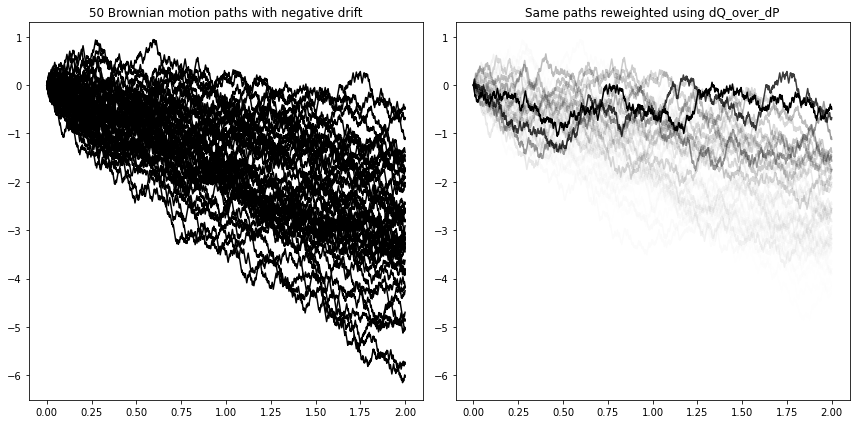

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats 

def compute_dQ_over_dP_relative_probabilities(num_steps, theta, T, db):
    n = int( num_steps / T ) # number of steps in [0, 1]
    dt = 1 / n
    exponent = np.sum( - (1/2) * theta**2 * dt - theta * db, axis=1) 
    exponent_max = max(exponent)
    exponent_rel = exponent - exponent_max  
    return np.exp(exponent_rel)

def generate_db_tilde(num_paths, num_steps, theta, T, seed=None):
    if seed is not None:
        np.random.seed(seed)
    plus_minus_one = 2 * np.random.binomial( 1, 0.5, size=(num_paths, num_steps) ) - 1
    n = int( num_steps / T ) # number of steps in [0, 1]
    db = plus_minus_one / np.sqrt(n)
    theta_dt = theta / n
    db_tilde = db + theta_dt
    return db_tilde, db, theta_dt

def generate_sample_path(num_paths, num_steps, theta, T, seed=None): 
    db_tilde, db, theta_dt = generate_db_tilde(num_paths, num_steps, theta, T, seed=seed)
    
    b_plus_drift = np.cumsum( db_tilde, axis=1 )
    b_plus_drift = np.concatenate( ( np.zeros( (num_paths, 1) ), b_plus_drift ), axis=1 ) 
    
    relative_probabilities = compute_dQ_over_dP_relative_probabilities(num_steps, theta, T, db)
    return b_plus_drift, relative_probabilities

def main():
    num_paths = 50 
    num_steps = 1_000
    theta = -1.5 
    T = 2 
    
    sample_paths, relative_probabilities = generate_sample_path(num_paths, num_steps, theta, T, 
                                                                seed=337)
    t = np.linspace( 0, T, num_steps + 1 )
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,6))
    
    ax0.set_title(f'{num_paths} Brownian motion paths with negative drift')
    for i in range(num_paths):
        ax0.plot(t, sample_paths[i], color='k')
        
    ax1.set_title(f'Same paths reweighted using dQ_over_dP')
    for i in range(num_paths):
        ax1.plot(t, sample_paths[i], color='k', alpha=relative_probabilities[i])
        
    plt.tight_layout()
    plt.show()
       
if __name__ == "__main__":
    main()

####***Section 5 Application of Change of Measure***

######***Girsanov Theorem in BS Formula***

$$
{\displaystyle
\begin{array}{lll}
C
&=&e^{-rT}\mathbb{E}^\mathbb{Q}(S_T-K)^+\\
&=&e^{-rT}\mathbb{E}^\mathbb{Q}(S_T-K)1(S_T>K)\\
&=&e^{-rT}\mathbb{E}^\mathbb{Q}S_T1(S_T>K)-Ke^{-rT}\mathbb{Q}(S_T>K)\\
&=&S_{0}N(d_{1})-Ke^{-rT}N(d_{2})
\end{array}
}
$$
where
$$
\begin{array}{lllllllll}
d_{1}
&=&\displaystyle
\frac{\log\frac{S_0}{K}+\left(r+\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}
&=&\displaystyle
\frac{\log\frac{S_0}{Ke^{-rT}}}{\sigma\sqrt{T}}+\frac{1}{2}\sigma\sqrt{T}\\
d_{2}
&=&\displaystyle
\frac{\log\frac{S_0}{K}+\left(r-\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}
&=&\displaystyle
\frac{\log\frac{S_0}{Ke^{-rT}}}{\sigma\sqrt{T}}-\frac{1}{2}\sigma\sqrt{T}\\
\end{array}
$$

***How to handle $\mathbb{Q}(S_T>K)$***

By solving $dS_t=rS_tdt+\sigma S_tdB_t^{\mathbb{Q}}$, we have

$$
\displaystyle
S_T=S_0e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma B_T^{\mathbb{Q}}}
$$

Therefore,

$$
{\displaystyle
\begin{array}{lll}
\mathbb{Q}(S_T>K)
&=&\mathbb{Q}\left(S_0e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma B_T^{\mathbb{Q}}}>K\right)\\
&=&\mathbb{Q}\left(\frac{B_T^{\mathbb{Q}}}{\sqrt{T}}\le \frac{\log\frac{S_0}{K}+\left(r-\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}\right)\\
&=&N\left(\frac{\log\frac{S_0}{K}+\left(r-\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}\right)\\
&=&N\left(d_2\right)\\
\end{array}
}
$$

***How to handle $\mathbb{E}^\mathbb{Q}S_T1(S_T>K)$***

We change the probability measure from $\mathbb{Q}$ to $\mathbb{Q}'$ so that
$B_t^{\mathbb{Q}'}=B_t^{\mathbb{Q}}-\sigma t$ is a Brownian motion under the new measure $\mathbb{Q}'$.
The corresponding Radon-Nykodym derivative $d\mathbb{Q}'/d\mathbb{Q}$ is given by

$$
\displaystyle
\frac{d\mathbb{Q}'}{d\mathbb{Q}}=e^{-\frac{1}{2}\sigma^2 T+\sigma B_T^{\mathbb{Q}}}
$$

Then,

$$
\begin{array}{lll}
\displaystyle
\mathbb{E}^\mathbb{Q}S_T1(S_T>K)
&=&\displaystyle
\mathbb{E}^\mathbb{Q}S_0e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma B_T^{\mathbb{Q}}}1(S_T>K)\\
&=&\displaystyle
S_0e^{rT}\mathbb{E}^\mathbb{Q}e^{-\frac{1}{2}\sigma^2 T+\sigma B_T^{\mathbb{Q}}}1(S_T>K)\\
&=&\displaystyle
S_0e^{rT}\mathbb{E}^\mathbb{Q}\frac{d\mathbb{Q}'}{d\mathbb{Q}}1(S_T>K)\\
&=&\displaystyle
S_0e^{rT}\mathbb{E}^\mathbb{Q'}1(S_T>K)\\
&=&\displaystyle
S_0e^{rT}\mathbb{Q'}(S_T>K)\\
&=&\displaystyle
S_0e^{rT}\mathbb{Q'}\left(S_0e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma B_T^{\mathbb{Q}}}>K\right)\\
&=&\displaystyle
S_0e^{rT}\mathbb{Q'}\left(S_0e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma (B_T^{\mathbb{Q}'}+\sigma T)}>K\right)\\
&=&\displaystyle
S_0e^{rT}\mathbb{Q'}\left(S_0e^{\left(r+\frac{1}{2}\sigma^2\right)T+\sigma B_T^{\mathbb{Q}'}}>K\right)\\
&=&\displaystyle
S_0e^{rT}N\left(\frac{\log\frac{S_0}{K}+\left(r+\frac{1}{2}\sigma^2\right)T}{\sigma\sqrt{T}}\right)\\
&=&\displaystyle
S_0e^{rT}N\left(d_1\right)\\
\end{array}
$$

###***Chapter 6 Change of Numeraire***

####***Section 1 Numeraire***

######***Numeraire***



A numeraire security $X_0$ is a security with a strictly positive price at all times $t$.

######***Numeraire Measure***



Let $X_0(t),X_1(t),\cdots,X_N(t)$, $0\le t\le T$, be traded assets.
Suppose $X_0$ is a numeraire 
and suppose there is a measure $\mathbb{P}_0$, called a numeraire measure,  such that, for each $i$,
$X_i(t)/X_0(t)$ is a $\mathbb{P}_0$-martingale: For $0\le s<t\le T$, 

$$\begin{array}{llllll}
\displaystyle
\frac{X_i(s)}{X_0(s)}=\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_i(t)}{X_0(t)}\Big{|}{\cal F}_s\right]
\end{array}$$

####***Section 2 Change of Numeraire***

######***New Numeraire***



A numeraire security $X_k$ is a security with a strictly positive price at all times $t$.

######***$Z_T=\frac{X_k(T)/X_k(0)}{X_0(T)/X_0(0)}$ is a Radon-Nykodym Derivative***





$$\begin{array}{llllll}
\displaystyle
(1)\quad \mathbb{P}_0(Z_T>0)=1\\
\displaystyle
(2)\quad \mathbb{E}^{\mathbb{P}_0}[Z_T]=1\\
\end{array}$$

***Proof***

$$\begin{array}{llllll}
\displaystyle
\frac{X_k(0)}{X_0(0)}=\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_k(T)}{X_0(T)}\right]
\quad\Rightarrow\quad
\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_k(T)/X_k(0)}{X_0(T)/X_0(0)}\right]=1
\end{array}$$

######***Filteration***



Suppose there are $\sigma$-fields ${\cal F}_{t}$ for each $0\le t\le T$ such that for $t_1<t_2$

$$\begin{array}{llllll}
\displaystyle
{\cal F}_{t_1} \subset {\cal F}_{t_2}\subset {\cal F}_{T}\subset{\cal F}
\end{array}$$

######***$Z_t=\frac{X_k(t)/X_k(0)}{X_0(t)/X_0(0)}$ is a martingale under $\mathbb{P}_0$***



***Proof***

$$\begin{array}{llllll}
\displaystyle
\frac{X_k(t)}{X_0(t)}=\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_k(T)}{X_0(T)}\big{|}{\cal F}_t\right]
\quad\Rightarrow\quad
\frac{X_k(t)/X_k(0)}{X_0(t)/X_0(0)}=\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_k(T)/X_k(0)}{X_0(T)/X_0(0)}\big{|}{\cal F}_t\right]
\quad\Rightarrow\quad
Z_t= \mathbb{E}^{\mathbb{P}_0}[Z_T|{\cal F}_t]
\end{array}$$

######***Change of Measure***

Use $Z_T$ as a Radon-Nykodym derivative.

$$\begin{array}{lll}
\displaystyle
\frac{d \mathbb{P}_k}{d\mathbb{P}_0}
=
Z_T
\end{array}$$

Define a new probability measure $\mathbb{P}_k$ using this Radon-Nykodym derivative.

$$\begin{array}{lll}
\displaystyle
\mathbb{P}_k(A)
=\int_A  d\mathbb{P}_k
=\int_A  \frac{d\mathbb{P}_k}{d\mathbb{P}_0}d\mathbb{P}_0
=\int_A  Z_Td\mathbb{P}_0
=\mathbb{E}^{\mathbb{P}_0}\left[Z_T;A\right]
\end{array}$$

Then, $\mathbb{P}_k$ is a probability measure satisfying three properties of change of measure:

$$\begin{array}{lllllllllll}
\displaystyle
\text{(1)}
&&\displaystyle Z_T>0\quad\text{a.s.}\\
\text{(2)}
&&\displaystyle E^{\mathbb{P}_0}[Z_T]=1\\
\text{(3)}
&&\displaystyle E^{\mathbb{P}_k}[X]=E^{\mathbb{P}_0}[XZ_T]
\end{array}$$

$Z_t=\mathbb{E}^{\mathbb{P}_0}\left[Z_T|{\cal F}_t\right]$ is a martingale. If $X\in{\cal F}_t$, we have further  

$$\begin{array}{lllllllllll}
\text{(4)}
&&\displaystyle E^{\mathbb{P}_k}[X]=E^\mathbb{P}[XZ_t]
\\
\text{(5)}
&&\displaystyle 
\mathbb{E}^{\mathbb{P}_0}\left[XZ_t|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}_k}\left[X|{\cal F}_s\right]Z_s
\quad\text{or}\quad
\mathbb{E}^{\mathbb{P}_k}\left[X|{\cal F}_s\right]
=\mathbb{E}^{\mathbb{P}_0}\left[XZ_t|{\cal F}_s\right]\frac{1}{Z_s}\quad\text{for $s<t$}\\
\end{array}$$

######***New Numeraire Measure***

$$\begin{array}{llllllll}
\displaystyle
\frac{X_i(s)}{X_k(s)}
=
\mathbb{E}^{\mathbb{P}_k}\left[\frac{X_i(t)}{X_k(t)}\Big{|}{\cal F}_s\right]\\
\end{array}$$

***Proof***

Since

$$\begin{array}{llllllll}
\displaystyle
\frac{X_i(s)}{X_0(s)}=\mathbb{E}^{\mathbb{P}_0}\left[\frac{X_i(t)}{X_0(t)}\Big{|}{\cal F}_s\right]
\end{array}$$

we have

$$\begin{array}{llllllll}
\displaystyle
\frac{X_i(s)}{X_k(s)}
&=&\displaystyle
\mathbb{E}^{\mathbb{P}_0}\Big{[}\frac{X_i(t)}{X_k(t)}\underbrace{
\frac{X_k(t)/X_k(0)}{X_0(t)/X_0(0)}
}_{Z_t}\Big{|}{\cal F}_s\Big{]}
\underbrace{\frac{X_0(s)/X_0(0)}{X_k(s)/X_k(0)}}_{1/Z_s}
&=&\displaystyle
\mathbb{E}^{\mathbb{P}_k}\left[\frac{X_i(t)}{X_k(t)}\Big{|}{\cal F}_s\right]\\
\end{array}$$

####***Section 3 Examples of Change of Numeraire***

######***Stock Price Dynamics***

***$dS_t$ under Different Measures***

$$\begin{array}{lll}
\displaystyle
dS_t=\mu S_tdt+\sigma S_tdW^\mathbb{P}_t&&
\displaystyle
S_t=S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W^\mathbb{P}_t}\\
\displaystyle
dS_t=r S_tdt+\sigma S_tdW^\mathbb{Q}_t&&
\displaystyle
S_t=S_0e^{\left(r-\frac{1}{2}\sigma^2\right)t+\sigma W^\mathbb{Q}_t}\\
\displaystyle
dS_t=\left(r+\sigma^2\right) S_tdt+\sigma S_tdW^S_t&&
\displaystyle
S_t=S_0e^{\left(r+\sigma^2-\frac{1}{2}\sigma^2\right)t+\sigma W^S_t}\\
\end{array}$$

***Stock Price Dynamics Under Risk Neutral Measure***

$$\begin{array}{lll}
\displaystyle
dS_t
&=&\displaystyle
\mu S_tdt+\sigma S_tdW^\mathbb{P}_t\\
&=&\displaystyle
\color{red}{r} S_tdt+\sigma S_t\left(\color{red}{dW^\mathbb{P}_t+\frac{\mu-r}{\sigma}dt}\right)\\
&=&\displaystyle
\color{red}{r} S_tdt+\sigma S_t\color{red}{dW^\mathbb{Q}_t}\\
\\
\displaystyle
S_t
&=&\displaystyle
S_0e^{\left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W^\mathbb{P}_t}\\
&=&\displaystyle
S_0e^{\left(\color{red}{r}-\frac{1}{2}\sigma^2\right)t+\sigma \left(\color{red}{W^\mathbb{P}_t+\frac{\mu-r}{\sigma}t}\right)}\\
&=&\displaystyle
S_0e^{\left(\color{red}{r}-\frac{1}{2}\sigma^2\right)t+\sigma \color{red}{W^\mathbb{Q}_t}}\\
\\
dW^\mathbb{Q}_t
&:=&\displaystyle
dW^\mathbb{P}_t+\frac{\mu-r}{\sigma}dt\\
\\
\displaystyle
\frac{d\mathbb{Q}}{d\mathbb{P}}
&=&\displaystyle
e^{-\frac{1}{2}\int_0^T\left(
\frac{\mu-r}{\sigma}
\right)^2dt-\int_0^T\left(
\frac{\mu-r}{\sigma}
\right)dW_t}
\end{array}$$

***Proof***

Since $S_t/M_t$ is a martingale under the risk neutral measure $\mathbb{Q}$,
$d(S_t/M_t)$ should have a zero drift under the new measure $\mathbb{Q}$.

$$\begin{array}{lll}
\displaystyle
d\left(\frac{S_t}{M_t}\right)
&=&\displaystyle
\frac{dS_t}{M_t}+S_td\left(\frac{1}{M_t}\right)\\
&=&\displaystyle
\frac{\mu S_tdt+\sigma S_tdW^\mathbb{P}_t}{M_t}-r\frac{S_t}{M_t}dt\\
&=&\displaystyle
\sigma \left(\frac{S_t}{M_t}\right)\left(\color{red}{
\frac{\mu-r}{\sigma}dt+dW^\mathbb{P}_t}
\right)\\
&:=&\displaystyle
\sigma \left(\frac{S_t}{M_t}\right)\color{red}{dW^\mathbb{Q}_t}
\end{array}$$

Therefore, $dW^\mathbb{Q}_t:=dW^\mathbb{P}_t+\frac{\mu-r}{\sigma}dt$
is a Brownian motion under the risk neutral measure $\mathbb{Q}$ where

$$\begin{array}{lll}
\displaystyle
\frac{d\mathbb{Q}}{d\mathbb{P}}
&=&\displaystyle
e^{-\frac{1}{2}\int_0^T\left(
\frac{\mu-r}{\sigma}
\right)^2dt-\int_0^T\left(
\frac{\mu-r}{\sigma}
\right)dW_t}
\end{array}$$

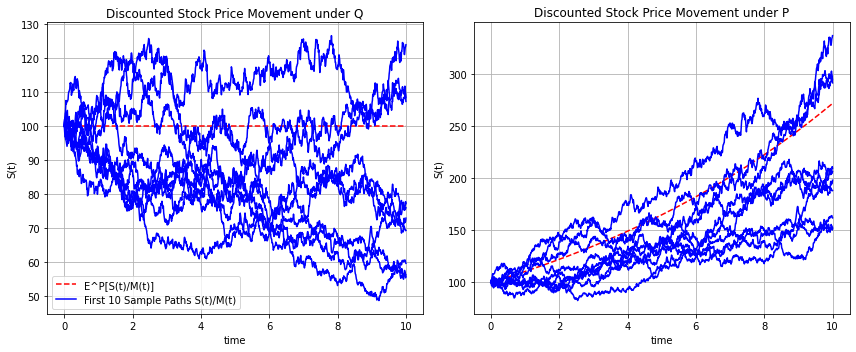

Checking Martingale Property of Q Sample Paths
Inital Stock Price                             : 100.00
Average Discounted Terminal Stock Price        :  99.84
Expectation of Discounted Terminal Stock Price : 100.00

Checking Martingale Property of P Sample Paths
Inital Stock Price                             : 100.00
Average Discounted Terminal Stock Price        : 271.39
Expectation of Discounted Terminal Stock Price : 271.83


In [ ]:
#@title Simulation of Discounted Stock Price Dynamics under Q and P
import numpy as np
import matplotlib.pyplot as plt

def generate_sample_path(num_paths, num_steps, mu, sigma, T, S_0, seed=None): 
    if seed is not None:
        np.random.seed(seed)
        
    Z = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
    X = np.ones( ( num_paths, num_steps + 1 ) ) * np.log(S_0)
    
    t = np.linspace( 0, T, num_steps + 1 )
    dt = t[1] - t[0]
    sqrt_dt = np.sqrt(dt)
    for i in range(num_steps):
        if num_paths > 1:
            Z[:,i] = ( Z[:,i] - Z[:,i].mean() ) / Z[:,i].std()
        dW = sqrt_dt * Z[:,i] 
        X[:,i+1] = X[:,i] + ( mu - sigma**2 / 2 ) * dt + sigma * dW 

    S = np.exp(X)
    return t, S

def generate_sample_path_M(num_steps, r, T): 
    t = np.linspace( 0, T, num_steps + 1 )
    M = np.exp( r * t )
    return t, M

def main():
    num_paths = 1_000
    num_steps = 1_000
    mu = 0.15
    r = 0.05
    sigma = 0.1
    T = 10
    S_0 = 100
    
    t, S_Q = generate_sample_path(num_paths, num_steps, r, sigma, T, S_0, seed=0)
    t, S_P = generate_sample_path(num_paths, num_steps, mu, sigma, T, S_0, seed=0)
    t, M = generate_sample_path_M(num_steps, r, T)
    
    S_Q_over_M = S_Q / M 
    S_P_over_M = S_P / M 

    Expected_S_Q_over_M = S_0 * np.exp( r * t ) / M  
    Expected_S_P_over_M = S_0 * np.exp( mu * t ) / M 
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,5))
    
    ax0.set_title("Discounted Stock Price Movement under Q")
    ax0.legend( ( 'E^Q[S(t)/M(t)]', 'First 10 Sample Paths S(t)/M(t)' ) )
    ax0.plot(t, Expected_S_Q_over_M, 'r--') 
    ax0.plot(t, np.transpose(S_Q_over_M[:10]), 'blue') 
    
    ax1.set_title("Discounted Stock Price Movement under P")
    ax0.legend( ( 'E^P[S(t)/M(t)]', 'First 10 Sample Paths S(t)/M(t)' ) )
    ax1.plot(t, Expected_S_P_over_M, 'r--') 
    ax1.plot(t, np.transpose(S_P_over_M[:10]), 'blue') 
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_xlabel("time")
        ax.set_ylabel("S(t)")
        
    plt.tight_layout()
    plt.show()
    
    print('Checking Martingale Property of Q Sample Paths')
    print(f'Inital Stock Price                             : {S_0:>6.02f}')
    print(f'Average Discounted Terminal Stock Price        : {np.mean(S_Q_over_M[:,-1]):>6.02f}')
    print(f'Expectation of Discounted Terminal Stock Price : {Expected_S_Q_over_M[-1]:>6.02f}')
    print()
    
    print('Checking Martingale Property of P Sample Paths')
    print(f'Inital Stock Price                             : {S_0:>6.02f}')
    print(f'Average Discounted Terminal Stock Price        : {np.mean(S_P_over_M[:,-1]):>6.02f}')
    print(f'Expectation of Discounted Terminal Stock Price : {Expected_S_P_over_M[-1]:>6.02f}')

    
if __name__ == "__main__":
    main()

***Stock Price Dynamics under Stock Measure***

$$\begin{array}{lll}
\displaystyle
dS_t
&=&\displaystyle
r S_tdt+\sigma S_tdW^\mathbb{Q}_t\\
&=&\displaystyle
\left(\color{red}{r+\sigma^2}\right) S_tdt+\sigma S_t\left(\color{red}{dW^\mathbb{Q}_t-{\sigma}dt}\right)\\
&:=&\displaystyle
\left(\color{red}{r+\sigma^2}\right) S_tdt+\sigma S_t\color{red}{dW^S_t}\\
\\
\displaystyle
S_t
&=&\displaystyle
S_0e^{\left(r-\frac{1}{2}\sigma^2\right)t+\sigma W^\mathbb{Q}_t}\\
&=&\displaystyle
S_0e^{\left(\color{red}{r+\sigma^2}-\frac{1}{2}\sigma^2\right)t+\sigma \left(\color{red}{W^\mathbb{Q}_t-\sigma t}\right)}\\
&=&\displaystyle
S_0e^{\left(\color{red}{r+\sigma^2}-\frac{1}{2}\sigma^2\right)t+\sigma \color{red}{W^S_t}}\\
\\
\displaystyle
dW^{S}_t
&:=&\displaystyle
dW^{\mathbb{Q}}_t-\sigma dt
\end{array}$$

***Proof***

$$\begin{array}{lll}
\displaystyle
d\frac{M}{S}
&=&\displaystyle
\frac{dM}{S}-\frac{M}{S^2}dS+\frac{M}{S^3}(dS)^2\\
&=&\displaystyle
\frac{M}{S}\left(rdt-\left(rdt+\sigma dW^{\mathbb{Q}}\right)+\sigma^2dt\right)\\
&=&\displaystyle
-\sigma\frac{M}{S}\left( dW^{\mathbb{Q}}_t-\sigma dt\right)\\
&:=&\displaystyle
-\sigma\frac{M}{S}dW^S\\
\end{array}$$

Therefore, $dW^S_t:=dW^\mathbb{Q}_t-\sigma dt$
is a Brownian motion under the stock measure $\mathbb{Q}^S$ where

$$
\displaystyle
\frac{d\mathbb{Q}^S}{d\mathbb{Q}}=\frac{S_T/S_0}{M_T/M_0}
=e^{-rT}e^{\left(r-\frac{1}{2}\sigma^2\right)T+\sigma W^\mathbb{Q}_T}
=e^{-\frac{1}{2}\sigma^2T+\sigma W^\mathbb{Q}_T}
$$

######***Instantaneous Forward Rate Dynamics***

***$df$ under Different Measures***

$$\begin{array}{lllllllll}
\text{Risk Neutral}&&
\displaystyle
df(t,T)
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt&+&\displaystyle\sigma(t,T)dW^{\mathbb{Q}}(t)\\
\text{$T$ Forward}&&&=&\displaystyle
&&\displaystyle\sigma(t,T)dW^{T}(t)\\
\text{$T_f$ Forward}&&&=&\displaystyle
\left(-\sigma(t,T)\int_T^{T_f}\sigma(t,T')dT'\right)dt&+&\displaystyle\sigma(t,T)dW^{T_f}(t)\\
\end{array}$$

***Proof for $T$***

$$\begin{array}{lllll}
\displaystyle
\lambda_\mathbb{Q}^T(t)
&=&\displaystyle
\displaystyle
\frac{d\mathbb{Q}^T}{d\mathbb{Q}}\Big{|}_{{\cal F}(t)}\\
&=&\displaystyle
\frac{P(t,T)/P(0,T)}{M(t)/M(0)}\\
&=&\displaystyle
\text{exp}\left(
-\int_0^tr(t')dt'
+\int_0^t\left(r(t')-\frac{1}{2}\sigma_P^2(t',T)\right)dt'+\int_0^t\sigma_P(t',T)dW^{\mathbb{Q}}(t')\right)\\
&=&\displaystyle
\text{exp}\left(
-\frac{1}{2}\int_0^t\sigma_P^2(t',T)dt'+\int_0^t\sigma_P(t',T)dW^\mathbb{Q}(t')
\right)\\
\end{array}$$

By Gilsanov Theorem,

$$\begin{array}{lllll}
\displaystyle
dW^T(t)=dW^{\mathbb{Q}}(t)-\sigma_P(t,T)dt
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\sigma_P(t,T)
=
-\int_t^T\sigma(t',T)dt'
\end{array}$$

Therefore, $df$ under $T$ is given by

$$\begin{array}{lllll}
\displaystyle
df(t,T)
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt
+\sigma(t,T)dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt
+\sigma(t,T)\left(
dW^T(t)-\left(\int_t^T\sigma(t,T')dT'\right)dt
\right)\\
&=&\displaystyle
\sigma(t,T)dW^T(t)
\end{array}$$

***Proof for $T_f$***

$$\begin{array}{lllll}
\displaystyle
\lambda_\mathbb{Q}^{T_f}(t)
=
\frac{d\mathbb{Q}^{T_f}}{d\mathbb{Q}}\Big{|}_{{\cal F}(t)}
=
\frac{P(t,T_f)/P(t_0,T_f)}{M(t)/M(t_0)}
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
d\lambda_\mathbb{Q}^{T_f}(t)
&=&\displaystyle
\frac{M(t_0)}{P(t_0,T_f)}d\left(\frac{P(t,T_f)}{M(t)}\right)\\
&=&\displaystyle
\frac{M(t_0)}{P(t_0,T_f)}
\left[\frac{dP(t,T_f)}{M(t)}-\frac{P(t,T_f)}{M^2(t)}dM(t)\right]\\
&=&\displaystyle
\frac{M(t_0)}{P(t_0,T_f)}
\left[\frac{P(t,T_f)}{M(t)}\frac{dP(t,T_f)}{P(t,T_f)}-\frac{P(t,T_f)}{M^2(t)}dM(t)\right]\\
&=&\displaystyle
\frac{M(t_0)}{P(t_0,T_f)}
\left[\frac{P(t,T_f)}{M(t)}
\left(r(t)dt+\sigma_P(t,T_f)dW^{\mathbb{Q}}(t)\right)-\frac{P(t,T_f)}{M^2(t)}\left(r(t)M(t)dt\right)\right]\\
&=&\displaystyle
\frac{M(t_0)}{P(t_0,T_f)}
\left[\frac{P(t,T_f)}{M(t)}
\left(\sigma_P(t,T_f)dW^{\mathbb{Q}}(t)\right)\right]\\
&=&\displaystyle
\lambda_\mathbb{Q}^{T_f}(t)
\left(\sigma_P(t,T_f)dW^{\mathbb{Q}}(t)\right)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\frac{d\lambda_\mathbb{Q}^{T_f}(t)}{\lambda_\mathbb{Q}^{T_f}(t)}
=
\sigma_P(t,T_f)dW^{\mathbb{Q}}(t)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
dW^{T_f}(t)
=
-\sigma_P(t,T_f)dt
+dW^\mathbb{Q}(t)
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\sigma_P(t,T_f)
=
-\int_t^{T_f}\sigma(t,T')dT'
\end{array}$$

$$\begin{array}{lll}
\displaystyle
df(t,T)
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt+\sigma(t,T)
\left(dW^{T_f}(t)-\left(\int_t^{T_f}\sigma(t,T')dT'\right)dt\right)\\
&=&\displaystyle
\left(-\sigma(t,T)\int_T^{T_f}\sigma(t,T')dT'\right)dt+\sigma(t,T)dW^{T_f}(t)
\end{array}$$

####***Section 4 Valuation using Change of Numeraire***



######***Valuation using Numeraire***



$$\begin{array}{lll}
\displaystyle
\frac{V_0}{X_0}&=&
\displaystyle\mathbb{E}^X\left[\frac{V_T}{X_T}\right]
\end{array}$$

######***Three Important Numeraire***



Money Account and Risk-Neutral Measure

$$\begin{array}{llllll}
\displaystyle
\mathbb{E}^{\mathbb{Q}}\left[\frac{X(t)}{M(t)}\Big{|}{\cal F}_s\right]=\frac{X(s)}{M(s)}
\end{array}$$

ZCB $P(t,T)$ and Forward Measure

$$\begin{array}{llllll}
\displaystyle
\mathbb{E}^{T}\left[\frac{X(t)}{P(t,T)}\Big{|}{\cal F}_s\right]=\frac{X(s)}{P(s,T)}
\end{array}$$

Stock and Stock Measure

$$\begin{array}{llllll}
\displaystyle
\mathbb{E}^{S}\left[\frac{X(t)}{S(t)}\Big{|}{\cal F}_s\right]=\frac{X(s)}{S(s)}
\end{array}$$

######***Example 1***



$$\begin{array}{lll}
\displaystyle
V_0
&=&\displaystyle
\mathbb{E}^\mathbb{Q}\left[\frac{1}{M(T)}\max\left(S^2(T)-S(T)K,0\right)\right]
\\
&=&\displaystyle
\int\frac{1}{M(T)}\max\left(S^2(T)-S(T)K,0\right)d\mathbb{Q}\\
&=&\displaystyle
\int\frac{1}{M(T)}\max\left(S^2(T)-S(T)K,0\right)\frac{d\mathbb{Q}}{d\mathbb{Q}^S}d\mathbb{Q}^S\\
&=&\displaystyle
\int\frac{1}{M(T)}\max\left(S^2(T)-S(T)K,0\right)\frac{M(T)/M(0)}{S(T)/S(0)}d\mathbb{Q}^S\\
&=&\displaystyle
S(0)\int\max\left(S(T)-K,0\right)d\mathbb{Q}^S
\end{array}$$

Under $\mathbb{Q}^S$ we have

$$\begin{array}{lll}
\displaystyle
dS_t=\left(\color{red}{r+\sigma^2}\right) S_tdt+\sigma S_tdW^\color{red}{S}_t&&
\displaystyle
S_t=S_0e^{\left(\color{red}{r+\sigma^2}-\frac{1}{2}\sigma^2\right)t+\sigma W^S_t}=S_0e^{\left(r+\frac{1}{2}\sigma^2\right)t+\sigma W^S_t}\\
\end{array}$$

The stock moves as if the risk-free interest rate is $r+\sigma^2$, not $r$.
So,

$$\begin{array}{lll}
\displaystyle
V_0
&=&\displaystyle
S(0)\int\max\left(S(T)-K,0\right)d\mathbb{Q}^S\\
&=&\displaystyle
S(0)e^{(\color{red}{r+\sigma^2})T}\left[e^{-(\color{red}{r+\sigma^2})T}\int\max\left(S(T)-K,0\right)d\mathbb{Q}^S\right]\\
&=&\displaystyle
S(0)e^{(\color{red}{r+\sigma^2})T}\left(S_0N(d_1)-Ke^{-(\color{red}{r+\sigma^2})T}N(d_2)\right)\\
\end{array}$$

where

$$\begin{array}{lll}
\displaystyle
d_1
&=&\displaystyle
\frac{\log\frac{S_0}{Ke^{-(\color{red}{r+\sigma^2})T}}}{\sigma\sqrt{T}}
+\frac{1}{2}\sigma\sqrt{T}
\\
d_2&=&\displaystyle
\frac{\log\frac{S_0}{Ke^{-(\color{red}{r+\sigma^2})T}}}{\sigma\sqrt{T}}
-\frac{1}{2}\sigma\sqrt{T}
\end{array}$$

######***Example 2***



$$\begin{array}{lll}
\displaystyle
dS_1(t)
&=&\displaystyle
rS_1(t)dt+\sigma_1S_1(t)dW_1^\mathbb{Q}(t)
\\
\displaystyle
dS_2(t)
&=&\displaystyle
rS_2(t)dt+\sigma_2S_2(t)dW_2^\mathbb{Q}(t)\\
\displaystyle
dW_1^\mathbb{Q}(t)dW_2^\mathbb{Q}(t)
&=&\displaystyle
\rho dt\\
\end{array}$$

Since $dW_1^{S_1}(t)=dW_1^\mathbb{Q}(t)-\sigma_1dt$ under $\mathbb{Q}^{S_1}$, 
and since $S_2(t)/S_1(t)$ is a $\mathbb{Q}^{S_1}$ martingale, 
we have

$$\begin{array}{lll}
\displaystyle
d\left(\frac{S_2(t)}{S_1(t)}\right)\Big{/}\left(\frac{S_2(t)}{S_1(t)}\right)
&=&\displaystyle
\left(\sigma_1^2-\rho\sigma_1\sigma_2\right)dt
+\sigma_2dW_2^{\mathbb{Q}}(t)-\sigma_1dW_1^{\mathbb{Q}}(t)
\\
&=&\displaystyle
\displaystyle
-\rho\sigma_1\sigma_2dt
+\sigma_2dW_2^{\mathbb{Q}}(t)-\sigma_1dW_1^{S_1}(t)\\
\displaystyle
&=&\displaystyle
\sigma_2\left(\color{red}{dW_2^{\mathbb{Q}}(t)-\rho\sigma_1dt}\right)-\sigma_1dW_1^{S_1}(t)\\
&=&\displaystyle
\sigma_2 \color{red}{dW_2^{S_1}(t)}-\sigma_1dW_1^{S_1}(t)\\
\end{array}$$

or

$$\begin{array}{lll}
\displaystyle
dW_1^{S_1}(t)
&=&\displaystyle
dW_1^\mathbb{Q}(t)-\sigma_1dt
\\
\displaystyle
dW_2^{S_1}(t)
&=&\displaystyle
dW_2^\mathbb{Q}(t)-\rho\sigma_1dt\\
\displaystyle
dW_1^{S_1}(t)dW_2^{S_1}(t)
&=&\displaystyle
\rho dt\\
\end{array}$$

or

$$\begin{array}{lll}
\displaystyle
dS_1(t)
&=&\displaystyle
\left(r+\sigma_1^2\right)S_1(t)dt+\sigma_1S_1(t)dW_1^{S_1}(t)
\\
\displaystyle
dS_2(t)
&=&\displaystyle
\left(r+\rho\sigma_1\sigma_2\right)S_2(t)dt+\sigma_2S_2(t)dW_2^{S_1}(t)\\
\displaystyle
dW_1^{S_1}(t)dW_2^{S_1}(t)
&=&\displaystyle
\rho dt\\
\end{array}$$

Since $\displaystyle
S_2(T)=S_2(0)\text{exp}\left[\left(\left(r+\rho\sigma_1\sigma_2\right)-\frac{1}{2}\sigma_2^2\right)T+\sigma_2 W_2^{S_1}(T)\right]$,

$$\begin{array}{lll}
\displaystyle
V_0
&=&\displaystyle
M(0)\mathbb{E}^\mathbb{Q}\left[\frac{1}{M(T)}S_1(T)1_{S_2(T)>K}\right]
\\
&=&\displaystyle
M(0)\int\frac{1}{M(T)}S_1(T)1_{S_2(T)>K}d\mathbb{Q}\\
&=&\displaystyle
M(0)\int\frac{1}{M(T)}S_1(T)1_{S_2(T)>K}\frac{d\mathbb{Q}}{d\mathbb{Q}^{S_1}}d\mathbb{Q}^{S_1}\\
&=&\displaystyle
M(0)\int\frac{1}{M(T)}S_1(T)1_{S_2(T)>K}\frac{M(T)/M(0)}{S_1(T)/S_1(0)}d\mathbb{Q}^{S_1}\\
&=&\displaystyle
S_1(0)\int 1_{S_2(T)>K}d\mathbb{P}^{S_1}\\
&=&\displaystyle
S_1(0)\mathbb{P}^{S_1}\left[S_2(T)>K\right]\\
&=&\displaystyle
S_1(0)\mathbb{P}^{S_1}\left[S_2(0)\text{exp}\left[\left(\left(r+\rho\sigma_1\sigma_2\right)-\frac{1}{2}\sigma_2^2\right)T+\sigma_2 W_2^{S_1}(T)\right]>K\right]\\
&=&\displaystyle
S_1(0)\left[1-N\left(\frac{
\log\frac{S_2(0)}{K}
+\left(\left(r+\rho\sigma_1\sigma_2\right)-\frac{1}{2}\sigma_2^2\right)T
}{\sigma_2\sqrt{T}}\right)\right]\\
\end{array}$$

####***Section 5 Forward Rate Agreement***

#####***Forward Rate Agreement (FRA)***

$$\begin{array}{lllllllllllllll}
&&\text{Time}&&\text{Action}&&\text{Value}\\
\text{Now}&&t&&\text{Enter FRA with Fixed Rate $K$ and Principle $N$}&&{\bf\text{FRA}}(t,T_{k-1},T_k,N,K)=N\tau_k\left(l_k(t)-K\right) P(t,T_k)\\
\text{Expiry}&&T_{k-1} > t&&\text{Observe Float Rate}\ l_k(T_{k-1})&&\displaystyle \frac{N\tau_k(l_k(T_{k-1})-K)}{1+\tau_kl_k(T_{k-1})}=N\tau_k\left(l_k(T_{k-1})-K\right)P(T_{k-1},T_k)\\
\text{Maturity}&&T_k > T_{k-1} > t&&\text{Exchange Fixed and Float Interest on Principle}&&N\tau_k(l_k(T_{k-1})-K)\\
\end{array}$$

where

$$\begin{array}{lll}
\tau_k&=&\tau(T_{k-1},T_k)\\
l_k(t)&=&\displaystyle\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_k)}-1\right)\\
\end{array}$$


#####***Libor Rate $l_k(t)$ is a $\mathbb{T_k}$-martingale***

With tenor $\tau_k=T_k-T_{k-1}$

$$\begin{array}{lll}
\displaystyle
l_k(t)=l(t;T_{k-1},T_k)=\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_k)}-1\right)
=\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}\right)
\end{array}$$

is a $\mathbb{T_k}$-martingale.

######***Proof***



$$\begin{array}{lll}
\displaystyle
\mathbb{E}^\mathbb{T_k}\left[l\left(T_{k-1};T_{k-1},T_k\right)|{\cal F}(t)\right]
&=&\displaystyle
\frac{1}{\tau_k}\mathbb{E}^\mathbb{T_k}\left[\frac{P(T_{k-1},T_{k-1})-P(T_{k-1},T_k)}{P(T_{k-1},T_k)}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
\frac{1}{\tau_k}\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}\\
&=&\displaystyle
l\left(t;T_{k-1},T_k\right)\\
\end{array}$$

#####***Another Valuation of FRA using Change of Numeraire***

$$\begin{array}{lll}
\displaystyle
{\bf\text{FRA}}(t,T_{k-1},T_k,N,K)=N\tau_k\left(l_k(t)-K\right) P(t,T_k)\\
\end{array}$$

So, the fair value $K$, which makes $V(t)=0$, is given by

$$\begin{array}{lll}
\displaystyle
K=l_k(t)=l(t,T_{k-1},T_k)
\end{array}$$

######***Proof***

Since $l_k(t)=\frac{1}{\tau_k}(\frac{P(t,T_{k-1})}{P(t,T_k)}-1)$,
we have

$$
\displaystyle
\frac{1}{1+\tau_k l_k(T_{k-1})}= P(T_{k-1},T_k)
$$

Therefore,

$$\begin{array}{lll}
\displaystyle
{\bf\text{FRA}}(t,T_{k-1},T_k,N,K)
&=&\displaystyle
NM(t)
\mathbb{E^\mathbb{Q}}\left[\frac{\frac{\tau_k(l(T_{k-1};T_{k-1},T_k)-K)}{1+\tau_kl(T_{k-1};T_{k-1},T_k)}}{M(T_{k-1})}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
NM(t)
\mathbb{E^\mathbb{Q}}\left[\frac{P(T_{k-1},T_k)\tau_k(l(T_{k-1};T_{k-1},T_k)-K)}{M(T_{k-1})}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
NM(t)
\mathbb{E}^{\mathbb{Q}}\left[\frac{P(T_{k-1},T_k)\tau_k\left(\frac{1}{\tau_k}\left(\frac{P(T_{k-1},T_{k-1})}{P(T_{k-1},T_k)}-1\right)-K\right)}{M(T_{k-1})}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
NM(t)
\mathbb{E^\mathbb{Q}}\left[\frac{\left(P(T_{k-1},T_{k-1})-P(T_{k-1},T_k)\right)-K\tau_k P(T_{k-1},T_k)}{M(T_{k-1})}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
NM(t)
\frac{\left(P(t,T_{k-1})-P(t,T_k)\right)-K\tau_k P(t,T_k)}{M(t)}\\
&=&\displaystyle
\left(\frac{1}{\tau_k}\left(\frac{P(t,T_{k-1})}{P(t,T_k)}-1\right)-K\right)\tau_k P(t,T_k)\\
&=&\displaystyle
N\tau_k \left(l_k(t)-K\right)P(t,T_k)\\
\end{array}$$

###***Chapter 7 Hull-White***

####***Section 1 Hull-White Named Functions***

#####***$\tau$***

$$\tau=T-t$$

#####***$\theta$***

$$\begin{array}{lllllll}
\displaystyle
\theta(t)
&=&\displaystyle
f(0,t)+\frac{1}{\lambda}\frac{\partial f(0,t)}{\partial t}
+
\frac{\sigma^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right)\\
\displaystyle
\theta^\mathbb{T}(t)
&=&\displaystyle\theta(t)+\frac{\sigma^2}{\lambda}B(T-t)\\
\end{array}$$

#####***$\psi$***

$$\begin{array}{lllllll}
\psi(t)
&=&\displaystyle
r(0)e^{-\lambda t}+\lambda\int_0^t\theta(t')e^{-\lambda(t-t')}dt'
&=&\displaystyle
f(0,t)+\frac{\lambda\sigma^2}{2}B^2(t)\\
\psi(t_0,t)
&=&\displaystyle
r(t_0)e^{-\lambda (t-t_0)}+\lambda\int_{t_0}^t\theta(t')e^{-\lambda(t-t')}dt'
\\
\psi^\mathbb{T}(t_0,t)
&=&\displaystyle
r(t_0)e^{-\lambda (t-t_0)}+\lambda\int_{t_0}^t\theta^\mathbb{T}(t')e^{-\lambda(t-t')}dt'
\\
\end{array}$$

#####***$\sigma_r^2$, $\mu_r$***

$$\begin{array}{lllll}
\displaystyle
\sigma_r^2(t)
&=&\displaystyle
-\frac{1}{2}\sigma^2 B(2t)\\
\displaystyle
\sigma_r^2(t_0,t)
&=&\displaystyle
-\frac{1}{2}\sigma^2 B(2(t-t_0))
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\mu_r(t)
&=&\displaystyle
\psi(t)\\
\displaystyle
\mu_r(t_0,t)
&=&\displaystyle
\psi(t_0,t)\\
\displaystyle
\mu^\mathbb{T}_r(t_0,t)
&=&\displaystyle
\psi^\mathbb{T}(t_0,t)\\
\end{array}$$

#####***$A$, $B$***



$$\begin{array}{lllllll}
A(\tau)&=&A(0,\tau)
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}
\left(3-2\lambda\tau-4e^{-\lambda\tau}+e^{-2\lambda\tau}\right)
+
\lambda\int_0^\tau\theta(T-\tau')B(\tau')d\tau'
\\
B(\tau)&=&B(0,\tau)
&=&\displaystyle
-\frac{1-e^{-\lambda\tau}}{\lambda}
\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
A(u,\tau)
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}\left[(1+iu\lambda)\left[
    3-4e^{-\lambda \tau}+e^{-2\lambda \tau}
    - iu\lambda\left(1-e^{-2\lambda \tau}\right)
    \right]-2\lambda\tau\right]
+\lambda\int_0^\tau\theta(T-\tau')B(u,\tau')d\tau'\\
\displaystyle
B(u,\tau)
&=&\displaystyle
-\frac{1-(1+iu\lambda) e^{-\lambda \tau}}{\lambda}
=iue^{-\lambda\tau}+B(\tau)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\tilde{A}(u,\tau)
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}\left(3-2\lambda\tau-4e^{-\lambda\tau}+e^{-2\lambda\tau}+2iu\lambda\left(1-e^{-\lambda\tau}\right)^2+u^2\lambda^2\left(1-e^{-2\lambda\tau}\right)\right)
\\
\displaystyle
\tilde{B}(u,\tau)
&=&\displaystyle
B(u,\tau)\\
\end{array}$$





####***Section 2 Instantaneous Forward Rate***

#####***Hull-White Volatility of Instantaneous Forward Rate Dynamics***

$$\begin{array}{lllll}
\displaystyle
\sigma(t,T)=\sigma e^{-\lambda(T-t)}
\end{array}$$

#####***Hull-White Instantaneous Forward Rate Dynamics***

$$\begin{array}{lllll}
\displaystyle
df(t,T)
=
\mu^\mathbb{Q}(t,T)dt+\sigma(t,T)dW^{\mathbb{Q}}(t)
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\mu^\mathbb{Q}(t,T)
=\frac{\sigma^2}{\lambda}e^{-\lambda(T-t)}\left(1-e^{-\lambda(T-t)}\right)
\end{array}$$

######***Proof***

$$\begin{array}{lllll}
\displaystyle
\mu(t,T)
=\sigma(t,T)\int_t^T\sigma(t,T')dT'
=\frac{\sigma^2}{\lambda}e^{-\lambda(T-t)}\left(1-e^{-\lambda(T-t)}\right)
\end{array}$$

####***Section 3 Short Rate***

#####***Hull-White Model***

$$\begin{array}{lllll}
\displaystyle
dr(t)=\lambda\left(\theta^\mathbb{Q}(t)-r(t)\right) dt+\sigma dW^{\mathbb{Q}}(t)
\end{array}$$

where

$$
\displaystyle
\theta^\mathbb{Q}(t)
=
f^M(0,t)
+\frac{1}{\lambda}\frac{\partial f^M(0,t)}{\partial t}
+\frac{\sigma^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right)
$$

######***Proof***



$$\begin{array}{lllll}
\displaystyle
\sigma(t)=\sigma(t,t)=\sigma
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\mu(t)
&=&\displaystyle
\mu(t,t)+
\frac{\partial f(0,t)}{\partial t}
+\int_0^t\frac{\partial \mu(t',t)}{\partial t}dt'
+\int_0^t\frac{\partial \sigma(t',t)}{\partial t}dW^{\mathbb{Q}}(t')\\
&=&\displaystyle
\frac{\partial f(0,t)}{\partial t}
+\int_0^t\left[2\sigma^2e^{-2\lambda(t-t')}
-\sigma^2e^{-\lambda(t-t')}\right]dt'
-\lambda \int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')\\
&=&\displaystyle
\frac{\partial f(0,t)}{\partial t}
+\frac{\sigma^2}{\lambda}e^{-2\lambda t}\left(e^{\lambda t}-1\right)-\lambda \int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')\\
\end{array}$$

***How to handle the stochastic integral term***

$$\begin{array}{l}
\displaystyle
r(t)
=
f(t,t)
=
f(0,t)+\int_0^t\mu(t',t)dt'+\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
\end{array}$$

implies

$$\begin{array}{llllllll}
\displaystyle
\int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')
&=&\displaystyle
r(t)-f(0,t)-\int_0^t\mu(t',t)dt'\\
&=&\displaystyle
r(t)-f(0,t)-\int_0^t\frac{\sigma^2}{\lambda}e^{-\lambda(t-s)}\left(1-e^{-\lambda(t-s)}\right)ds\\
&=&\displaystyle
r(t)-f(0,t)-\frac{\sigma^2}{2\lambda^2}e^{-2\lambda t}\left(e^{\lambda t}-1\right)^2
\end{array}$$

***Proof continue***

$$\begin{array}{lllll}
\displaystyle
\mu(t)
&=&\displaystyle
\frac{\partial f(0,t)}{\partial t}
+\frac{\sigma^2}{\lambda}e^{-2\lambda t}\left(e^{\lambda t}-1\right)-\lambda \int_0^t\sigma(t',t)dW^{\mathbb{Q}}(t')\\
&=&\displaystyle
\frac{\partial f(0,t)}{\partial t}
+\frac{\sigma^2}{\lambda}e^{-2\lambda t}\left(e^{\lambda t}-1\right)-\lambda 
\left[r(t)-f(0,t)-\frac{\sigma^2}{2\lambda^2}e^{-2\lambda t}\left(e^{\lambda t}-1\right)^2\right]\\
&=&\displaystyle
\lambda\left(
f(0,t)
+\frac{1}{\lambda}\frac{\partial f(0,t)}{\partial t}
+\frac{\sigma^2}{2\lambda^2}\left(1-e^{-2\lambda t}\right)
-r(t)
\right)\\
&:=&\displaystyle
\lambda\left(
\theta(t)
-r(t)
\right)\\
\end{array}$$

#####***Hull-White Model Solution***

$$\begin{array}{lllll}
\displaystyle
r(t)
&=&\displaystyle
r(s)e^{-\lambda (t-s)}+ \lambda\int_{s}^t\theta^\mathbb{Q}(t')e^{-\lambda (t-t')} dt'+\sigma \int_{s}^t e^{-\lambda (t-t')} dW^{\mathbb{Q}}(t')\\
&=&\displaystyle
r(s)e^{-\lambda (t-s)}+ \alpha(t)-\alpha(s)e^{-\lambda(t-s)}+\sigma \int_{s}^t e^{-\lambda (t-t')} dW^{\mathbb{Q}}(t')\\
\end{array}$$

where

$$
\displaystyle
\alpha(t)=f^M(0,t)+\frac{\sigma^2}{2\lambda^2}\left(1-e^{-\lambda t}\right)^2
$$

Therefore, $r(t)$ conditional on ${\cal F}(s)$ is normally distributed with mean and variance given respectively by

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
r(s)e^{-\lambda (t-s)}+ \lambda\int_{s}^t\theta^\mathbb{Q}(t')e^{-\lambda (t-t')} dt'\\
&=&\displaystyle
r(s)e^{-\lambda (t-s)}+ \alpha(t)-\alpha(s)e^{-\lambda(t-s)}\\
\mathbb{Var}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
\frac{\sigma^2}{2\lambda}\left(1-e^{-2\lambda(t-s)}\right)
\end{array}$$

######***Proof***

$$\begin{array}{lllll}
\displaystyle
&&dr(t)=\lambda\left(\theta(t)-r(t)\right) dt+\sigma dW^{\mathbb{Q}}(t)\\
\\
&\Rightarrow&
\displaystyle
dr(t) + \lambda r(t)  dt=\lambda\theta(t)  dt+\sigma  dW^{\mathbb{Q}}(t)\\
\\
&\Rightarrow&
\displaystyle
e^{\lambda t}dr(t) + \lambda r(t)e^{\lambda t}  dt=\lambda\theta(t)e^{\lambda t}  dt+\sigma e^{\lambda t} dW^{\mathbb{Q}}(t)\quad(y(t)=r(t)e^{\lambda t})\\
\\
&\Rightarrow&
\displaystyle
dy(t)=e^{\lambda t}dr(t) + \lambda r(t)e^{\lambda t}  dt=\lambda\theta(t)e^{\lambda t} dt+\sigma e^{\lambda t} dW^{\mathbb{Q}}(t)\\
\\
&\Rightarrow&
\displaystyle
dy(t)=\lambda\theta(t)e^{\lambda t} dt+\sigma e^{\lambda t} dW^{\mathbb{Q}}(t)\\
\\
&\Rightarrow&
\displaystyle
y(t)-y(0)
=
\lambda\int_0^t\theta(t')e^{\lambda t'} dt'+\sigma \int_0^t e^{\lambda t'} dW^{\mathbb{Q}}(t')\\
\\
&\Rightarrow&
\displaystyle
r(t)e^{\lambda t}-r(0)
=
\lambda\int_0^t\theta(t')e^{\lambda t'} dt'+\sigma \int_0^t e^{\lambda t'} dW^{\mathbb{Q}}(t')\\
\\
&\Rightarrow&
\displaystyle
r(t)
=
r(0)e^{-\lambda t}+ \lambda\int_0^t\theta(t')e^{-\lambda (t-t')} dt'+\sigma \int_0^t e^{-\lambda (t-t')} dW^{\mathbb{Q}}(t')\\
\end{array}$$

Therefore,

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}^\mathbb{Q}\left(r(t)\big|{\cal F}(0)\right)
=
r(0)e^{-\lambda t}+ \lambda\int_0^t\theta(t')e^{-\lambda (t-t')} dt'
=
\psi(t)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\mathbb{Var}^\mathbb{Q}\left(r(t)\big|{\cal F}(0)\right)
=
\sigma^2 \int_0^t e^{-2\lambda (t-t')} dt'
=
\frac{\sigma^2}{2\lambda} \left(1-e^{-2\lambda t}\right)
=-\frac{1}{2}\sigma^2 B(2t)
\end{array}$$

#####***Hull-White Short Rate Sample Path***

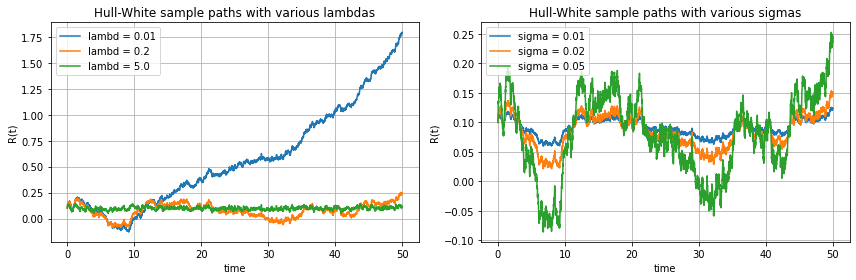

In [ ]:
# Source
# https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/blob/main/Lecture%2003-The%20HJM%20Framework/Materials/Hull-White-ZCBs.py
# input  : ZCB curve from the market
# output : Hull-White short rate sample path 
import matplotlib.pyplot as plt


def main():
    num_paths = 1
    num_steps = 5_000 
    T = 50
    
    # ZCB curve from the market
    P = lambda T: np.exp(-0.1*T) 
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))

    ax0.set_title("Hull-White sample paths with various lambdas")
    sigma = 0.05
    lambds = [0.01, 0.2, 5.0]
    for lambd in lambds:
        hw = HullWhite(sigma, lambd, P)
        t, R, _ = hw.generate_sample_paths(num_paths, num_steps, T, seed=0)
        ax0.plot(t, np.transpose(R), label=f'{lambd = }')      
  
    ax1.set_title("Hull-White sample paths with various sigmas")
    sigmas = [0.01, 0.02, 0.05]
    lambd = 0.2
    for sigma in sigmas:
        hw = HullWhite(sigma, lambd, P)
        t, R, _ = hw.generate_sample_paths(num_paths, num_steps, T, seed=0)
        ax1.plot(t, np.transpose(R), label=f'{sigma = }') 
        
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_xlabel("time")
        ax.set_ylabel("R(t)")
        ax.legend(loc="upper left")
        
    plt.tight_layout()
    plt.show()
        
if __name__ == "__main__":
    main()

####***Section 4 ZB***

#####***Hull-White ZB Dynamics***

$$\begin{array}{lllll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
=
r(t)dt+\sigma_P(t,T)dW^{\mathbb{Q}}_t
\end{array}$$

where

$$\begin{array}{lllll}
\displaystyle
\sigma_P(t,T)
=
-\frac{\sigma}{\lambda} 
\left(1-e^{-\lambda(T-t)}\right)
\end{array}$$

#####***ZB***

$$
\displaystyle
P(t,T)=A(t,T)e^{-B(t,T)r(t)}
$$

where

$$\begin{array}{lllll}
\displaystyle
A(t,T)
&=&\displaystyle
\frac{P^M(0,T)}{P^M(0,t)}
\text{exp}\left\{B(t,T)f^M(0,t)-\frac{\sigma^2}{4\lambda}B(t,T)^2\right\}
\\
\displaystyle
B(t,T)
&=&\displaystyle
\frac{1}{\lambda}\left[1-e^{-\lambda(T-t)}\right]
\end{array}$$


######***Proof (Expectation)***

$$
\displaystyle
\int_t^Tr(t')dt'\Big|{\cal F}(t)
\sim{\cal N}\left(
    B(t,T)[r(t)-\alpha(t)]+\log\frac{P^M(0,t)}{P^M(0,T)}+\frac{1}{2}[V(0,T)-V(0,t)],
    V(t,T)
\right)
$$

where

$$\begin{array}{lllll}
\displaystyle
V(t,T)
&=&\displaystyle
\frac{\sigma^2}{\lambda^2}\left[T-t+\frac{2}{\lambda}e^{-\lambda(T-t)}-\frac{1}{2\lambda}e^{-2\lambda(T-t)}-\frac{3}{2\lambda}\right]
\end{array}$$

######***Proof (PDE)***



Since the Hull-White short rate dynamics is

$$\begin{array}{lllll}
\displaystyle
dr=\lambda\left(\theta(t)-r\right) dt+\sigma dW^{\mathbb{Q}}(t)
\end{array}$$

the ZCB PDE becomes

$$
\displaystyle
\frac{\partial P}{\partial t}
+\lambda\left(\theta(t)-r\right)\frac{\partial P}{\partial r}+\frac{1}{2}\sigma^2\frac{\partial^2 P}{\partial r^2}=rP
$$

We look for the ZCB PDE solution of the form

$$
\displaystyle
P(t,T)=e^{A(\tau)+B(\tau)r(t)}
$$

where $\tau=T-t$. 
Plugging $P(t,T)=e^{A(\tau)+B(\tau)r(t)}$ into the ZCB PDE, we have

$$
\displaystyle
\left(-A'-B'r\right)+\lambda\left(\theta^\mathbb{Q}(t)-r\right)B
+\frac{1}{2}\sigma^2 B^2=r 
$$

with $A(0)=B(0)=0$.
Setting the coefficent of the $r$ term to be zero, we have

$$-B'-\lambda B =1$$

Solving this with the initial condition $B(0)=0$ is easy and the solution is

$$
\displaystyle
B(\tau)=-\frac{1-e^{-\lambda\tau}}{\lambda}
$$

Setting all the other terms to be zero, we have with $A(0)=0$

$$
\displaystyle
-A'+\lambda\theta(t)B
+\frac{1}{2}\sigma^2 B^2=0
$$

Here we simply check

$$
A(\tau)
=\displaystyle
-\frac{\sigma^2}{4\lambda^3}
\left(3-2\lambda\tau-4e^{-\lambda\tau}+e^{-2\lambda\tau}\right)
+
\lambda\int_0^\tau\theta(T-\tau')B(\tau')d\tau'
$$

satisfies the ODE ($A(0)=0$ is obvious):

$$\begin{array}{lll}
\displaystyle
A'
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}
\left(-2\lambda+4\lambda e^{-\lambda\tau}-2\lambda e^{-2\lambda\tau}\right)
+
\lambda \theta(T-\tau)B\\
&=&\displaystyle
\frac{\sigma^2}{2\lambda^2}
\left(1 -2 e^{-\lambda\tau}+e^{-2\lambda\tau}\right)
+
\lambda \theta(t)B\\
&=&\displaystyle
\frac{\sigma^2}{2}
\left(\frac{1-e^{-\lambda\tau}}{\lambda}\right)^2
+
\lambda \theta(t)B\\
&=&\displaystyle
\frac{1}{2}
\sigma^2B^2
+
\lambda \theta(t)B\\
\end{array}$$

#####***Hull-White Model recovers Market ZB Curve***

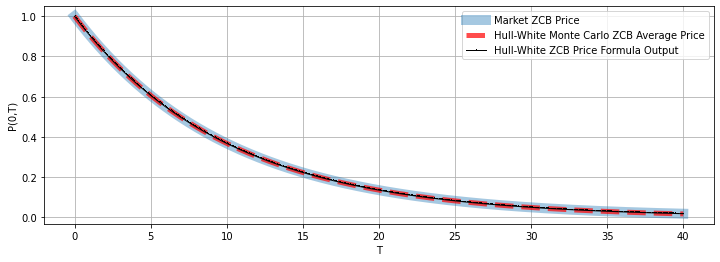

In [ ]:
# Source 
# https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/blob/main/Lecture%2004-Yield%20Curve%20Dynamics%20under%20Short%20Rate/Materials/Hull-White-ZCBs2.py
# input  : Market ZCB Curve
# output : Hull-White Monte Carlo and ZCB Pricing Formula Output
import matplotlib.pyplot as plt


def main():
    num_paths = 25000
    num_steps = 500 
    sigma = 0.02
    lambd = 0.02
    T = 40
    
    # Market ZCB Curve
    P = lambda T: np.exp(-0.1*T) 
    
    hw = HullWhite(sigma, lambd, P)
    t, R, M = hw.generate_sample_paths(num_paths, num_steps, T, seed=0)
    
    # Hull-White Monte Carlo Output
    P_MC = np.zeros( ( num_steps + 1, ) ) 
    for i in range( num_steps + 1 ):
        P_MC[i] = np.mean(1.0/M[:,i])
    
    # Hull-White ZCB Pricing Formula Output
    r0 = R[0,0]
    P_DPS = np.zeros( ( num_steps + 1, ) ) 
    for i in range( num_steps + 1 ):
        P_DPS[i] = hw.compute_ZCB(t=0, T=t[i], r_t=r0)  
   
    fig, ax = plt.subplots(1,1,figsize=(12,4))
    ax.plot(t, P(t), label='Market ZCB Price', linewidth=10, alpha=0.4)
    ax.plot(t, P_MC, '--r', label='Hull-White Monte Carlo ZCB Average Price', linewidth=5, alpha=0.7)
    ax.plot(t, P_DPS, '-,k', label='Hull-White ZCB Price Formula Output', linewidth=1)
    ax.set_xlabel('T')
    ax.set_ylabel('P(0,T)')
    ax.legend()
    ax.grid()
    plt.show()
    
    
if __name__ == "__main__":
    main()

#####***Hull-White Model recovers Market ZB Curve and Yield Curve***

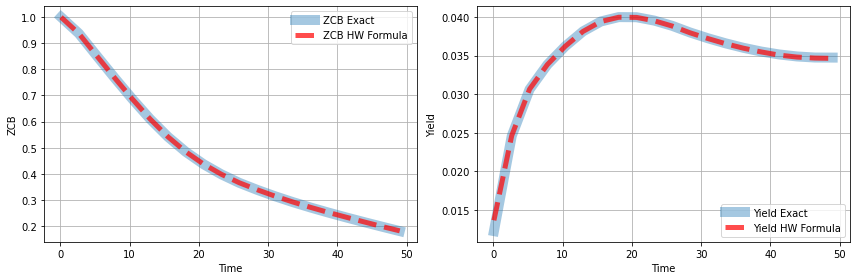

In [ ]:
# Source
# https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/blob/main/Lecture%2004-Yield%20Curve%20Dynamics%20under%20Short%20Rate/Materials/Hull-White-CompRateSim.py
import matplotlib.pyplot as plt
from scipy import interpolate


def main():
    num_steps = 100 
    sigma = 0.3
    lambd = 0.1
    T = 49
    
    # ZCB curve from the market
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator = interpolate.splrep( ti, np.log(pi), s=0.00001 )
    P = lambda t: np.exp( interpolate.splev(t, interpolator, der=0) ) 
    r0 = compute_r0(P)
    
    # In this experiment we compare ZCB from the Market and Analytical expression
    num_Tgrid = 20
    Tgrid= np.linspace( 0.1, T, num_Tgrid )
    
    ZCB_Exact = np.zeros( (num_Tgrid, 1) )
    ZCB_1FHW = np.zeros ( (num_Tgrid, 1) )
    Yield_Exact = np.zeros ( (num_Tgrid, 1) )
    Yield_1FHW = np.zeros ( (num_Tgrid, 1) )
    for i, Ti in enumerate(Tgrid):
        ZCB_Exact[i] = P(Ti)
        hw = HullWhite(sigma, lambd, P)
        ZCB_1FHW[i] = hw.compute_ZCB(t=0, T=Ti, r_t=r0) 
        Yield_Exact[i] = - np.log( ZCB_Exact[i] ) / Ti
        Yield_1FHW[i] = - np.log( ZCB_1FHW[i] ) / Ti
           
    fig0, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
    
    ax0.set_ylabel("ZCB")
    ax0.plot( Tgrid, ZCB_Exact, '-', label="ZCB Exact", linewidth=10, alpha=0.4)
    ax0.plot( Tgrid, ZCB_1FHW, '--r', label="ZCB HW Formula", linewidth=5, alpha=0.7)
    
    ax1.set_ylabel("Yield")
    ax1.plot( Tgrid, Yield_Exact, '-', label="Yield Exact", linewidth=10, alpha=0.4)
    ax1.plot( Tgrid, Yield_1FHW, '--r', label="Yield HW Formula", linewidth=5, alpha=0.7)
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_xlabel('Time')
        ax.legend(fontsize=10) 
        
    plt.tight_layout()
    plt.show()
    
    
if __name__ == "__main__":
    main()

#####***Hull-White Yield Curve Simulation***

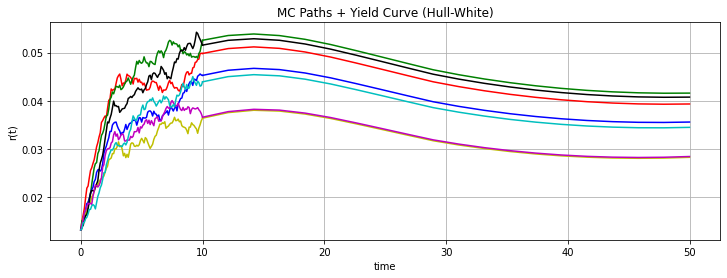

In [ ]:
# Source
# https://github.com/LechGrzelak/FinancialEngineering_IR_xVA/blob/main/Lecture%2004-Yield%20Curve%20Dynamics%20under%20Short%20Rate/Materials/Hull-White-CompRateSim.py
# Simulate short rates up to T = 10 
# Compute yield curve of 40 years span at T = 10
import matplotlib.pyplot as plt


def main():
    num_paths = 7
    num_steps = 100 
    sigma = 0.002
    lambd = 0.01
    T = 10. # Simulate short rates up to T = 10 
    T_end = T + 40. # Compute yield curve of 40 years span at T = 10
    
    # ZCB curve from the market
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator = interpolate.splrep( ti, np.log(pi), s=0.00001 )
    P = lambda t: np.exp( interpolate.splev(t, interpolator, der=0) ) 
    r0 = compute_r0(P)
    
    # Simulate the short rate up to T = 10
    hw = HullWhite(sigma, lambd, P)
    t, r, _ = hw.generate_sample_paths(num_paths, num_steps, T=T, seed=0)
    r_T = r[:,-1]

    # Yield Curves on the last point
    fig, ax = plt.subplots(figsize=(12,4))
    
    num_Tgrid = 20
    Tgrid = np.linspace( T + 0.001, T_end - 0.01, num_Tgrid )
    ZCB_HW = np.zeros ( (num_Tgrid, 1) )
    Yield_HW = np.zeros ( (num_Tgrid, 1) )
    
    colors = ('r','g','b','y','k','m','c')
    for path_num, color in zip( range(num_paths), colors ):
        ax.plot( t, r[path_num,:], color=color )
        for j, Tj in enumerate(Tgrid):
            ZCB_HW[j] = hw.compute_ZCB(t=T, T=Tj, r_t=r_T[path_num])
            Yield_HW[j] = - np.log( ZCB_HW[j] ) / ( Tj - T )
        ax.plot( Tgrid, Yield_HW, color=color )
         
    ax.set_xlabel('time')
    ax.set_ylabel('r(t)')
    ax.set_title('MC Paths + Yield Curve (Hull-White)')
    ax.grid()
    
    plt.show()
    
    
if __name__ == "__main__":
    main()

####***Section ZBO***

#####***$x(t)$ under $\mathbb{Q}$***

$$\begin{array}{lllll}
\displaystyle
dx(t)=-\lambda x(t)dt+\sigma dW^{\mathbb{Q}}(t),
\quad x(0)=0
\end{array}$$

can be soloved as

$$\begin{array}{lllll}
\displaystyle
x(t)
=
x(s)e^{-\lambda (t-s)}+ +\sigma \int_{s}^t e^{-\lambda (t-t')} dW^{\mathbb{Q}}(t')
\end{array}$$

Therefore,

$$
r(t)=x(t)+\alpha(t)
$$

#####***$x(t)$ under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
dx(t)=\left(-B(t,T)\sigma^2-\lambda x(t)\right)dt+\sigma dW^{\mathbb{T}}(t),
\quad x(0)=0
\end{array}$$

where

$$
\displaystyle
dW^{\mathbb{T}}(t)
=
\sigma B(t,T)dt+
dW^{\mathbb{Q}}(t)
$$

can be soloved as

$$\begin{array}{lllll}
\displaystyle
x(t)
=
x(s)e^{-\lambda (t-s)}-M^\mathbb{T}(s,t) +\sigma \int_{s}^t e^{-\lambda (t-t')} dW^{\mathbb{T}}(t')
\end{array}$$

where

$$
\displaystyle
M^\mathbb{T}(s,t)
=
\frac{\sigma^2}{\lambda^2}\left[1-e^{-\lambda(t-s)}\right]
-
\frac{\sigma^2}{2\lambda^2}e^{-\lambda(T-t)}\left[1-e^{-2\lambda(t-s)}\right]
$$

#####***$r(t)$ under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
r(t)=x(t)+\alpha(t)
\end{array}$$

Therefore, $r(t)$ conditional on ${\cal F}(s)$ is normally distributed with mean and variance given respectively by

$$\begin{array}{lllll}
\displaystyle
\mathbb{E}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
x(s)e^{-\lambda(t-s)}-M^\mathbb{T}(s,t)+\alpha(t)\\
\mathbb{Var}\left(r(t)|{\cal F}(s)\right)
&=&\displaystyle
\frac{\sigma^2}{2\lambda}\left(1-e^{-2\lambda(t-s)}\right)
\end{array}$$

#####***ZBO***

$$\begin{array}{lll}
\text{Current Time}&&t\\
\text{Option Maturity}&&T>t\\
\text{Underlying ZCB Maturity}&&S>T>t\\
\text{Strike}&&K\\
\text{Call Option Payoff at Option Maturity}&&(P(T,S)-K)^+\\
\text{Put Option Payoff at Option Maturity}&&(K-P(T,S))^+\\
\end{array}$$

Jamshidian (1989) shows

$$
\displaystyle
{\bf\text{ZBO}}(t,T,S,K,\omega)
=
\left\{\begin{array}{lll}
P(t,S)N(d_1)-KP(t,T)N(d_2)&&\text{if $\omega=1$ or if call}\\
-P(t,S)N(-d_1)+KP(t,T)N(-d_2)&&\text{if $\omega=-1$ or if put}\\
\end{array}\right.
$$

where

$$\begin{array}{lll}
\sigma_p&=&\displaystyle
\sigma\sqrt{\frac{1-e^{-2\lambda(T-t)}}{2\lambda}}B(T,S)
\\
d_1&=&\displaystyle
\frac{1}{\sigma_p}\log\frac{P(t,S)}{P(t,T)K}+\frac{1}{2}\sigma_p\\
d_2&=&\displaystyle
d_1-\sigma_p\\
\end{array}$$

######***Proof***

Using the known distribution of $r(T)$ under $\mathbb{T}$, compute

$$\begin{array}{lll}
\displaystyle
\mathbb{E^Q}e^{-\int_t^Tr(t')dt'}(P(T,S)-K)^+
=
P(t,T)\mathbb{E^T}(P(T,S)-K)^+
\end{array}$$

#####***Discounted Characteristic Function of $r(T)$***

$$\begin{array}{lllll}
\displaystyle
\phi(u;t,T)
=
\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^Tr(t')dt'+iur(T)}\Big{|}{\cal F}(t)\right]
=
e^{A(u,\tau)+B(u,\tau)r(t)}
\end{array}$$

######***Proof***



Since the Hull-White short rate dynamics is

$$\begin{array}{lllll}
\displaystyle
dr=\lambda\left(\theta(t)-r\right) dt+\sigma dW^{\mathbb{Q}}(t)
\end{array}$$

the ZCB PDE becomes

$$
\displaystyle
\frac{\partial P}{\partial t}
+\lambda\left(\theta(t)-r\right)\frac{\partial P}{\partial r}+\frac{1}{2}\sigma^2\frac{\partial^2 P}{\partial r^2}=rP
$$

By Feynman-Kac formula, $\phi(u;t,T)$ also satisfies the same PDE with different terminal condition.
We look for the ZCB PDE solution of the form

$$
\displaystyle
\phi(u;t,T)=e^{A(u,\tau)+B(u,\tau)r(t)}
$$

where $\tau=T-t$. 
Plugging $\phi(u;t,T)=e^{A(u,\tau)+B(u,\tau)r(t)}$ into the ZCB PDE, we have

$$
\displaystyle
\left(-A'-B'r\right)+\lambda\left(\theta(t)-r\right)B
+\frac{1}{2}\sigma^2 B^2=r 
$$

with $A(u,0)=0$, $B(u,0)=iu$.
Setting the coefficent of the $r$ term to be zero, we have

$$-B'-\lambda B =1$$

Solving this with the initial condition $B(u,0)=iu$ is easy and the solution is

$$
\displaystyle
B(u,\tau)=-\frac{1-(1+iu\lambda) e^{-\lambda \tau}}{\lambda}
=iue^{-\lambda\tau}+B(\tau)
$$

Setting all the other terms to be zero, we have with $A(u,0)=0$

$$
\displaystyle
-A'+\lambda\theta(t)B
+\frac{1}{2}\sigma^2 B^2=0
$$

Here we simply check

$$\begin{array}{lllll}
\displaystyle
A(u,\tau)
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}\left[(1+iu\lambda)\left[
    3-4e^{-\lambda \tau}+e^{-2\lambda \tau}
    - iu\lambda\left(1-e^{-2\lambda \tau}\right)
    \right]-2\lambda\tau\right]
+\lambda\int_0^\tau\theta(T-\tau')B(u,\tau')d\tau'\\
\end{array}$$

satisfies the ODE ($A(u,0)=0$ is obvious):

$$\begin{array}{lllll}
\displaystyle
A'
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}\left[(1+iu\lambda)\left[
    4\lambda e^{-\lambda \tau}-2\lambda e^{-2\lambda \tau}
    - iu\lambda\left(2\lambda e^{-2\lambda \tau}\right)
    \right]-2\lambda\right]
+\lambda\theta(T-\tau)B(u,\tau)\\
&=&\displaystyle
-\frac{\sigma^2}{4\lambda^3}\left[(1+iu\lambda)\left[
    4\lambda e^{-\lambda \tau}-2\lambda(1+iu\lambda) e^{-2\lambda \tau}
    \right]-2\lambda\right]
+\lambda\theta(t)B\\
&=&\displaystyle
-\frac{\sigma^2}{2\lambda^2}\left[(1+iu\lambda)\left[
    2 e^{-\lambda \tau}-(1+iu\lambda) e^{-2\lambda \tau}
    \right]-1\right]
+\lambda\theta(t)B\\
&=&\displaystyle
\frac{\sigma^2}{2\lambda^2}\left[(1+iu\lambda)\left[
    -2 e^{-\lambda \tau}+(1+iu\lambda) e^{-2\lambda \tau}
    \right]+1\right]
+\lambda\theta(t)B\\
&=&\displaystyle
\frac{\sigma^2}{2\lambda^2}\left[\left((1+iu\lambda) e^{-\lambda \tau}\right)^2
    -2(1+iu\lambda) e^{-\lambda \tau}+1\right]
+\lambda\theta(t)B\\
&=&\displaystyle
\frac{\sigma^2}{2}\left[\frac{(1+iu\lambda) e^{-\lambda \tau}-1}{\lambda}\right]^2
+\lambda\theta(t)B\\
&=&\displaystyle
\frac{1}{2}\sigma^2 B^2
+\lambda\theta(t)B\\
\end{array}$$

####***Section 5 Decomposition of Short Rate***

#####***Decomposition of Short Rate***

Decompose the short rate $r(t)$ as

$$\begin{array}{lllll}
\displaystyle
r(t)
=
\tilde{r}(t)+\psi(t)
\end{array}$$

Then,

$$\begin{array}{lllll}
\displaystyle
d\tilde{r}(t)
=
-\lambda\tilde{r}(t) dt+\sigma dW^{\mathbb{Q}}(t),\quad
\tilde{r}(0)=0
\end{array}$$

######***Proof***



$$\begin{array}{lllll}
\displaystyle
d\psi(t)
&=&\displaystyle
-\lambda r_0e^{-\lambda t}dt
-\lambda^2\left[\int_0^t\theta(t')e^{-\lambda(t-t')}dt'\right]dt
+\lambda \theta(t)dt
\\
&=&\displaystyle
-\lambda \psi(t)dt
+\lambda \theta(t)dt
\end{array}$$

So,

$$\begin{array}{lllll}
\displaystyle
d\tilde{r}(t)
&=&\displaystyle
dr(t)-d\psi(t)\\
&=&\displaystyle
\lambda\left(\theta(t)-r(t)\right) dt+\sigma dW^{\mathbb{Q}}(t)
+\lambda \psi(t)dt
-\lambda \theta(t)dt\\
&=&\displaystyle
-\lambda (r(t)-\psi(t)) dt+\sigma dW^{\mathbb{Q}}(t)
\\
&=&\displaystyle
-\lambda \tilde{r}(t) dt+\sigma dW^{\mathbb{Q}}(t)
\\
\end{array}$$

#####***Discounted Characteristic Function of $r(T)$***

$$\begin{array}{lllll}
\displaystyle
\phi(u;t,T)
=
\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^Tr(t')dt'+iur(T)}\Big{|}{\cal F}(t)\right]
=
e^{-\int_t^T\psi(t')dt'+iu\psi(T)}
\text{exp}\left(\tilde{A}(u,\tau)+\tilde{B}(u,\tau)\tilde{r}(t)\right)
\end{array}$$



######***Proof***



$$\begin{array}{lllll}
\displaystyle
\phi(u;t,T)
&=&\displaystyle
\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^Tr(t')dt'+iur(T)}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^T\left(\tilde{r}(t')+\psi(t')\right)dt'+iu\left(\tilde{r}(T)+\psi(T)\right)}\Big{|}{\cal F}(t)\right]\\
&=&\displaystyle
e^{-\int_t^T\psi(t')dt'+iu\psi(T)}
\mathbb{E}^\mathbb{Q}\left[e^{-\int_t^T\tilde{r}(t')dt'+iu\tilde{r}(T)}\Big{|}{\cal F}(t)\right]\\
&:=&\displaystyle
e^{-\int_t^T\psi(t')dt'+iu\psi(T)}
\tilde{\phi}(u;t,T)\\
&:=&\displaystyle
e^{-\int_t^T\psi(t')dt'+iu\psi(T)}
\text{exp}\left(\tilde{A}(u,\tau)+\tilde{B}(u,\tau)\tilde{r}(t)\right)\\
\end{array}$$

#####***ZCB Price $P(t,T)$***



$$
\displaystyle
P(t,T)=e^{A(\tau)+B(\tau)r(t)}
$$


######***Proof***



$$\begin{array}{lllll}
\displaystyle
P(0,T)
&=&\displaystyle
\phi(u=0;t=0,T=T)\\
&=&\displaystyle
\text{exp}\left(-\int_0^T\psi(z)dz+\tilde{A}(0,\tau)+\tilde{B}(0,\tau)\tilde r(0)\right)\\
&=&\displaystyle
\text{exp}\left(
-\int_0^T\left[r_0e^{-\lambda z}+\lambda\int_0^z\theta(s)e^{-\lambda(z-s)}ds\right]dz
+\tilde{A}(0,\tau)
\right)\\
&=&\displaystyle
\text{exp}\left(
-\int_0^T r_0e^{-\lambda z}dz-\int_0^T \left[\lambda\int_0^z\theta(s)e^{-\lambda(z-s)}ds\right]dz
+\tilde{A}(0,\tau)
\right)\\
&=&\displaystyle
\text{exp}\left(
r_0\frac{e^{-\lambda T}-1}{\lambda}-\int_0^T \left[\lambda\int_0^z\theta(s)e^{-\lambda(z-s)}ds\right]dz
+\tilde{A}(0,\tau)
\right)\\
&=&\displaystyle
\text{exp}\left(
-\int_0^T \left[\lambda\int_0^z\theta(s)e^{-\lambda(z-s)}ds\right]dz
+\tilde{A}(0,\tau)
+\tilde{B}(0,\tau)r_0
\right)\\
&=&\displaystyle
\text{exp}\left(
-\lambda\int_0^T \left[\int_s^T\theta(s)e^{-\lambda(z-s)}dz\right]ds
+\tilde{A}(0,\tau)
+\tilde{B}(0,\tau)r_0
\right)\\
&=&\displaystyle
\text{exp}\left(
\lambda\int_0^T \theta(s)\frac{e^{-\lambda(T-s)}-1}{\lambda}ds
+\tilde{A}(0,\tau)
+\tilde{B}(0,\tau)r_0
\right)\\
&=&\displaystyle
\text{exp}\left(
\lambda\int_0^T \theta(s)\tilde{B}(0,T-s)ds
+\tilde{A}(0,\tau)
+\tilde{B}(0,\tau)r_0
\right)\\
&:=&\displaystyle
\text{exp}\left(
A(\tau)
+B(\tau)r(0)
\right)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\int_0^\tau\psi(t')dt'
&=&\displaystyle
r_0\int_0^\tau e^{-\lambda t'}dt'
+\lambda\int_0^\tau\int_0^{t'}\theta(t'')e^{-\lambda(t'-t'')}dt''dt'
\\
&=&\displaystyle
-r_0B(\tau)+\lambda\int_0^\tau\int_{t''}^{\tau}\theta(t'')e^{-\lambda(t'-t'')}dt'dt''
\\
&=&\displaystyle
-r_0B(\tau)-\lambda\int_0^\tau\theta(t'')B(\tau-t'')dt''
\\
\end{array}$$

#####***Final Form of $\psi$***



$$\begin{array}{lllll}
\displaystyle
\psi(T)
=
f(0,T)+\frac{\sigma^2}{2\lambda}\left(e^{-\lambda T}-1\right)^2\\
\end{array}$$

######***Proof***



$$\begin{array}{lllll}
\displaystyle
P(0,T)
&=&\displaystyle
\phi_{\text{HW}}(u=0;t=0,T=T)\\
&=&\displaystyle
\text{exp}\left(-\int_0^T\psi(z)dz+\tilde{A}(0,\tau)+\tilde{B}(0,\tau)\tilde r(0)\right)\\
&=&\displaystyle
\text{exp}\left(-\int_0^T\psi(z)dz+\tilde{A}(0,\tau)\right)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\psi(T)
&=&\displaystyle
-\frac{\partial}{\partial T}\log P(0,T)+\frac{\partial}{\partial T}\tilde{A}(0,T)\\
&=&\displaystyle
f(0,T)+\frac{\sigma^2}{2\lambda}\left(e^{-\lambda T}-1\right)^2\\
\end{array}$$

####***Section 6 Two Facotr Hull-White***

#####***Two Factor Hull-White Model recovers Market ZCB Curve and Yield Curve***

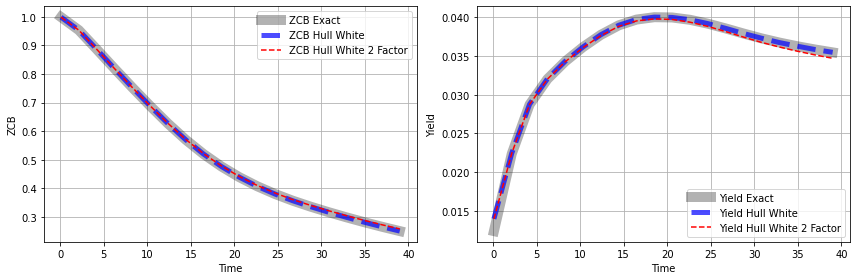

In [ ]:
import matplotlib.pyplot as plt


def main():
    num_paths = 20_000
    num_steps = 100 
    sigma1 = 0.002
    sigma2 = 0.002
    lambd1 = 0.01
    lambd2 = 0.1
    rho = -0.2
    T = 39
    
    # We define a ZCB curve (obtained from the market)
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator = interpolate.splrep( ti, pi, s=0.00001 )
    P = lambda t: interpolate.splev(t, interpolator, der=0) # ZCB curve from the market
    r0 = compute_r0(P)
    
    # In this experiment we compare ZCB from the Market and Analytical expression
    num_Tgrid = 20
    Tgrid= np.linspace( 0.1, T, num_Tgrid )

    ZCB_Exact = np.zeros( (num_Tgrid, 1) )
    ZCB_HW = np.zeros ( (num_Tgrid, 1) )
    ZCB_HW2F = np.zeros ( (num_Tgrid, 1) )
    Yield_Exact = np.zeros ( (num_Tgrid, 1) )
    Yield_HW = np.zeros ( (num_Tgrid, 1) )
    Yield_HW2F = np.zeros ( (num_Tgrid, 1) )
    for i, Ti in enumerate(Tgrid):
        ZCB_Exact[i] = P(Ti)
        hw = HullWhite(sigma1, lambd1, P)
        ZCB_HW[i] = hw.compute_ZCB(t=0, T=Ti, r_t=r0)
        hw2 = HullWhite2(sigma1, sigma2, lambd1, lambd2, rho, P)
        ZCB_HW2F[i] = hw2.compute_ZCB(0, Ti, 0, 0)
        Yield_Exact[i] = - np.log( ZCB_Exact[i] ) / Ti
        Yield_HW[i] = - np.log( ZCB_HW[i] ) / Ti
        Yield_HW2F[i] = - np.log( ZCB_HW2F[i] ) / Ti
               
    fig0, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
    
    ax0.set_ylabel("ZCB")
    ax0.plot( Tgrid, ZCB_Exact, '-k', label="ZCB Exact", lw=10, alpha=0.3)
    ax0.plot( Tgrid, ZCB_HW, '--b', label="ZCB Hull White", lw=5, alpha=0.7)
    ax0.plot( Tgrid, ZCB_HW2F, '--r', label="ZCB Hull White 2 Factor")
    
    ax1.set_ylabel("Yield")
    ax1.plot( Tgrid, Yield_Exact, '-k', label="Yield Exact", lw=10, alpha=0.3)
    ax1.plot( Tgrid, Yield_HW, '--b', label="Yield Hull White", lw=5, alpha=0.7)
    ax1.plot( Tgrid, Yield_HW2F, '--r', label="Yield Hull White 2 Factor")
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.set_xlabel('Time')
        ax.legend() 
    plt.tight_layout()
    plt.show()
    
    
if __name__ == "__main__":
    main()

#####***Two Factor Hull-White Yield Curve Simulation***

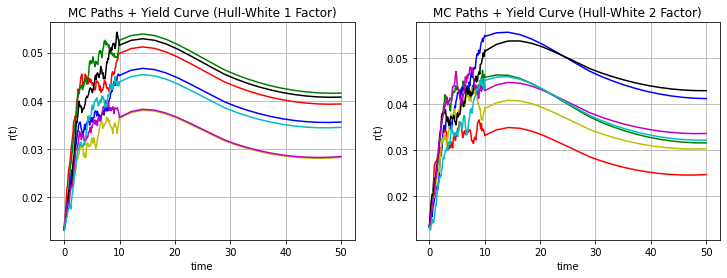

In [ ]:
import matplotlib.pyplot as plt


def main():
    num_paths = 7
    num_steps = 100 
    
    sigma = 0.002
    lambd = 0.01
    
    sigma1 = sigma
    sigma2 = 0.002
    lambd1 = lambd
    lambd2 = 0.1
    rho = -0.2
    
    T = 10. # Simulate short rates up to T = 10 
    T_end = T + 40. # Compute yield curve of 40 years span at T = 10
    
    num_Tgrid = 20
    Tgrid = np.linspace( T + 0.001, T_end - 0.01, num_Tgrid )
    
    # ZCB curve from the market
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator = interpolate.splrep( ti, np.log(pi), s=0.00001 )
    P = lambda t: np.exp( interpolate.splev(t, interpolator, der=0) ) 
    r0 = compute_r0(P)
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
    
    ax0.set_title('MC Paths + Yield Curve (Hull-White 1 Factor)')
    
    # simulate the short rate up to T = 10
    hw = HullWhite(sigma, lambd, P)
    t, r, _ = hw.generate_sample_paths(num_paths, num_steps, T=T, seed=0)
    r_T = r[:,-1]
    
    # compute yield curve from T = 10 to 10 + 40
    ZCB_HW = np.zeros ( (num_Tgrid, 1) )
    Yield_HW = np.zeros ( (num_Tgrid, 1) )
    for path_num, color in zip( range(num_paths), ('r','g','b','y','k','m','c') ):
        ax0.plot( t, r[path_num,:], color=color )
        for j, Tj in enumerate(Tgrid):
            ZCB_HW[j] = hw.compute_ZCB(t=T, T=Tj, r_t=r_T[path_num])
            Yield_HW[j] = - np.log( ZCB_HW[j] ) / ( Tj - T )
        ax0.plot( Tgrid, Yield_HW, color=color )
        
    ax1.set_title('MC Paths + Yield Curve (Hull-White 2 Factor)')
    
    # simulate the short rate up to T = 10
    hw2 = HullWhite2(sigma1, sigma2, lambd1, lambd2, rho, P)
    t, x, y, r, _ = hw2.generate_sample_paths(num_paths, num_steps, T=T, seed=0)
    x_T = x[:,-1]
    y_T = y[:,-1]
    r_T = r[:,-1]
    
    # compute yield curve from T = 10 to 10 + 40
    ZCB_HW2 = np.zeros ( (num_Tgrid, 1) )
    Yield_HW2 = np.zeros ( (num_Tgrid, 1) )
    for path_num, color in zip( range(num_paths), ('r','g','b','y','k','m','c') ):
        ax1.plot( t, r[path_num,:], color=color )
        for j, Tj in enumerate(Tgrid):
            ZCB_HW2[j] = hw2.compute_ZCB(T, Tj, x_T[path_num], y_T[path_num])
            Yield_HW2[j] = - np.log( ZCB_HW2[j] ) / ( Tj - T )
        ax1.plot( Tgrid, Yield_HW2, color=color )
    
    for ax in (ax0, ax1):
        ax.set_xlabel('time')
        ax.set_ylabel('r(t)')  
        ax.grid()
    
    plt.tight_layout
    plt.show()
    
    
if __name__ == "__main__":
    main()

###***Chapter 8 Linear Interest Rate Products***

####***Section 2 Swap***

#####***Hull-White recovers Swap Pricing***

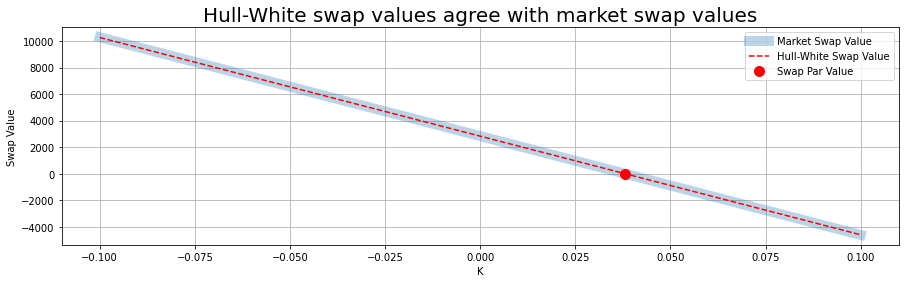

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.interpolate import splrep, splev 
from scipy.optimize import newton


def main(): 
    # swap setting
    CP = OptionTypeSwap.PAYER # payer swap pays fixed rate
    notional = 10000.0 
    Ks = np.linspace(-0.1,0.1,25) # several differnt strikes
    Ti = 1.0 # begining of the swap
    Tm = 10.0 # end date of the swap 
    n = 10 # number of payments between Ti and Tm
    
    # Hull White model parameters
    lambd = 0.5
    sigma = 0.03 
            
    # Market ZCB Curve
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    
    # bond price and current short rate
    interpolator = splrep(ti, np.log(Pi), s=0.0001)
    P = lambda T: np.exp( splev(T, interpolator, der=0) )
    r0 = compute_r0(P)

    hw = HullWhite(sigma, lambd, P)
     
    # We compare market swap prices with Hull White model swap prices 
    Swap = np.zeros( Ks.shape[0] ) # First we compute the exact swap prices from Market ZCB Curve
    Swap_HW = np.zeros( Ks.shape[0] ) # Second we compute swap prices using Hull White model 
    t0 = 0
    for idx, K in enumerate(Ks):
        Swap[idx] = compute_SwapPrice(P, 0, notional, K, Ti, Tm, n, CP)
        Swap_HW[idx] = hw.compute_SwapPrice(0, r0, notional, K, Ti, Tm, n, CP)
    
    # Computation for Swap Par
    func = lambda K: compute_SwapPrice(P, 0, notional, K, Ti, Tm, n, CP)
    K_par = newton(func, 0.0)
    SwapPrice_par = compute_SwapPrice(P, 0, notional, K_par, Ti, Tm, n, CP)
    
    fig, ax = plt.subplots(figsize=(15,4))
    
    ax.set_title('Hull-White swap values agree with market swap values', fontsize=20)
    ax.plot(Ks, Swap, linewidth=10, alpha=0.3, label="Market Swap Value")
    ax.plot(Ks, Swap_HW,'--r', label="Hull-White Swap Value")
    ax.plot([K_par], [SwapPrice_par],'or', ms=10, label="Swap Par Value")
    ax.grid()
    ax.legend()
    ax.set_xlabel('K')
    ax.set_ylabel('Swap Value')
    
    plt.show()

    
if __name__ == "__main__":
    main()

###***Chapter 9 Non-Linear Interest Rate Products***

####***Section 1 Change of Numeraire from $\mathbb{Q}$ to $\mathbb{T}$***

#####***Change of Numeraire from $\mathbb{Q}$ to $\mathbb{T}$***

$$
\displaystyle
dW^{\mathbb{Q}}(t)=dW^\mathbb{T}(t)+\sigma_P(t,T)dt
$$



######***Proof***



From ZCB dynamics,

$$\begin{array}{lllll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
=
r(t)dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
d\log P(t,T)
=
\left(r(t)-\frac{1}{2}\sigma_P^2(t,T)\right)dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)\\
\end{array}$$

$$\begin{array}{lllll}
\displaystyle
\frac{P(t,T)}{P(0,T)}
=
\text{exp}\left(\int_0^t\left(r(t')-\frac{1}{2}\sigma_P^2(t',T)\right)dt'+\int_0^t\sigma_P(t',T)dW^{\mathbb{Q}}(t')\right)
\end{array}$$

Radon-Nikodym derivative is

$$\begin{array}{lllll}
\displaystyle
\lambda_\mathbb{Q}^T(t)
=
\displaystyle
\frac{d\mathbb{Q}^T}{d\mathbb{Q}}\Big{|}_{{\cal F}(t)}
=
\frac{P(t,T)/P(0,T)}{M(t)/M(0)}
=
\text{exp}\left(
-\frac{1}{2}\int_0^t\sigma_P^2(t',T)dt'+\int_0^t\sigma_P(t',T)dW^\mathbb{Q}(t')
\right)\\
\end{array}$$

By Gilsanov theorem,

$$\begin{array}{lllll}
\displaystyle
dW^\mathbb{T}(t)=dW^{\mathbb{Q}}(t)-\sigma_P(t,T)dt
\end{array}$$

#####***$df$ under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
df(t,T)
=
\sigma(t,T)dW^\mathbb{T}(t)
\end{array}$$



######***Proof***



$$\begin{array}{lllll}
\displaystyle
df(t,T)
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt
+\sigma(t,T)dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt
+\sigma(t,T)\left(dW^\mathbb{T}(t)+\sigma_P(t,T)dt\right)\\
&=&\displaystyle
\left(\sigma(t,T)\int_t^T\sigma(t,T')dT'\right)dt
+\sigma(t,T)\left(
dW^\mathbb{T}(t)-\left(\int_t^T\sigma(t,T')dT'\right)dt
\right)\\
&=&\displaystyle
\sigma(t,T)dW^\mathbb{T}(t)
\end{array}$$

#####***$dP$ under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
=
\left(r(t)+\sigma_P^2(t,T)\right)dt+\sigma_P(t,T) dW^\mathbb{T}(t) \\
\end{array}$$



######***Proof***



$$\begin{array}{lllll}
\displaystyle
\frac{dP(t,T)}{P(t,T)}
&=&\displaystyle
r(t)dt+\sigma_P(t,T)dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
r(t)dt+\sigma_P(t,T)\left(dW^\mathbb{T}_t+\sigma_P(t,T)dt\right)\\
&=&\displaystyle
\left(r(t)+\sigma_P^2(t,T)\right)dt+\sigma_P(t,T) dW^\mathbb{T}(t) \\
\end{array}$$

#####***$dr$ under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
dr(t)
=
\lambda\left(\theta^\mathbb{T}(t)- r(t)\right) dt+\sigma dW^\mathbb{T}(t)\\
\end{array}$$

######***Proof***



$$\begin{array}{lllll}
\displaystyle
dr(t)
&=&\displaystyle
\lambda\left(\theta(t)-r(t)\right) dt+\sigma dW^{\mathbb{Q}}(t)\\
&=&\displaystyle
\lambda\left(\theta(t)-r(t)\right) dt+\sigma \left(dW^\mathbb{T}(t)+\sigma_P(t,T)dt\right)\\
&=&\displaystyle
\lambda\left(\theta(t)+\frac{\sigma}{\lambda}\sigma_P(t,T)-r(t)\right) dt+\sigma dW^\mathbb{T}(t)\\
&:=&\displaystyle
\lambda\left(\theta^\mathbb{T}(t)- r(t)\right) dt+\sigma dW^\mathbb{T}(t)\\
\end{array}$$

#####***Hull-White Short Rate under $\mathbb{T}$***

$$\begin{array}{lllll}
\displaystyle
r(t)|r(t_0)
=
r(t_0)e^{-\lambda (t-t_0)}+ \lambda\int_{t_0}^t\theta^\mathbb{T}(t')e^{-\lambda (t-t')} dt'+\sigma \int_{t_0}^t e^{-\lambda (t-t')} dW^{\mathbb{T}}(t')
&\sim&\displaystyle
N\left(\mu^\mathbb{T}_r(t_0,t),\sigma_r^2(t_0,t)\right)\\
\end{array}$$

####***Section 2 ZCB Option***

#####***ZCB Call ($\alpha=1$) and Put ($\alpha=-1$)***

Let $t_0$, $T$, $T_S$ be current, ZCB option maturity, ZCB maturity, respectively. 
For the call

$$\begin{array}{lllll}
\displaystyle
V^\text{ZCB}(t_0,T)
=
P(t_0,T)e^{A(\tau)}\left[e^{\frac{1}{2}B^2(\tau)\sigma_r^2(t_0,T)+B(\tau)\mu^\mathbb{T}_r(t_0,T)}N(d_1)-\hat{K}N(d_2)\right]\\
\end{array}$$

where 

$$\begin{array}{lll}
\tau&=&T_S-T\\
\displaystyle
P(T,T_s)
&=&\displaystyle e^{A(\tau)+B(\tau)r(T)}\\
\hat{K}&=&Ke^{-A(\tau)}\\
d_2&=&\displaystyle
\frac{\log\hat{K}-B(\tau)\mu^\mathbb{T}_r(t_0,T)}{B(\tau)\sigma_r(t_0,T)}\\
d_1&=&\displaystyle
d_2-B(\tau)\sigma_r(t_0,T)\\
\end{array}$$

######***Proof***



$$\begin{array}{lllll}
\displaystyle
V^\text{ZCB}(t_0,T)
&=&\displaystyle
\mathbb{E^Q}\left[\frac{M(t_0)}{M(T)}\text{max}\left(\alpha\left(P(T,T_S)-K\right),0\right)\Big{|}{\cal F}(t_0)\right]\\
&=&\displaystyle
P(t_0,T)\mathbb{E}^T\left[\text{max}\left(\alpha\left(P(T,T_S)-K\right),0\right)\Big{|}{\cal F}(t_0)\right]\\
&=&\displaystyle
P(t_0,T)\mathbb{E}^T\left[\text{max}\left(\alpha\left(e^{A(\tau)+B(\tau)r(T)}-K\right),0\right)\Big{|}{\cal F}(t_0)\right]\\
&=&\displaystyle
P(t_0,T)e^{A(\tau)}\mathbb{E}^T\left[\text{max}\left(\alpha\left(e^{B(\tau)r(T)}-\hat{K}\right),0\right)\Big{|}{\cal F}(t_0)\right]\\
\end{array}$$

Now, by solving $dr(t)=\lambda\left(\theta^T(t)-r(t)\right) dt+\sigma dW^T(t)$

$$
\displaystyle
r(T)|r(t_0)\sim N\left(\mu_r(t_0,T),v_r^2(t_0,T)\right)
$$

$$
\displaystyle
B(\tau)r(T)|r(t_0)\sim N\left(B(\tau)\mu_r(t_0,T),B^2(\tau)v_r^2(t_0,T)\right)
$$

Following Black Scholes computation, we have for the call
(remember $B(\tau)=(e^{-\lambda\tau}-1)/\lambda<0$)

$$\begin{array}{lllll}
\displaystyle
V^\text{ZCB}(t_0,T)
&=&\displaystyle
P(t_0,T)e^{A(\tau)}\mathbb{E}^T\left[\text{max}\left(e^{B(\tau)r(T)}-\hat{K},0\right)\Big{|}{\cal F}(t_0)\right]\\
&=&\displaystyle
P(t_0,T)e^{A(\tau)}\int_{e^{B(\tau)\mu_r(t_0,T)+B(\tau)v_r(t_0,T)z}>\hat{K}}\left(e^{B(\tau)\mu_r(t_0,T)+B(\tau)v_r(t_0,T)z}-\hat{K}\right)\frac{1}{\sqrt{2\pi}}e^{-z^2/2}dz\\
&=&\displaystyle
P(t_0,T)e^{A(\tau)}\int^a_{-\infty}
\left(e^{B(\tau)\mu_r(t_0,T)+B(\tau)v_r(t_0,T)z}-\hat{K}\right)\frac{1}{\sqrt{2\pi}}e^{-z^2/2}dz\\
&=&\displaystyle
P(t_0,T)e^{A(\tau)}\left[e^{\frac{1}{2}B^2(\tau)v_r^2(t_0,T)+B(\tau)\mu_r(t_0,T)}N(d_1)-\hat{K}N(d_2)\right]\\
\end{array}$$

where

$$\begin{array}{lll}
a&=&\displaystyle
\frac{\log\hat{K}-B(\tau)\mu_r(t_0,T)}{B(\tau)v_r(t_0,T)}\\
d_1&=&\displaystyle
a-B(\tau)v_r(t_0,T)\\
d_2&=&\displaystyle
a\\
\end{array}$$

#####***Hull-White MC agrees with Hull-White ZCB Option Formula***

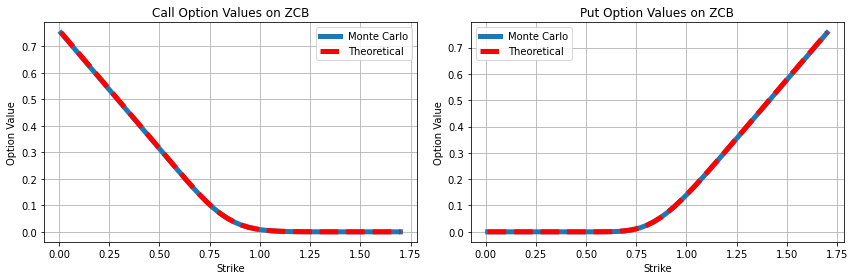

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev 


def main():
    # Hull White model parameters
    lambd = 0.02
    sigma = 0.02
    
    # in this experiment we compare the price of an option on a ZCB from Monte Carlo and Analytical expression 
    T1 = 4.0 # option maturity
    T2 = 8.0 # underlying ZCB maturity
    num_paths = 20_000
    num_steps = 1_000
    
    # market ZCB curve, 1-D points with a B-spline curve
    ti = [0.0,0.00273972600000000,0.0876712330000000,0.172602740000000,0.257534247000000,0.342465753000000,0.427397260000000,0.512328767000000,0.597260274000000,0.682191781000000,0.767123288000000,0.852054795000000,0.936986301000000,1.02191780800000,1.10684931500000,1.19178082200000,1.27671232900000,1.36164383600000,1.44657534200000,1.53150684900000,1.61643835600000,1.70136986300000,1.78630137000000,1.87123287700000,1.95616438400000,2.04109589000000,2.12602739700000,2.21095890400000,2.29589041100000,2.38082191800000,2.46575342500000,2.55068493200000,2.63561643800000,2.72054794500000,2.80547945200000,2.89041095900000,2.97534246600000,3.06027397300000,3.14520547900000,3.23013698600000,3.31506849300000,3.40000000000000,3.48493150700000,3.56986301400000,3.65479452100000,3.73972602700000,3.82465753400000,3.90958904100000,3.99452054800000,4.07945205500000,4.16438356200000,4.24931506800000,4.33424657500000,4.41917808200000,4.50410958900000,4.58904109600000,4.67397260300000,4.75890411000000,4.84383561600000,4.92876712300000,5.01369863000000,5.09863013700000,5.18356164400000,5.26849315100000,5.35342465800000,5.43835616400000,5.52328767100000,5.60821917800000,5.69315068500000,5.77808219200000,5.86301369900000,5.94794520500000,6.03287671200000,6.11780821900000,6.20273972600000,6.28767123300000,6.37260274000000,6.45753424700000,6.54246575300000,6.62739726000000,6.71232876700000,6.79726027400000,6.88219178100000,6.96712328800000,7.05205479500000,7.13698630100000,7.22191780800000,7.30684931500000,7.39178082200000,7.47671232900000,7.56164383600000,7.64657534200000,7.73150684900000,7.81643835600000,7.90136986300000,7.98630137000000,8.07123287700000,8.15616438400000,8.24109589000000,8.32602739700000,8.41095890400000,8.49589041100000,8.58082191800000,8.66575342500000,8.75068493200000,8.83561643800000,8.92054794500000,9.00547945200000,9.09041095900000,9.17534246600000,9.26027397300000,9.34520547900000,9.43013698600000,9.51506849300000,9.60000000000000,9.68493150700000,9.76986301400000,9.85479452100000,9.93972602700000,10.0246575300000,10.1095890400000,10.1945205500000,10.2794520500000,10.3643835600000,10.4493150700000,10.5342465800000,10.6191780800000,10.7041095900000,10.7890411000000,10.8739726000000,10.9589041100000,11.0438356200000,11.1287671200000,11.2136986300000,11.2986301400000,11.3835616400000,11.4684931500000,11.5534246600000,11.6383561600000,11.7232876700000,11.8082191800000,11.8931506800000,11.9780821900000,12.0630137000000,12.1479452100000,12.2328767100000,12.3178082200000,12.4027397300000,12.4876712300000,12.5726027400000,12.6575342500000,12.7424657500000,12.8273972600000,12.9123287700000,12.9972602700000,13.0821917800000,13.1671232900000,13.2520547900000,13.3369863000000,13.4219178100000,13.5068493200000,13.5917808200000,13.6767123300000,13.7616438400000,13.8465753400000,13.9315068500000,14.0164383600000,14.1013698600000,14.1863013700000,14.2712328800000,14.3561643800000,14.4410958900000,14.5260274000000,14.6109589000000,14.6958904100000,14.7808219200000,14.8657534200000,14.9506849300000,15.0356164400000,15.1205479500000,15.2054794500000,15.2904109600000,15.3753424700000,15.4602739700000,15.5452054800000,15.6301369900000,15.7150684900000,15.8000000000000,15.8849315100000,15.9698630100000,16.0547945200000,16.1397260300000,16.2246575300000,16.3095890400000,16.3945205500000,16.4794520500000,16.5643835600000,16.6493150700000,16.7342465800000,16.8191780800000,16.9041095900000,16.9890411000000,17.0739726000000,17.1589041100000,17.2438356200000,17.3287671200000,17.4136986300000,17.4986301400000,17.5835616400000,17.6684931500000,17.7534246600000,17.8383561600000,17.9232876700000,18.0082191800000,18.0931506800000,18.1780821900000,18.2630137000000,18.3479452100000,18.4328767100000,18.5178082200000,18.6027397300000,18.6876712300000,18.7726027400000,18.8575342500000,18.9424657500000,19.0273972600000,19.1123287700000,19.1972602700000,19.2821917800000,19.3671232900000,19.4520547900000,19.5369863000000,19.6219178100000,19.7068493200000,19.7917808200000,19.8767123300000,19.9616438400000,20.0465753400000,20.1315068500000,20.2164383600000,20.3013698600000,20.3863013700000,20.4712328800000,20.5561643800000,20.6410958900000,20.7260274000000,20.8109589000000,20.8958904100000,20.9808219200000,21.0657534200000,21.1506849300000,21.2356164400000,21.3205479500000,21.4054794500000,21.4904109600000,21.5753424700000,21.6602739700000,21.7452054800000,21.8301369900000,21.9150684900000,22,22.0849315100000,22.1698630100000,22.2547945200000,22.3397260300000,22.4246575300000,22.5095890400000,22.5945205500000,22.6794520500000,22.7643835600000,22.8493150700000,22.9342465800000,23.0191780800000,23.1041095900000,23.1890411000000,23.2739726000000,23.3589041100000,23.4438356200000,23.5287671200000,23.6136986300000,23.6986301400000,23.7835616400000,23.8684931500000,23.9534246600000,24.0383561600000,24.1232876700000,24.2082191800000,24.2931506800000,24.3780821900000,24.4630137000000,24.5479452100000,24.6328767100000,24.7178082200000,24.8027397300000,24.8876712300000,24.9726027400000,25.0575342500000,25.1424657500000,25.2273972600000,25.3123287700000,25.3972602700000,25.4821917800000,25.5671232900000,25.6520547900000,25.7369863000000,25.8219178100000,25.9068493200000,25.9917808200000,26.0767123300000,26.1616438400000,26.2465753400000,26.3315068500000,26.4164383600000,26.5013698600000,26.5863013700000,26.6712328800000,26.7561643800000,26.8410958900000,26.9260274000000,27.0109589000000,27.0958904100000,27.1808219200000,27.2657534200000,27.3506849300000,27.4356164400000,27.5205479500000,27.6054794500000,27.6904109600000,27.7753424700000,27.8602739700000,27.9452054800000,28.0301369900000,28.1150684900000,28.2000000000000,28.2849315100000,28.3698630100000,28.4547945200000,28.5397260300000,28.6246575300000,28.7095890400000,28.7945205500000,28.8794520500000,28.9643835600000,29.0493150700000,29.1342465800000,29.2191780800000,29.3041095900000,29.3890411000000,29.4739726000000,29.5589041100000,29.6438356200000,29.7287671200000,29.8136986300000,29.8986301400000,29.9835616400000,30.0684931500000,30.1534246600000,30.2383561600000,30.3232876700000,30.4082191800000,30.4931506800000,30.5780821900000,30.6630137000000,30.7479452100000,30.8328767100000,30.9178082200000,31.0027397300000,31.0876712300000,31.1726027400000,31.2575342500000,31.3424657500000,31.4273972600000,31.5123287700000,31.5972602700000,31.6821917800000,31.7671232900000,31.8520547900000,31.9369863000000,32.0219178100000,32.1068493200000,32.1917808200000,32.2767123300000,32.3616438400000,32.4465753400000,32.5315068500000,32.6164383600000,32.7013698600000,32.7863013700000,32.8712328800000,32.9561643800000,33.0410958900000,33.1260274000000,33.2109589000000,33.2958904100000,33.3808219200000,33.4657534200000,33.5506849300000,33.6356164400000,33.7205479500000,33.8054794500000,33.8904109600000,33.9753424700000,34.0602739700000,34.1452054800000,34.2301369900000,34.3150684900000,34.4000000000000,34.4849315100000,34.5698630100000,34.6547945200000,34.7397260300000,34.8246575300000,34.9095890400000,34.9945205500000,35.0794520500000,35.1643835600000,35.2493150700000,35.3342465800000,35.4191780800000,35.5041095900000,35.5890411000000,35.6739726000000,35.7589041100000,35.8438356200000,35.9287671200000,36.0136986300000,36.0986301400000,36.1835616400000,36.2684931500000,36.3534246600000,36.4383561600000,36.5232876700000,36.6082191800000,36.6931506800000,36.7780821900000,36.8630137000000,36.9479452100000,37.0328767100000,37.1178082200000,37.2027397300000,37.2876712300000,37.3726027400000,37.4575342500000,37.5424657500000,37.6273972600000,37.7123287700000,37.7972602700000,37.8821917800000,37.9671232900000,38.0520547900000,38.1369863000000,38.2219178100000,38.3068493200000,38.3917808200000,38.4767123300000,38.5616438400000,38.6465753400000,38.7315068500000,38.8164383600000,38.9013698600000,38.9863013700000,39.0712328800000,39.1561643800000,39.2410958900000,39.3260274000000,39.4109589000000,39.4958904100000,39.5808219200000,39.6657534200000,39.7506849300000,39.8356164400000,39.9205479500000,40.0054794500000]
    Pi = [1.0,0.999966573000000,0.998930882000000,0.997824062000000,0.996511145000000,0.995199956000000,0.993821602000000,0.992277014000000,0.990734827000000,0.989164324000000,0.987428762000000,0.985704346000000,0.983946708000000,0.982068207000000,0.980193293000000,0.978281187000000,0.976255832000000,0.974234670000000,0.972174514000000,0.970028236000000,0.967886697000000,0.965693800000000,0.963440984000000,0.961193424000000,0.958903753000000,0.956575247000000,0.954252397000000,0.951842433000000,0.949228406000000,0.946482248000000,0.943632525000000,0.940707509000000,0.937735160000000,0.934743101000000,0.931758611000000,0.928808623000000,0.925919731000000,0.923110403000000,0.920338655000000,0.917589739000000,0.914858924000000,0.912141532000000,0.909432941000000,0.906728583000000,0.904023944000000,0.901314567000000,0.898596044000000,0.895864025000000,0.893114214000000,0.890346348000000,0.887569841000000,0.884786140000000,0.881996090000000,0.879200528000000,0.876400278000000,0.873596157000000,0.870788975000000,0.867979528000000,0.865168605000000,0.862356987000000,0.859545442000000,0.856732322000000,0.853915005000000,0.851094371000000,0.848271318000000,0.845446732000000,0.842621487000000,0.839796449000000,0.836972470000000,0.834150393000000,0.831331050000000,0.828515261000000,0.825703790000000,0.822893949000000,0.820084325000000,0.817275636000000,0.814468590000000,0.811663887000000,0.808862219000000,0.806064266000000,0.803270701000000,0.800482187000000,0.797699379000000,0.794922921000000,0.792153338000000,0.789389717000000,0.786631547000000,0.783878633000000,0.781130782000000,0.778387801000000,0.775649505000000,0.772915708000000,0.770186227000000,0.767460882000000,0.764739497000000,0.762021898000000,0.759308200000000,0.756599781000000,0.753896558000000,0.751198194000000,0.748504356000000,0.745814715000000,0.743128950000000,0.740446741000000,0.737767776000000,0.735091745000000,0.732418345000000,0.729747277000000,0.727078670000000,0.724413443000000,0.721751645000000,0.719093279000000,0.716438346000000,0.713786850000000,0.711138792000000,0.708494177000000,0.705853006000000,0.703215284000000,0.700581015000000,0.697950202000000,0.695320544000000,0.692690217000000,0.690059929000000,0.687430378000000,0.684802253000000,0.682176235000000,0.679552992000000,0.676933185000000,0.674317462000000,0.671706465000000,0.669100824000000,0.666501159000000,0.663908082000000,0.661322194000000,0.658744089000000,0.656174348000000,0.653613545000000,0.651062245000000,0.648521002000000,0.645990363000000,0.643470865000000,0.640963036000000,0.638467395000000,0.635983411000000,0.633503959000000,0.631028021000000,0.628556105000000,0.626088714000000,0.623626343000000,0.621169478000000,0.618718599000000,0.616274178000000,0.613836679000000,0.611406558000000,0.608984265000000,0.606570242000000,0.604164924000000,0.601768738000000,0.599382105000000,0.597005438000000,0.594639144000000,0.592283621000000,0.589939262000000,0.587606453000000,0.585285574000000,0.582976996000000,0.580681085000000,0.578398202000000,0.576128698000000,0.573872922000000,0.571631214000000,0.569403908000000,0.567191334000000,0.564993814000000,0.562811666000000,0.560645202000000,0.558494727000000,0.556360543000000,0.554242913000000,0.552138115000000,0.550043470000000,0.547959012000000,0.545884776000000,0.543820795000000,0.541767101000000,0.539723726000000,0.537690699000000,0.535668051000000,0.533655809000000,0.531654001000000,0.529662652000000,0.527681790000000,0.525711438000000,0.523751620000000,0.521802360000000,0.519863678000000,0.517935598000000,0.516018137000000,0.514111318000000,0.512215157000000,0.510329674000000,0.508454885000000,0.506590807000000,0.504737456000000,0.502894847000000,0.501062994000000,0.499241910000000,0.497431609000000,0.495632103000000,0.493843403000000,0.492065521000000,0.490298466000000,0.488542249000000,0.486796879000000,0.485062364000000,0.483338711000000,0.481625929000000,0.479924024000000,0.478233003000000,0.476552870000000,0.474883632000000,0.473225293000000,0.471577858000000,0.469941330000000,0.468315712000000,0.466701007000000,0.465097218000000,0.463504347000000,0.461922395000000,0.460351364000000,0.458791253000000,0.457242065000000,0.455703798000000,0.454176452000000,0.452660027000000,0.451154522000000,0.449659935000000,0.448176257000000,0.446703083000000,0.445240105000000,0.443787209000000,0.442344286000000,0.440911226000000,0.439487920000000,0.438074261000000,0.436670143000000,0.435275460000000,0.433890109000000,0.432513986000000,0.431146989000000,0.429789017000000,0.428439971000000,0.427099751000000,0.425768260000000,0.424445399000000,0.423131074000000,0.421825189000000,0.420527650000000,0.419238363000000,0.417957237000000,0.416684180000000,0.415419101000000,0.414161910000000,0.412912520000000,0.411670842000000,0.410436789000000,0.409210275000000,0.407991213000000,0.406779521000000,0.405575114000000,0.404377909000000,0.403187824000000,0.402004777000000,0.400828688000000,0.399659478000000,0.398497066000000,0.397341375000000,0.396192326000000,0.395049844000000,0.393913852000000,0.392784274000000,0.391661036000000,0.390544064000000,0.389433283000000,0.388328623000000,0.387230010000000,0.386137373000000,0.385050641000000,0.383969745000000,0.382894615000000,0.381825182000000,0.380761378000000,0.379703135000000,0.378650387000000,0.377603067000000,0.376561110000000,0.375524516000000,0.374495509000000,0.373475055000000,0.372462955000000,0.371459016000000,0.370463043000000,0.369474847000000,0.368494238000000,0.367521029000000,0.366555034000000,0.365596072000000,0.364643959000000,0.363698516000000,0.362759566000000,0.361826932000000,0.360900441000000,0.359979918000000,0.359065194000000,0.358156099000000,0.357252465000000,0.356354126000000,0.355460918000000,0.354572678000000,0.353689243000000,0.352810455000000,0.351936156000000,0.351066187000000,0.350200393000000,0.349338622000000,0.348480719000000,0.347626535000000,0.346775919000000,0.345928722000000,0.345084799000000,0.344244003000000,0.343406190000000,0.342571217000000,0.341738943000000,0.340909228000000,0.340081932000000,0.339256917000000,0.338434048000000,0.337613190000000,0.336794207000000,0.335976969000000,0.335161343000000,0.334347200000000,0.333534411000000,0.332722847000000,0.331912384000000,0.331102895000000,0.330294257000000,0.329486347000000,0.328679044000000,0.327872227000000,0.327065778000000,0.326259578000000,0.325453511000000,0.324647462000000,0.323841447000000,0.323037558000000,0.322236538000000,0.321438361000000,0.320642997000000,0.319850421000000,0.319060604000000,0.318273519000000,0.317489140000000,0.316707441000000,0.315928394000000,0.315151974000000,0.314378155000000,0.313606911000000,0.312838216000000,0.312072045000000,0.311308373000000,0.310547175000000,0.309788426000000,0.309032102000000,0.308278178000000,0.307526629000000,0.306777432000000,0.306030564000000,0.305285999000000,0.304543716000000,0.303803690000000,0.303065898000000,0.302330318000000,0.301596926000000,0.300865701000000,0.300136619000000,0.299409659000000,0.298684798000000,0.297962014000000,0.297241286000000,0.296522593000000,0.295805912000000,0.295091222000000,0.294378503000000,0.293667734000000,0.292958894000000,0.292251962000000,0.291546917000000,0.290843741000000,0.290142412000000,0.289442910000000,0.288745217000000,0.288049311000000,0.287355175000000,0.286662788000000,0.285972131000000,0.285283185000000,0.284595932000000,0.283910353000000,0.283226429000000,0.282544142000000,0.281863473000000,0.281184405000000,0.280506920000000,0.279830999000000,0.279156625000000,0.278483781000000,0.277812449000000,0.277142612000000,0.276474253000000,0.275807354000000,0.275141900000000,0.274477873000000,0.273815257000000,0.273154036000000,0.272494193000000,0.271835712000000,0.271178577000000,0.270522772000000,0.269868283000000,0.269215092000000,0.268563184000000,0.267912545000000,0.267263159000000,0.266615011000000,0.265968086000000,0.265322370000000,0.264677847000000,0.264034503000000,0.263392324000000,0.262751295000000,0.262111403000000,0.261472633000000,0.260834972000000,0.260198405000000,0.259562919000000,0.258928501000000,0.258295136000000,0.257662813000000,0.257031517000000,0.256401236000000,0.255771957000000,0.255143667000000,0.254516353000000,0.253890002000000,0.253264603000000,0.252640144000000,0.252016611000000,0.251393992000000,0.250772277000000,0.250151453000000,0.249531508000000,0.248912431000000,0.248294210000000,0.247676834000000,0.247060291000000,0.246444571000000,0.245829663000000,0.245215555000000,0.244602237000000,0.243989698000000,0.243377928000000]
    interpolator = splrep(ti, Pi, s=0.0001)
    P = lambda T: splev(T, interpolator, der=0)
    r0 = compute_r0(P)

    # we generate Hull White sample paths up to T1
    hw = HullWhite(sigma, lambd, P)
    t, r, M = hw.generate_sample_paths(num_paths, num_steps, T=T1, seed=0)
    dt = t[1] - t[0]
        
    Ks = np.linspace(0.01,1.7,50)
    Price_MC_Call = np.zeros( ( Ks.shape[0], 1 ) )
    Price_MC_Put = np.zeros( ( Ks.shape[0], 1 ) )
    Price_Th_Call = np.zeros( ( Ks.shape[0], 1 ) )
    Price_Th_Put = np.zeros( ( Ks.shape[0], 1 ) )
    P_T1_T2 = hw.compute_ZCB(t=T1, T=T2, r_t=r[:,-1]) # ZCB price at T1
    for i, K in enumerate(Ks):
        Price_MC_Call[i] = np.mean( 1.0 / M[:,-1] * np.maximum( P_T1_T2 - K, 0.0 ) ) 
        Price_MC_Put[i] = np.mean( 1.0 / M[:,-1] * np.maximum( K - P_T1_T2, 0.0 ) ) 
        Price_Th_Call[i] = hw.compute_ZCB_Option_Price(K, T1, T2, CP=OptionType.CALL)
        Price_Th_Put[i] = hw.compute_ZCB_Option_Price(K, T1, T2, CP=OptionType.PUT)
        
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
    
    ax0.set_title('Call Option Values on ZCB')
    ax0.plot(Ks, Price_MC_Call, label="Monte Carlo", lw=5)
    ax0.plot(Ks, Price_Th_Call,'--r', label="Theoretical", lw=5)
    ax0.legend()
    
    ax1.set_title('Put Option Values on ZCB')
    ax1.plot(Ks, Price_MC_Put, label="Monte Carlo", lw=5)
    ax1.plot(Ks, Price_Th_Put,'--r', label="Theoretical", lw=5)
    ax1.legend()
    
    for ax in (ax0, ax1):
        ax.set_xlabel('Strike')
        ax.set_ylabel('Option Value')
        ax.grid()
    
    plt.tight_layout()
    plt.show()

    
if __name__ == "__main__":
    main()

####***Section 3 Cap and Floor***

#####***At $T_{k-1}$***

The libor rate $l_k(T_{k−1})= l(T_{k−1}; T_{k−1}, T_k)$ is determined.

#####***At $T_k$***

With $\tau_k = T_k − T_{k−1}$,
$$\begin{array}{lllll}
\text{Caplet Payoff}&&N\tau_k \max(l_k(T_{k−1})-K,0))\\
\text{Floorlet Payoff}&&N\tau_k \max(K-l_k(T_{k−1}),0))
\end{array}$$

#####***Change of Numeraire***

$$\begin{array}{llllllll}
\displaystyle
V^\text{CL}(t_0)
&=&\displaystyle
M(t_0)\mathbb{E^Q}\left[
\frac{N\tau_k\text{max}(l_k(T_{k-1})-K,0)}{M(T_k)}\Big{|}{\cal F}(t_0)
\right]
&=&\displaystyle
N\tau_kP(t_0,T_k)\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}(l_k(T_{k-1})-K,0)\Big{|}{\cal F}(t_0)
\right]\\
\displaystyle
V^\text{FL}(t_0)
&=&\displaystyle
M(t_0)\mathbb{E^Q}\left[
\frac{N\tau_k\text{max}(K-l_k(T_{k-1}),0)}{M(T_k)}\Big{|}{\cal F}(t_0)
\right]
&=&\displaystyle
N\tau_kP(t_0,T_k)\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}(K-l_k(T_{k-1}),0)\Big{|}{\cal F}(t_0)
\right]
\end{array}$$

#####***Libor Rate $l_k$ is a $\mathbb{T_k}-$martingale***

Since $
l_k(t)=\frac{1}{\tau_k}\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}
$ and sicnce
$P(t,T_{k-1})$ and $P(t,T_{k})$ are prices of tradable assets,

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{\mathbb{T_k}}\left[l_k(t)\Big{|}{\cal F}(s)\right]
&=&\displaystyle
\mathbb{E}^{\mathbb{T_k}}\left[\frac{1}{\tau_k}\frac{P(t,T_{k-1})-P(t,T_k)}{P(t,T_k)}\Big{|}{\cal F}(s)\right]\\
&=&\displaystyle
\frac{1}{\tau_k}\frac{P(s,T_{k-1})-P(s,T_k)}{P(s,T_k)}\\
&=&\displaystyle
l_k(s)
\end{array}$$

#####***Black's Formula***

Assume that the libor rate follows a lognormal distribution.

$$\begin{array}{lll}
\displaystyle
dl_k(t)
=
\sigma_kl_k(t)dW^{\mathbb{T_k}}(t)
\end{array}$$

Then, we can use the Black Scholes computation with interest rate 0.

$$\begin{array}{lll}
\displaystyle
V^\text{CL}(t_0)
&=&\displaystyle
N\tau_kP(t_0,T_k)\left[
l_k(t_0)N(d_1)-KN(d_2)
\right]\\
\displaystyle
V^\text{FL}(t_0)
&=&\displaystyle
N\tau_kP(t_0,T_k)\left[
-l_k(t_0)N(-d_1)+KN(-d_2)
\right]\\
\end{array}$$
where
$$\begin{array}{lll}
\displaystyle
d_1
&=&\displaystyle
\frac{\log\left(\frac{l_k(t_0)}{K}\right)+\frac{1}{2}v^2}{v}\\
\displaystyle
d_2&=&\displaystyle
\frac{\log\left(\frac{l_k(t_0)}{K}\right)-\frac{1}{2}v^2}{v}\\
v&=&\sigma_k\sqrt{T_{k-1}-t_0}\\
\end{array}$$

#####***Hull-White Caplet Formula (Using $\mathbb{T_{k}}$ Measure)***

Let $t_0$, $T_{k-1}$, $T_k$ be current, reset date, maturity, respectively. 

$$\begin{array}{lllll}
\displaystyle
V^\text{CPL}(t_0,T)
=
N P(t_0,T_k)e^{-A(\tau_k)}\left[e^{\frac{1}{2}B^2(\tau_k)\sigma_r^2(t_0,T_{k-1})-B(\tau_k)\mu^{\mathbb{T_k}}_r(t_0,T_{k-1})}N(d_1)-\hat{K}N(d_2)\right]\\
\end{array}$$

where $A(\tau_k)$ and $B(\tau_k)$ are related with 
the underlying ZCB price $P(T_{k-1},T_k)$ at option maturity $T_{k-1}$, 
$\tau_k=T_k-T_{k-1}$, by

$$\begin{array}{lll}
\displaystyle
P(T_{k-1},T_k)
&=&\displaystyle e^{A(\tau_k)+B(\tau_k)r(T_{k-1})}\\
\end{array}$$

where $\mu^{\mathbb{T_k}}_r(t_0,T_{k-1})$ and $\sigma_r^2(t_0,T_{k-1})$ are related with 
the short rate $r(T_{k-1})$ at option maturity $T_{k-1}$ 
under $\mathbb{T_{k}}$, not $\mathbb{T_{k-1}}$ measure by

$$\begin{array}{lll}
dr(t)&=&\displaystyle
\lambda\left(\theta^{\mathbb{T_{k}}}(t)-r(t)\right) dt+\sigma dW^{\mathbb{T_{k}}}(t)\\
\displaystyle
r(T_{k-1})|r(t_0)&\sim&\displaystyle
N\left(\mu_r(t_0,T_{k-1},\mathbb{T_k}),v_r^2(t_0,T_{k-1})\right)\\
\end{array}$$

and where $\hat{K}$, $d_1$ and $d_2$ are constants from Black Scholes type integration computation:

$$\begin{array}{lll}
\hat{K}&=&(1+\tau_k K)e^{A(\tau_k)}\\
d_2&=&\displaystyle
\frac{\log\hat{K}+B(\tau_k)\mu^{\mathbb{T_k}}_r(t_0,T_{k-1})}{B(\tau_k)\sigma_r(t_0,T_{k-1})}\\
d_1&=&\displaystyle
d_2-B(\tau_k)\sigma_r(t_0,T_{k-1})
\end{array}$$

######***Proof***



$$\begin{array}{lll}
\displaystyle
V^\text{CPL}(t_0)
&=&\displaystyle
M(t_0)\mathbb{E^Q}\left[
\frac{N\tau_k\text{max}(l_k(T_{k-1})-K,0)}{M(T_k)}\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N\tau_kP(t_0,T_k)\mathbb{E}^{\mathbb{T_{k}}}\left[
\text{max}(l_k(T_{k-1})-K,0)\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N\tau_kP(t_0,T_k)\mathbb{E}^{\mathbb{T_{k}}}\left[
\text{max}\left(\frac{1}{\tau_k}\left(\frac{1}{P(T_{k-1},T_k)}-1\right)-K,0\right)\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N P(t_0,T_k)\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}\left(\frac{1}{P(T_{k-1},T_k)}-1-\tau_k K,0\right)\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N P(t_0,T_k)\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}\left(e^{-A(\tau_k)-B(\tau_k)r(T_{k-1})}-1-\tau_k K,0\right)\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}\left(e^{-B(\tau_k)r(T_{k-1})}-(1+\tau_k K)e^{A(\tau_k)},0\right)\Big{|}{\cal F}(t_0)
\right]\\
&:=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}\left(e^{-B(\tau_k)r(T_{k-1})}-\hat{K},0\right)\Big{|}{\cal F}(t_0)
\right]\\
\end{array}$$

Now, by solving $dr(t)=\lambda\left(\theta^{\mathbb{T_k}}(t)-r(t)\right) dt+\sigma dW^{\mathbb{T_k}}(t)$

$$
\displaystyle
r(T_{k-1})|r(t_0)\sim N\left(\mu_r(t_0,T_{k-1},\mathbb{T_k}),v_r^2(t_0,T_{k-1})\right)
$$

With $B(\tau_k)=(e^{-\lambda\tau_k}-1)/\lambda$

$$
\displaystyle
-B(\tau_k)r(T_{k-1})\sim N\left(-B(\tau_k)\mu_r(t_0,T_{k-1},\mathbb{T_k}),B^2(\tau_k)v_r^2(t_0,T_{k-1})\right)
$$

Following Black Scholes computation, we have for the call
(remember $B(\tau)=(e^{-\lambda\tau}-1)/\lambda<0$)

$$\begin{array}{lll}
\displaystyle
V^\text{CPL}(t_0)
&=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}\mathbb{E}^{\mathbb{T_k}}\left[
\text{max}\left(e^{-B(\tau_k)r(T_{k-1})}-\hat{K},0\right)\Big{|}{\cal F}(t_0)
\right]\\
&=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}
\int_{e^{-B(\tau_k)\mu_r(t_0,T_{k-1})+B(\tau_k)v_r(t_0,T_{k-1})z}>\hat{K}}
\left(e^{-B(\tau_k)\mu_r(t_0,T_{k-1})+B(\tau_k)v_r(t_0,T_{k-1})z}-\hat{K}\right)\frac{1}{\sqrt{2\pi}}e^{-z^2/2}dz\\
&=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}
\int^a_{-\infty}
\left(e^{-B(\tau_k)\mu_r(t_0,T_{k-1})+B(\tau_k)v_r(t_0,T_{k-1})z}-\hat{K}\right)\frac{1}{\sqrt{2\pi}}e^{-z^2/2}dz\\
&=&\displaystyle
N P(t_0,T_k)e^{-A(\tau_k)}\left[e^{\frac{1}{2}B^2(\tau_k)v_r^2(t_0,T_{k-1})-B(\tau_k)\mu_r(t_0,T_{k-1})}N(d_1)-\hat{K}N(d_2)\right]\\
\end{array}$$

#####***Effect of Hull-White model parameters on Implied Volatilities***

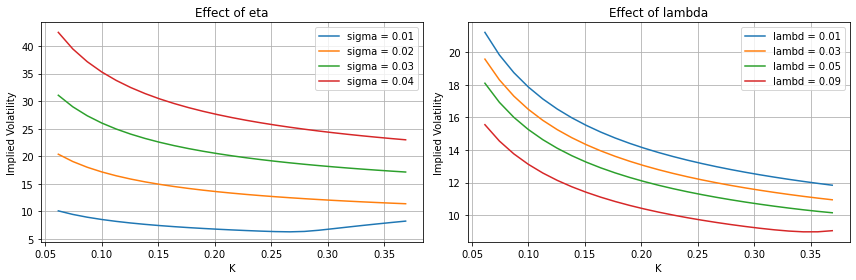

In [ ]:
import enum 
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import newton


class OptionType(enum.Enum):
    CALL = 1
    PUT = -1

def compute_Option_Price(S_0, K, sigma, tau, r, CP):
    if K is list:
        K = np.array(K).reshape( ( len(K), 1 ) )
    
    esp = 1e-16
    d1 = ( L( S_0 / K ) + ( r + 0.5 * sigma**2 ) * tau ) / ( sigma * np.sqrt( tau ) + esp )
    d2 = d1 - sigma * np.sqrt( tau )
    if CP == OptionType.CALL:
        return S_0 * stats.norm.cdf( d1 ) - K * np.exp( - r * tau ) * stats.norm.cdf( d2 )
    elif CP == OptionType.PUT:
        return - S_0 * stats.norm.cdf( - d1 ) + K * np.exp( - r * tau ) * stats.norm.cdf( - d2 )


def compute_Implied_Volatility_using_Black76(market_price, K, T, S_0, CP, verbose=0):
    sigmaGrid = np.linspace( 0.0, 5.0 ,5_000 )
    optPriceGrid = compute_Option_Price(S_0, K, sigmaGrid, T, r=0.0, CP=CP)
    sigmaInitial = np.interp(market_price, optPriceGrid, sigmaGrid)
    if verbose:
        print(f"{K = }")
        print(f"{sigmaInitial = }")
    
    f = lambda sigma : compute_Option_Price(S_0, K, sigma, T, r=0.0, CP=CP) - market_price  
    impliedVol = newton(f, sigmaInitial, tol=1e-15)
    if verbose:
        print(f"{impliedVol = }")
    if impliedVol > 2.0:
        impliedVol = 0.0
    return impliedVol


class HullWhite():
    def __init__(self, sigma, lambd, P):
        """
        Parameters: sigma : float
                            volatility parameter of Hull-White model
                    lambd : float 
                            mean reversion parameter of Hull-White model
                    P     : callable 
                            ZCB Price P(0,t) as a function of maturity t
        """
        self.sigma = sigma
        self.lambd = lambd
        self.P = P

    def compute_sigma_P(self, t, T):
        # \sigma_P(t,T) = -\int_t^T\sigma(t',T)dt' 
        #               = -\frac{\sigma}{\lambda} \left(1-e^{-\lambda(T-t)}\right)
        #               = \sigma B(t,T)
        return self.sigma * self.compute_B(t, T)

    def compute_theta(self, t):
        # \theta(t) =  f(0,t)
        #              + \frac{1}{\lambda} \frac{\partial f(0,t)}{\partial t} 
        #              + \frac{\sigma^2}{2\lambda^2} \left(1-e^{-2\lambda t}\right)
        first = f(t,self.P)
        second = df_over_dT(t,self.P) / self.lambd
        third = - self.sigma**2 / (2*self.lambd**2) * E1(-2*self.lambd*t)
        return first + second + third

    def compute_theta_T(self, t, T):
        # \theta^T(t) = \theta(t) + \frac{\sigma^2}{\lambda} B(T-t)
        first = self.compute_theta(t)
        second = self.sigma**2/self.lambd * self.compute_B(t,T)
        return first + second
    
    def compute_A(self, t, T):
        """
        Returns: A(\tau) of P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        """     
        tau = T - t  

        # head = - \frac{\sigma^2}{4\lambda^3}
        # tail = 3 - 2\lambda\tau - 4e^{-\lambda\tau} + e^{-2\lambda\tau}
        # first = head * tail 
        head = - self.sigma**2 / (4*self.lambd**3)
        tail = 3 - 2*self.lambd*tau - 4*E(-self.lambd*tau) + E(-2*self.lambd*tau)     
        first =  head * tail 

        # second = \lambda \int_0^\tau \theta(T-\tau') B(\tau') d\tau'
        tau_prime = np.linspace( 0, tau, 250 )
        theta = self.compute_theta
        B = lambda t : self.compute_B(t=0, T=t)
        second = self.lambd * trapz( theta(T-tau_prime)*B(tau_prime), tau_prime )

        # A(\tau) = first + second
        return first + second
    
    def compute_B(self, t, T):
        """
        Returns: B(\tau) of P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        """
        tau = T - t
        # B(\tau) = - \frac{1 - e^{-\lambda\tau}}{\lambda}
        return E1( - self.lambd * tau ) / self.lambd
    
    def compute_ZCB(self, t, T, r_t):
        """
        Parameters: t   : current time
                    T   : maturity of ZCB
                    r_t : current short rate

        Returns: P(t,T) : ZCB price at t
        """
        A = self.compute_A(t, T)
        B = self.compute_B(t, T)
        # P(t,T) = e^{ A(\tau) + B(\tau) r(t) }
        return E( A + B * r_t )
    
    def generate_sample_paths(self, num_paths, num_steps, T, seed=None): 
        """
        Parameters: num_paths : int
                                number of paths to generate sample paths
                    num_steps : int
                                number of coin flips to generate one sample path
                    T         : int or float 
                                maximum time span to generate sample paths
                    seed      : int
                                seed of numpy random number generator 

        Returns:  t : ndarray of shape (            num_steps + 1,) 
                      time
                  R : ndarray of shape ( num_paths, num_steps + 1 ) 
                      Hull White Short Rate
                  M : ndarray of shape ( num_paths, num_steps + 1 ) 
                      Money Market Account
        """
        if seed is not None:
            np.random.seed(seed)

        r0 = compute_r0(self.P)
        theta = self.compute_theta

        Z = np.random.normal( 0.0, 1.0, ( num_paths, num_steps ) )
        R = np.ones( ( num_paths, num_steps + 1 ) ) * r0
        M = np.ones( ( num_paths, num_steps + 1 ) )

        t = np.linspace( 0, T, num_steps + 1 )    
        dt = t[1] - t[0]
        sqrt_dt = np.sqrt(dt)
        for i in range(num_steps):
            if num_paths > 1:
                Z[:,i] = ( Z[:,i] - Z[:,i].mean() ) / Z[:,i].std()
            dW = sqrt_dt * Z[:,i]
            # Hull-White Short Rate Dynamics
            # dr(t) = \lambda \left(\theta(t)-r(t)\right) dt + \sigma dW^{\mathbb{Q}}(t)
            R[:,i+1] = R[:,i] + self.lambd * ( theta(t[i]) - R[:,i] ) * dt + self.sigma * dW
            M[:,i+1] = M[:,i] * np.exp( R[:,i] * dt )
        return t, R, M

    def compute_mu_r_T(self, T):
        r0 = compute_r0(self.P)
        theta = self.compute_theta
        
        s = np.linspace( 0.0, T, 2_500 )
        integrand = lambda s: theta(s) * E( - self.lambd * ( T - s ) )
        return r0 * E( - self.lambd * T ) + self.lambd * trapz( integrand(s), s )

    def compute_mu_r_T_ForwardMeasure(self, T):
        r0 = compute_r0(self.P)
        theta_T_Forward = lambda s, T: self.compute_theta_T(s, T)
        
        s = np.linspace( 0.0, T, 2_500 )
        integrand = lambda s: theta_T_Forward(s, T) * E( - self.lambd * ( T - s ) )
        return r0 * E( - self.lambd * T ) + self.lambd * trapz( integrand(s), s )

    def compute_sigma_square_r_T(self, T):
        return - self.sigma**2 / ( 2 * self.lambd ) * E1( -2 * self.lambd * T )

    def compute_ZCB_Option_Price(self, K, T1, T2, CP):
        A = self.compute_A(T1, T2)
        B = self.compute_B(T1, T2)
        
        mu = self.compute_mu_r_T_ForwardMeasure(T1)
        v = np.sqrt( self.compute_sigma_square_r_T(T1) )
        
        K_hat = K * E( - A )
        a = ( L( K_hat ) - B * mu ) / ( B * v )
        d1 = a - B * v
        d2 = d1 +  B * v
        value = self.P(T1) * E(A) * ( E( 0.5 * B**2 * v**2 + B * mu ) * stats.norm.cdf( d1 ) - K_hat * stats.norm.cdf( d2 ) )
        
        if CP == OptionType.CALL:
            return value
        elif CP == OptionType.PUT:
            return value - self.P(T2) + K * self.P(T1)
        
    def compute_Caplet_Floorlet_Price(self, N, K, T1, T2, CP):
        N_new = N * ( 1.0 + ( T2 - T1 ) * K )
        K_new = 1 / ( 1.0 + ( T2 - T1 ) * K )
        if CP == OptionType.CALL:
            caplet = N_new * self.compute_ZCB_Option_Price( K_new, T1, T2, CP=OptionType.PUT )
            return caplet
        elif CP == OptionType.PUT:
            floorlet = N_new * self.compute_ZCB_Option_Price( K_new, T1, T2, CP=OptionType.CALL )
            return floorlet


def main():
    CP = OptionType.CALL
    T1 = 4.0
    T2 = 8.0
    Notional = 1.0
    
    # ZCB from the market
    P = lambda T : np.exp( -0.1 * T ) 

    # define a forward rate between T1 and T2
    frwd = 1.0 / ( T2 - T1 ) * ( P(T1) / P(T2) - 1.0 )
    K = np.linspace( frwd / 2.0, 3.0 * frwd, 25 )
    
    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(12,4))
    
    ax0.set_title("Effect of eta")
    sigmas = (0.01, 0.02, 0.03, 0.04)
    lambd = 0.02
    for sigma in sigmas:
        hw = HullWhite(sigma, lambd, P)
        optPrice = hw.compute_Caplet_Floorlet_Price(Notional, K, T1, T2, CP) 
        IV = np.zeros( ( K.shape[0], 1 ) )
        for idx in range(K.shape[0]):
            valFrwd = optPrice[idx] / P(T2) / ( T2 - T1 )
            IV[idx] = compute_Implied_Volatility_using_Black76(market_price=valFrwd, K=K[idx], T=T2, S_0=frwd, CP=CP) 
        ax0.plot( K, IV*100.0, label=f'{sigma = }' )
       
    
    ax1.set_title("Effect of lambda")
    lambds = (0.01, 0.03, 0.05, 0.09)
    sigma = 0.02
    for lambd in lambds:
        hw = HullWhite(sigma, lambd, P)
        optPrice = hw.compute_Caplet_Floorlet_Price(Notional, K, T1, T2, CP) 
        IV = np.zeros( ( K.shape[0], 1 ) )
        for idx in range(K.shape[0]):
            valFrwd = optPrice[idx] / P(T2) / ( T2 - T1 )
            IV[idx] = compute_Implied_Volatility_using_Black76(market_price=valFrwd, K=K[idx], T=T2, S_0=frwd, CP=CP) 
        ax1.plot( K, IV*100.0, label=f'{lambd = }' )
    
    for ax in (ax0, ax1):
        ax.grid()
        ax.legend()
        ax.set_xlabel('K')
        ax.set_ylabel('Implied Volatility')
        
    plt.tight_layout()
    plt.show()
    
    
if __name__ == "__main__":
    main()

#####***Cap and Floor***

$$\begin{array}{lll}
\displaystyle\text{Cap}&=&\displaystyle\sum\text{Caplet}\\
\displaystyle\text{Floor}&=&\displaystyle\sum\text{Floorlet}\\
\end{array}$$

####***Section 4 Swaption***

#####***Change of Numeraire***



$$\begin{array}{lll}
\displaystyle
\text{PAYOFF}^\text{Swaption}(T_m)
&=&\displaystyle
N\max\left(A_{mn}(T_m)\left(S_{mn}(T_m)-K\right),0\right)
\end{array}$$

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
\mathbb{E}^\mathbb{Q}
\left[
\frac{M(t_0)}{M(T_m)}N\max\left(A_{mn}(T_m)\left(S_{mn}(T_m)-K\right),0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
\mathbb{E}^\mathbb{Q}
\left[
\frac{M(t_0)}{M(T_m)}N A_{mn}(T_m)\max\left(S_{mn}(T_m)-K,0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

As discussed, the annuity 
$A_{mn}(T_m)=\sum_{k=m+1}^n \tau_k P(T_m,T_k)$ is a combination of tradable ZCBs and can be considered as a numeraire. The corresponding numeraire measure is the annuity measure (also known as the swap measure) $\mathbb{Q}^{mn}$.

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
\mathbb{E}^\mathbb{Q}
\left[
\frac{M(t_0)}{M(T_m)}N A_{mn}(T_m)\max\left(S_{mn}(T_m)-K,0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
\mathbb{E}^{mn}
\left[
\frac{M(t_0)}{M(T_m)}N A_{mn}(T_m)\max\left(S_{mn}(T_m)-K,0\right)
\frac{M(T_m)/M(t_0)}{A_{mn}(T_m)/A_{mn}(t_0)}
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
N A_{mn}(t_0)\mathbb{E}^{mn}
\left[
\max\left(S_{mn}(T_m)-K,0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

#####***Swap rate $S_{mn}$ is a $\mathbb{Q}^{mn}-$martingale***



Indeed, since $
S_{mn}(t)
=\sum_{k=m+1}^n \omega_k(t)l_k(t)
=\frac{P(t,T_{m})-P(t,T_n)}{A_{mn}(t)}
$ and sicnce
$P(t,T_{m})$ and $P(t,T_{n})$ are prices of tradable assets,

$$\begin{array}{lll}
\displaystyle
\mathbb{E}^{mn}\left[S_{mn}(t)\Big{|}{\cal F}(s)\right]
&=&\displaystyle
\mathbb{E}^{mn}\left[\frac{P(t,T_{m})-P(t,T_n)}{A_{mn}(t)}\Big{|}{\cal F}(s)\right]\\
&=&\displaystyle
\frac{P(s,T_{m})-P(s,T_n)}{A_{mn}(s)}\\
&=&\displaystyle
S_{mn}(s)
\end{array}$$

#####***Black Type Formula***



Now, assume that the swap rate follows a lognormal distribution.

$$\begin{array}{lll}
\displaystyle
dS_{mn}(t)
=
\sigma_{mn}S_{mn}(t)dW^{mn}(t)
\end{array}$$

Then, we can use the Black Scholes computation with interest rate 0.

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
N A_{mn}(t_0)\mathbb{E}^{mn}
\left[
\max\left(S_{mn}(T_m)-K,0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
N A_{mn}(t_0)\left[
S_{mn}(t_0)N(d_1)-KN(d_2)
\right]\\
\end{array}$$

where

$$\begin{array}{lll}
\displaystyle
d_1
&=&\displaystyle
\frac{\log\left(\frac{S_{mn}(t_0)}{K}\right)+\frac{1}{2}\sigma_{mn}^2(T_m-t_0)}{\sigma_{mn}\sqrt{T_m-t_0}}\\
\displaystyle
d_2&=&\displaystyle
d_1-\sigma_{mn}\sqrt{T_{m}-t_0}\\
\end{array}$$

#####***Hull-White Swaption Formula***



$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
=
N\sum_{k=m+1}^n c_k V^{\text{ZCB}}_{p}(t_0,T_m,T_k;K_k)\\
\end{array}$$

where

$$\begin{array}{lll}
c_k&=&
\left\{\begin{array}{lll}
K\tau_k&&\text{for $k\neq n$}\\
K\tau_k+1&&\text{for $k= n$}\\
\end{array}\right.
\end{array}$$

where $V^{\text{ZCB}}_{p}(t_0,T_m,T_k;K_k)$ is a European put option price on a zero-coupon bond with
option maturity $T_m$, bond maturity $T_k$, and strike $K_k=e^{A(T_k-T_m)+B(T_k-T_m)r^*}$.
Here, $r^*$ is the critical short rate of the Jamshidian trick satisfying

$$
\displaystyle
1=\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r^*}
$$

***Change of Numeraire***

$$\begin{array}{lll}
\displaystyle
\text{PAYOFF}^\text{Swaption}(T_m)
&=&\displaystyle
N\max\left(
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(l_k(T_m)-K\right),0\right)
\end{array}$$

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
\mathbb{E}^\mathbb{Q}
\left[
\frac{M(t_0)}{M(T_m)}N\max\left(
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(l_k(T_m)-K\right),0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(l_k(T_m)-K\right),0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

***Crucial Expression***

$$\begin{array}{lll}
\displaystyle
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(l_k(T_m)-K\right)
&=&\displaystyle
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(\frac{1}{\tau_k}\left(\frac{P(T_m,T_{k-1})}{P(T_m,T_{k}))}-1\right)-K\right)\\
&=&\displaystyle
\sum_{k=m+1}^n 
P(T_m,T_k)
\left(\left(\frac{P(T_m,T_{k-1})}{P(T_m,T_{k}))}-1\right)-K\tau_k\right)\\
&=&\displaystyle
\sum_{k=m+1}^n 
\left(\left(P(T_m,T_{k-1})-P(T_m,T_k)\right)-K\tau_k P(T_m,T_k)\right)\\
&=&\displaystyle
1-P(T_m,T_n)
-K\sum_{k=m+1}^n \tau_k P(T_m,T_k)\\
&=&\displaystyle
1-\sum_{k=m+1}^n c_k P(T_m,T_k)\\
\end{array}$$

where

$$\begin{array}{lll}
c_k&=&
\left\{\begin{array}{lll}
K\tau_k&&\text{for $k\neq n$}\\
K\tau_k+1&&\text{for $k= n$}\\
\end{array}\right.
\end{array}$$

***Hull-White ZCB Price***

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
\sum_{k=m+1}^n 
\tau_k P(T_m,T_k)
\left(l_k(T_m)-K\right),0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
1-\sum_{k=m+1}^n c_k P(T_m,T_k),0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
1-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

***Jamshidian Trick***

The ZCB price $P(T_m,T_k)=e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)}$ at the swaption maturity $T_m$ is a function of the short rate $r(T_m)$ at $T_m$. Actually, the functions $r(T_m)\rightarrow P(T_m,T_k)$ are strictly decreasing. So, there is an $r^*$ such that

$$
\displaystyle
1=\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r^*}
$$

Then

$$\begin{array}{lll}
&&\displaystyle
\max\left(
1-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)\\
&=&\displaystyle
\max\left(
\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r^*}-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)\\
&=&\displaystyle
\left(
\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r^*}-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)}\right)
1\left(r(T_m)>r^*\right)\\
&=&\displaystyle
\sum_{k=m+1}^n 
c_k\left(e^{A(T_k-T_m)+B(T_k-T_m)r^*}-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)}\right)
1\left(r(T_m)>r^*\right)\\
\end{array}$$

######***Proof***



$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
1-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r^*}-\sum_{k=m+1}^n c_k e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\mathbb{E}^{T_m}
\left[
\sum_{k=m+1}^n 
c_k\left(e^{A(T_k-T_m)+B(T_k-T_m)r^*}-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)}\right)
1\left(r(T_m)>r^*\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\sum_{k=m+1}^n c_k\mathbb{E}^{T_m}
\left[
\left(e^{A(T_k-T_m)+B(T_k-T_m)r^*}-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)}\right)
1\left(r(T_m)>r^*\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\sum_{k=m+1}^n c_k\mathbb{E}^{T_m}
\left[
\max\left(
e^{A(T_k-T_m)+B(T_k-T_m)r^*}-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
NP(t_0,T_m)\sum_{k=m+1}^n c_k\mathbb{E}^{T_m}
\left[
\max\left(
K_k-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

where

$$
\displaystyle
K_k=e^{A(T_k-T_m)+B(T_k-T_m)r^*}
$$

Note that

$$\begin{array}{lll}
\displaystyle
V^{\text{ZCB}}_{p}(t_0,T_m,T_k;K_k)=P(t_0,T_m)\mathbb{E}^{T_m}
\left[
\max\left(
K_k-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
\end{array}$$

is a European put option price on a zero-coupon bond with
option maturity $T_m$, bond maturity $T_k$, and strike $K_k$.
So,

$$\begin{array}{lll}
\displaystyle
V^\text{Swaption}(t_0)
&=&\displaystyle
NP(t_0,T_m)\sum_{k=m+1}^n c_k\mathbb{E}^{T_m}
\left[
\max\left(
K_k-e^{A(T_k-T_m)+B(T_k-T_m)r(T_m)},0\right)
\Big|{\cal F}(t_0)\right]\\
&=&\displaystyle
N\sum_{k=m+1}^n c_k V^{\text{ZCB}}_{p}(t_0,T_m,T_k;K_k)\\
\end{array}$$

###***Chapter 10 Market Model***